In [1]:
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams.update({
    "text.usetex": True,
    'mathtext.fontset': 'stix',
    "font.family": 'STIXGeneral',
    "axes.labelpad": 8.0
})

# helper functions
def pAct(C, Ka=1.4*10**(-4), Ki=5.3*10**(-7), delE=4.5):
    """ probability of repressor/activator being active
    
    Parameters:
        - C: inducer concentration
        - Ka: dissociation constant in active state
        - Ki: dissociation constant in inactive state
        - delE: energy difference between inactive and active state
    """

    p = (1 + C/Ka)**2 / ((1 + C/Ka)**2 + np.exp(-delE)*(1 + C/Ki)**2)
    return p

def pActEC50(Ka=1.4*10**(-4), Ki=5.3*10**(-7), delE=4.5):

    a = (1/Ka**2 - np.exp(-delE)/Ki**2)
    b = 2*(1/Ka - np.exp(-delE)/Ki)
    c = 1 - np.exp(-delE)

    sols = np.roots([a, b, c])
    C = sols[sols > 0][0]

    dc = 10**(-7)
    dpdc = C*(pAct(C + dc) - pAct(C))/dc
    y = 1/2 - dpdc * np.log(C)

    print([C, dpdc, y])
    return [C, dpdc, y]

def normalize(x):
    """ Normalize an array such that 
    min(x) = 0
    max(x) = 1
    """
    return (x - min(x)) / (max(x) - min(x))

def normalize_pulse(x, xmax, xmin):
    """ Normalize an array such that 
    min(x) = 0
    max(x) = 1
    """
    print(xmin, xmax)
    return (x - xmin) / (xmax - xmin)

## Thermodynamic Formulation

In [2]:
def steadyStateFeedForward(X, rys, rzs, w, px, py, Ks):
    
    Kxy, Kxz, Kyz = Ks

    Y = (rys[0] + rys[1]*px*X/Kxy)/(1 + px*X/Kxy)
    Z = (rzs[0] + rzs[1]*(px*X/Kxz + py*Y/Kyz) +\
                             w*rzs[2]*px*X/Kxz*py*Y/Kyz)/(1 + px*X/Kxz + py*Y/Kyz + w*px*X/Kxz*py*Y/Kyz)

    if type(Y) is np.float64:
        return np.array([X, Y, Z])
    else:
        Xarray = np.full_like(Y, X)
        return [Xarray, Y, Z]

def steadyStateSimpleReg(X, Y, rzs, w, px, py, Ks):

    Kxy, Kxz, Kyz = Ks
    
    Z = (rzs[0] + rzs[1]*(px*X/Kxz + py*Y/Kyz) +\
                             w*rzs[2]*px*X/Kxz*py*Y/Kyz)/(1 + px*X/Kxz + py*Y/Kyz + w*px*X/Kxz*py*Y/Kyz)
    
    return np.array([X, Y, Z])

def evolveFeedForward(Rs, rys, rzs, w, px, py, delt, Ks):

    Kxy, Kxz, Kyz = Ks

    dRsdt = np.zeros_like(Rs)
    dRsdt[1] = - Rs[1] + (rys[0] + rys[1]*px*Rs[0]/Kxy)/(1 + px*Rs[0]/Kxy)
    dRsdt[2] = - Rs[2] + (rzs[0] + rzs[1]*(px*Rs[0]/Kxz + py*Rs[1]/Kyz) +\
                             w*rzs[2]*px*Rs[0]/Kxz*py*Rs[1]/Kyz)/(1 + px*Rs[0]/Kxz + py*Rs[1]/Kyz + w*px*Rs[0]/Kxz*py*Rs[1]/Kyz)
    
    Rs_new = Rs + dRsdt * delt

    return Rs_new

def evolveSimpleReg(Rs, rys, rzs, w, px, py, delt, Ks):

    Kxy, Kxz, Kyz = Ks

    dRsdt = np.zeros_like(Rs)
    activation = (rzs[0] + rzs[1]*(px*Rs[0]/Kxz + py*Rs[1]/Kyz) +\
                             w*rzs[2]*px*Rs[0]/Kxz*py*Rs[1]/Kyz)/(1 + px*Rs[0]/Kxz + py*Rs[1]/Kyz + w*px*Rs[0]/Kxz*py*Rs[1]/Kyz)
    dRsdt[2] = - Rs[2] + activation
    
    Rs_new = Rs + dRsdt * delt

    return Rs_new

In [ ]:
# time scale for simple regulation

nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2.5]
rzs = [1, 1, 1]
w = 0

# defining how inducer concentration is tuned
flat = np.full(int(nstep/5), 10**(-3))
flat_low = np.full(int(nstep/5), 10**(-7))
increase = np.logspace(-7, -3, int(nstep/5))
decrease = np.logspace(-3, -7, int(nstep/5))

# Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
Cxs = np.concatenate((flat, flat_low, flat_low, flat_low, flat))
Cys = np.full(nstep, 10**(-7))

pxs = pAct(Cxs)
pys = pAct(Cys)


R1s = np.zeros((nstep, 3))
X, Y1 = [0.1, 0.1]
R1s[0, :] = steadyStateSimpleReg(X, Y1, rzs, w, pxs[0], pys[0])

R2s = np.zeros((nstep, 3))
X, Y2 = [0.1, 0.5]
R2s[0, :] = steadyStateSimpleReg(X, Y2, rzs, w, pxs[0], pys[0])

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    R1s[i+1, :] = evolveSimpleReg(R1s[i, :], [0, 0], rzs, w, px, py, delt)
    R2s[i+1, :] = evolveSimpleReg(R2s[i, :], [0, 0], rzs, w, px, py, delt)

fig, axs = plt.subplots(3, 1, figsize=(6.4, 7.5), height_ratios=[0.2, 0.2, 0.6])

if True:
    axs[0].plot(ts, Cxs, label=r"$C_X$")
    axs[0].plot(ts, Cys, label=r"$C_Y$")
    axs[0].set_ylabel(r"$C \, (mM)$", fontsize=18)
    axs[0].set_yscale("log")
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

    axs[1].plot(ts, pAct(Cxs), label=r"$p_{act,X}$")
    axs[1].plot(ts, pAct(Cys), label=r"$p_{act,Y}$")
    axs[1].set_ylabel(r"$p_{act}$", fontsize=18)
    # axs[0].set_yscale("log")
    axs[1].legend()
    axs[1].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 0]/max(Rs[:, 0]), label=r"$X$")
# axs[2].plot(ts, Rs[:, 1]/max(Rs[:, 1]), label=r"$Y$")
axs[2].plot(ts, normalize(R1s[:, 2]), label=r"$Z_1$")
axs[2].plot(ts, normalize(R2s[:, 2]), label=r"$Z_2$")
axs[2].set_xlabel(r"$t \, (1/\gamma)$")
axs[2].set_ylabel(r"Normalized Concentration")
axs[2].legend()
fig.align_labels()
plt.show()

TypeError: steadyStateSimpleReg() missing 1 required positional argument: 'Ks'

We see that if normalized properly, $Y$ does not change the time scale of the dynamics of $Z$.

0.1 0.0008358742446366465


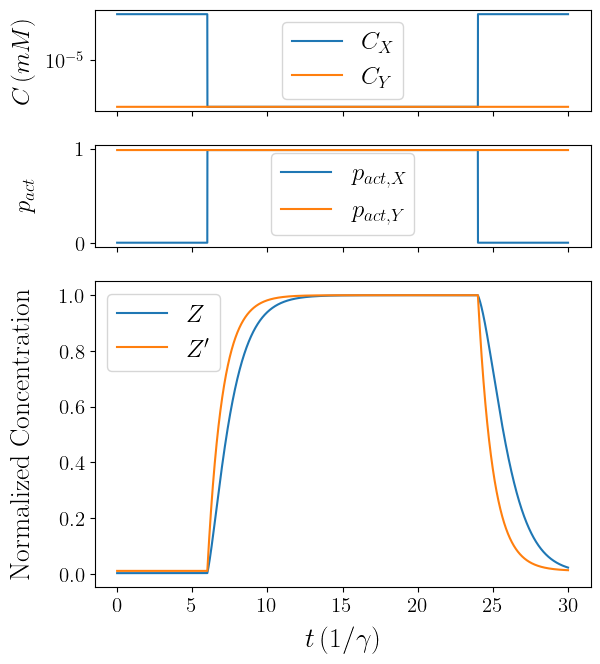

In [ ]:
nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 5]
rzs = [0, 5, 5]
w = 0

# defining how inducer concentration is tuned

flat = np.full(int(nstep/5), 10**(-3))
flat_low = np.full(int(nstep/5), 10**(-7))
increase = np.logspace(-7, -3, int(nstep/5))
decrease = np.logspace(-3, -7, int(nstep/5))

# Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
Cxs = np.concatenate((flat, flat_low, flat_low, flat_low, flat))
Cys = np.full(nstep, 10**(-7))

pxs = pAct(Cxs)
pys = pAct(Cys)

Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForward(0.1, rys, rzs, w, pxs[0], pys[0])

Rps = np.zeros((nstep, 3))
X, Y = Rs[0, :2]
Rps[0, :] = steadyStateSimpleReg(X, Y, rzs, w, pxs[0], pys[0])

print(X, Y)
for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt)
    Rps[i+1, :] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt)

fig, axs = plt.subplots(3, 1, figsize=(6.4, 7.5), height_ratios=[0.2, 0.2, 0.6])

if True:
    axs[0].plot(ts, Cxs, label=r"$C_X$")
    axs[0].plot(ts, Cys, label=r"$C_Y$")
    axs[0].set_ylabel(r"$C \, (mM)$", fontsize=18)
    axs[0].set_yscale("log")
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

    axs[1].plot(ts, pAct(Cxs), label=r"$p_{act,X}$")
    axs[1].plot(ts, pAct(Cys), label=r"$p_{act,Y}$")
    axs[1].set_ylabel(r"$p_{act}$", fontsize=18)
    # axs[0].set_yscale("log")
    axs[1].legend()
    axs[1].xaxis.set_ticklabels([])

axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
# axs[2].plot(ts, Rs[:, 1]/max(Rs[:, 1]), label=r"$Y$")
# axs[2].plot(ts, normalize(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, normalize(Rps[:, 2]), label=r"$Simple Regulation$")
axs[2].set_xlabel(r"$t \, (1/\gamma)$")
axs[2].set_ylabel(r"Normalized Concentration")
axs[2].legend()
fig.align_labels()

# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\0826\fedFor7.pdf", format="pdf", bbox_inches="tight")
plt.show()

But the OR gate limit still doesn't match the case described in Alon. Let's try to just replicate Alon result for now.

## Hill function formulation

In [5]:
def steadyStateFeedForwardHill(X, rys, rzs, w, px, py, Ks, H):

    Kxy, Kxz, Kyz = Ks
    Y = (rys[0] + rys[1]*(px*X/Kxy)**H)/(1 + (px*X/Kxy)**H)

    if w == 0:
        Z = rzs[1]*((px*X/Kxz)**H + (py*Y/Kyz)**H)/(1+(px*X/Kxz)**H+(py*Y/Kyz)**H)
    else:
        Z = rzs[1]*((px*X/Kxz)**H * (py*Y/Kyz)**H) / (1+(px*X/Kxz)**H) / (1+(py*Y/Kyz)**H)

    return np.array([X, Y, Z])

def steadyStateSimpleRegHill(X, Y, rzs, w, px, py, Ks, H):

    Kxy, Kxz, Kyz = Ks

    if w == 0:
        Z = rzs[1]*((px*X/Kxz)**H + (py*Y/Kyz)**H) / (1+(px*X/Kxz)**H + (py*Y/Kyz)**H)
    else:
        Z = rzs[1]*((px*X/Kxz)**H * (py*Y/Kyz)**H) / (1+(px*X/Kxz)**H) / (1+(py*Y/Kyz)**H)

    return np.array([X, Y, Z])

def evolveFeedForwardHill(Rs, rys, rzs, w, px, py, delt, Ks, H):

    dRsdt = np.zeros_like(Rs)
    Kxy, Kxz, Kyz = Ks

    X = Rs[0]

    dRsdt[1] = - Rs[1] + (rys[1]*(px*X/Kxy)**H)/(1 + (px*X/Kxy)**H)
    if w == 0:
        # OR logic
        dRsdt[2] = - Rs[2] + rzs[1]*((px*X/Kxz)**H + (py*Rs[1]/Kyz)**H) / (1+(px*X/Kxz)**H + (py*Rs[1]/Kyz)**H)
    else:
        # AND logic
        dRsdt[2] = - Rs[2] + rzs[1]*((px*X/Kxz)**H * (py*Rs[1]/Kyz)**H) / (1+(px*X/Kxz)**H) / (1+(py*Rs[1]/Kyz)**H)
    
    Rs_new = Rs + dRsdt * delt

    return Rs_new

def evolveSimpleRegHill(Rs, rys, rzs, w, px, py, delt, Ks, H):

    dRsdt = np.zeros_like(Rs)
    Kxy, Kxz, Kyz = Ks

    X = Rs[0]

    if w == 0:
        # OR logic
        dRsdt[2] = - Rs[2] + rzs[1]*((px*X/Kxz)**H + (py*Rs[1]/Kyz)**H) / (1+(px*X/Kxz)**H + (py*Rs[1]/Kyz)**H)
    else:
        # AND logic
        dRsdt[2] = - Rs[2] + rzs[1]*((px*X/Kxz)**H * (py*Rs[1]/Kyz)**H) / (1+(px*X/Kxz)**H) / (1+(py*Rs[1]/Kyz)**H)
    
    Rs_new = Rs + dRsdt * delt

    return Rs_new

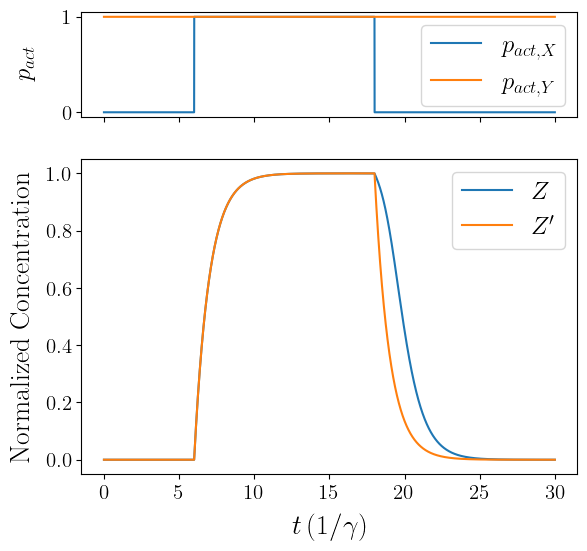

In [ ]:
nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 1]
rzs = [0, 1, 10]
w = 0

Ks = [0.5, 0.1, 0.3]

# defining how inducer concentration is tuned

empty = np.full(int(nstep/5), 0)
full = np.full(int(nstep/5), 1)

# Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
# Cys = np.full(nstep, 10**(-7))

pxs = np.concatenate((empty, full, full, empty, empty))
pys = np.full(nstep, 1)

Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForwardHill(1, rys, rzs, w, pxs[0], pys[0], Ks, 2)

Rps = np.zeros((nstep, 3))
X, Y = [1, 1]
Rps[0, :] = steadyStateSimpleRegHill(X, Y, rzs, w, pxs[0], pys[0], Ks, 2)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForwardHill(Rs[i, :], rys, rzs, w, px, py, delt, Ks, 2)
    Rps[i+1, :] = evolveSimpleRegHill(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks, 2)

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
# axs[0].set_yscale("log")
axs[0].legend()
axs[0].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, normalize(Rs[:, 2]), label=r"$Z$")
axs[1].plot(ts, normalize(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()

# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\0826\fedFor7.pdf", format="pdf", bbox_inches="tight")
plt.show()

Finally reproduced ... but this seems to be an artifact of dissociation constants $K_d$. Is this the "disfunctional" case?

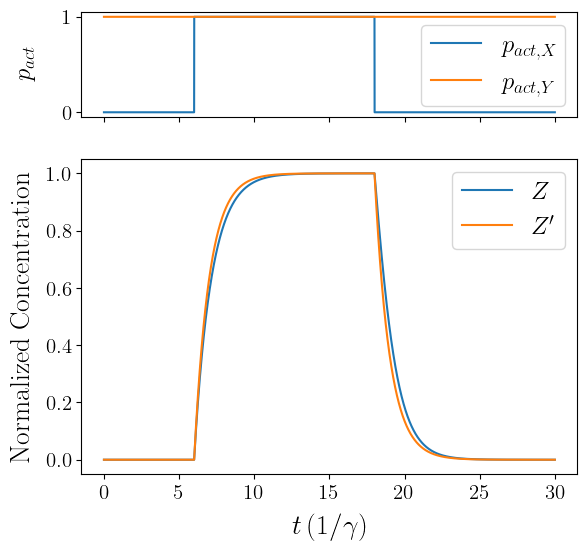

In [ ]:
nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 1]
rzs = [0, 1, 10]
w = 0

Ks = [1, 1, 1]
H = 2
# defining how inducer concentration is tuned

empty = np.full(int(nstep/5), 0)
full = np.full(int(nstep/5), 1)

# Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
# Cys = np.full(nstep, 10**(-7))

pxs = np.concatenate((empty, full, full, empty, empty))
pys = np.full(nstep, 1)

Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForwardHill(1, rys, rzs, w, pxs[0], pys[0], Ks, H)

Rps = np.zeros((nstep, 3))
X, Y = [1, 1]
Rps[0, :] = steadyStateSimpleRegHill(X, Y, rzs, w, pxs[0], pys[0], Ks, H)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForwardHill(Rs[i, :], rys, rzs, w, px, py, delt, Ks, H)
    Rps[i+1, :] = evolveSimpleRegHill(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks, H)

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
# axs[0].set_yscale("log")
axs[0].legend()
axs[0].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, normalize(Rs[:, 2]), label=r"$Z$")
axs[1].plot(ts, normalize(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()

# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\0826\fedFor7.pdf", format="pdf", bbox_inches="tight")
plt.show()

Also, let's check the case for other choices of Hill coefficient $H$. It seems that the case $H = 1$ should also work ... in theory no need to expand our thermodynamic model to two binding sites per TF.

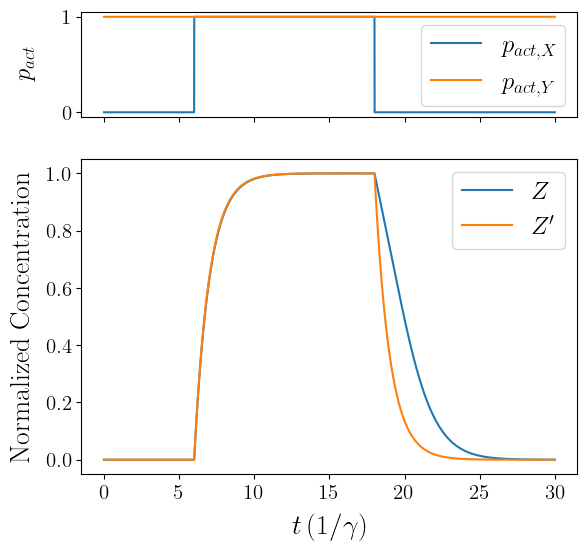

In [ ]:
nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 1]
rzs = [0, 1, 10]
w = 0

Ks = [0.5, 0.1, 0.3]
H = 1
# defining how inducer concentration is tuned

empty = np.full(int(nstep/5), 0)
full = np.full(int(nstep/5), 1)

# Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
# Cys = np.full(nstep, 10**(-7))

pxs = np.concatenate((empty, full, full, empty, empty))
pys = np.full(nstep, 1)

Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForwardHill(1, rys, rzs, w, pxs[0], pys[0], Ks, H)

Rps = np.zeros((nstep, 3))
X, Y = [1, 1]
Rps[0, :] = steadyStateSimpleRegHill(X, Y, rzs, w, pxs[0], pys[0], Ks, H)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForwardHill(Rs[i, :], rys, rzs, w, px, py, delt, Ks, H)
    Rps[i+1, :] = evolveSimpleRegHill(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks, H)

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

if True:
    axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
    axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    # axs[0].set_yscale("log")
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, normalize(Rs[:, 2]), label=r"$Z$")
axs[1].plot(ts, normalize(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()

# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\0826\fedFor7.pdf", format="pdf", bbox_inches="tight")
plt.show()

After modifying our thermodynamic formulation to include the effect of $K_d$, let's test it.

## Back to thermodynamics, coherent FFL

OR gate limit: $\omega \to 0$

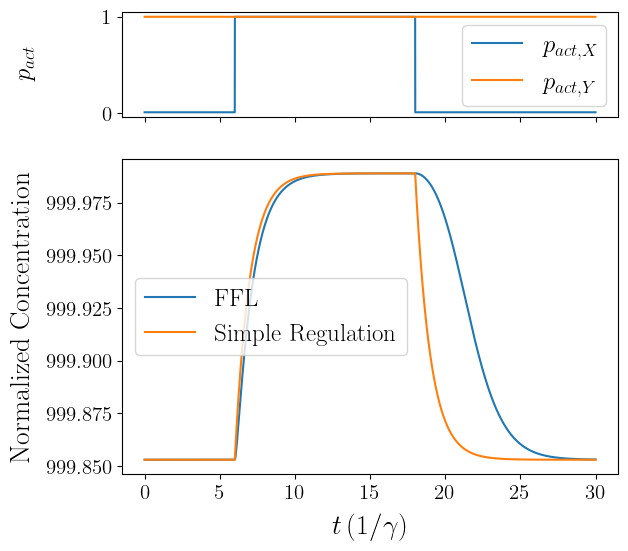

In [131]:
nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 10**3]
rzs = [0, 10**3, 20]
w = 0

# Ks = [0.5, 0.1, 0.3]
Ks = [1, 1, 10**(-2)]
# defining how inducer concentration is tuned

pmin = pAct(10**(-4))
pmax = 1

empty = np.full(int(nstep/5), pmin)
full = np.full(int(nstep/5), pmax)
# empty = np.full(int(nstep/5), 0)
# full = np.full(int(nstep/5), 1)

pxs = np.concatenate((empty, full, full, empty, empty))
pys = np.full(nstep, pmax)

X = 10
Ymax = steadyStateFeedForward(X, rys, rzs, w, pmax, pmax, Ks)[1]
Ymin = steadyStateFeedForward(X, rys, rzs, w, pmin, pmax, Ks)[1]

empty_Y = np.full(int(nstep/5), Ymin)
full_Y = np.full(int(nstep/5), Ymax)
Ys = np.concatenate((empty_Y, full_Y, full_Y, empty_Y, empty_Y))

Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForward(X, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.copy(Rs)
Rps[:, 0] = np.full(nstep, X)
Rps[:, 1] = np.copy(Ys)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
    Rps[i+1, 2] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)[2]

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

# print(np.max(Rs[:, 2]) - np.min(Rs[:, 2]))
if True:
    axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
    axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    # axs[0].set_yscale("log")
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, Rs[:, 2], label=r"FFL")
axs[1].plot(ts, Rps[:, 2], label=r"Simple Regulation")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()
# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_schematic.svg", format="svg", bbox_inches="tight")
plt.show()

AND gate limit: $\omega \neq 0$, $r_1 \to 0$. Notice we change the parameters a little. Perhaps region of functionality differs between AND and OR logic. We need to systematically find the region of functional parameters.

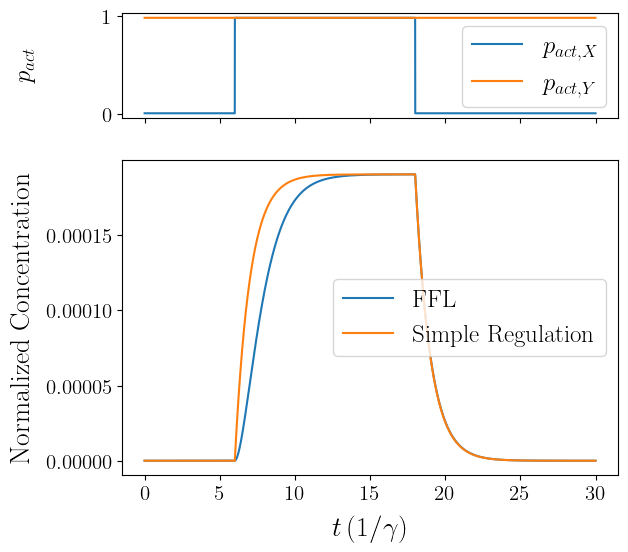

In [42]:
nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

if False:
    rys = [0, 2]
    rzs = [0, 0, 2]
    w = 10

    Ks = [1, 1, 5]
if True:
    rys = [0, 2]
    rzs = [0, 0, 2]
    w = 10

    Ks = [1, 100, 10**3]
# defining how inducer concentration is tuned

empty = np.full(int(nstep/5), pAct(10**(-4)))
full = np.full(int(nstep/5), pAct(10**(-7)))
# empty = np.full(int(nstep/5), 0)
# full = np.full(int(nstep/5), 1)

pxs = np.concatenate((empty, full, full, empty, empty))
pys = np.full(nstep, pAct(10**(-7)))

X = 1
Ymax = steadyStateFeedForward(X, rys, rzs, w, pAct(10**(-7)), pAct(10**(-7)), Ks)[1]
Ymin = steadyStateFeedForward(X, rys, rzs, w, pAct(10**(-4)), pAct(10**(-7)), Ks)[1]

empty_Y = np.full(int(nstep/5), Ymin)
full_Y = np.full(int(nstep/5), Ymax)
Ys = np.concatenate((empty_Y, full_Y, full_Y, empty_Y, empty_Y))

Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForward(X, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.copy(Rs)
Rps[:, 0] = np.full(nstep, X)
Rps[:, 1] = np.copy(Ys)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
    Rps[i+1, 2] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)[2]

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

# print(np.max(Rs[:, 2]) - np.min(Rs[:, 2]))
if True:
    axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
    axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    # axs[0].set_yscale("log")
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, Rs[:, 2], label=r"FFL")
axs[1].plot(ts, Rps[:, 2], label=r"Simple Regulation")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()
# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_schematic.svg", format="svg", bbox_inches="tight")
plt.show()

Also, before we are using boolean functions for $p_{act}$. Let's go back to our thermodynamic $p_{act}$ and see if everything still behaves well.

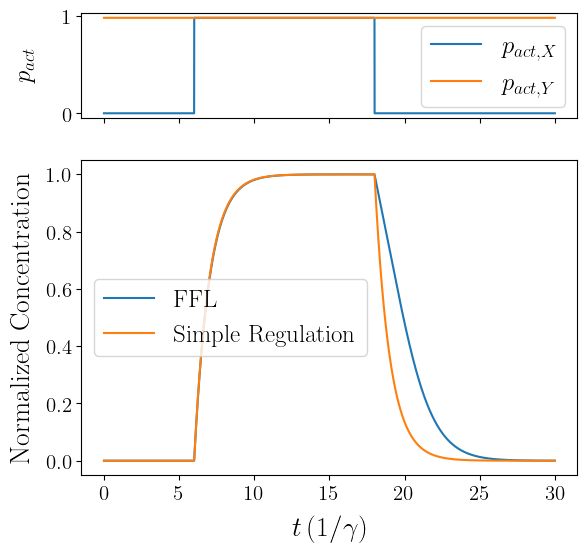

In [31]:
nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 1]
rzs = [0, 1, 10]
w = 0

Ks = [0.5, 0.1, 0.3]
# defining how inducer concentration is tuned

# Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
Cys = np.full(nstep, 10**(-7))

pxs = pAct(Cxs)
pys = pAct(Cys)

Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForward(1, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.zeros((nstep, 3))
X, Y = [1, 1]
Rps[0, :] = steadyStateSimpleReg(X, Y, rzs, w, pxs[0], pys[0], Ks)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
    Rps[i+1, :] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

if True:
    axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
    axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    # axs[0].set_yscale("log")
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, normalize(Rs[:, 2]), label=r"FFL")
axs[1].plot(ts, normalize(Rps[:, 2]), label=r"Simple Regulation")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()
# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\0826\fedFor7.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Mixed AND OR Logic

Effect of mixing AND, OR logic gates: we can have delays in both ON and OFF steps.

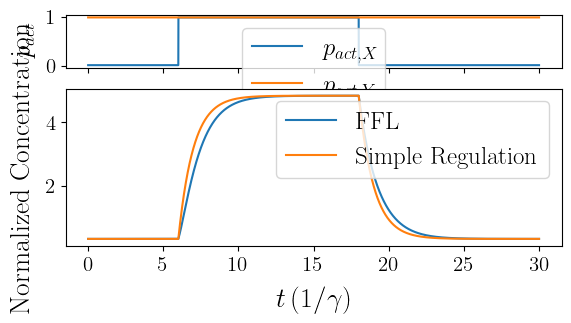

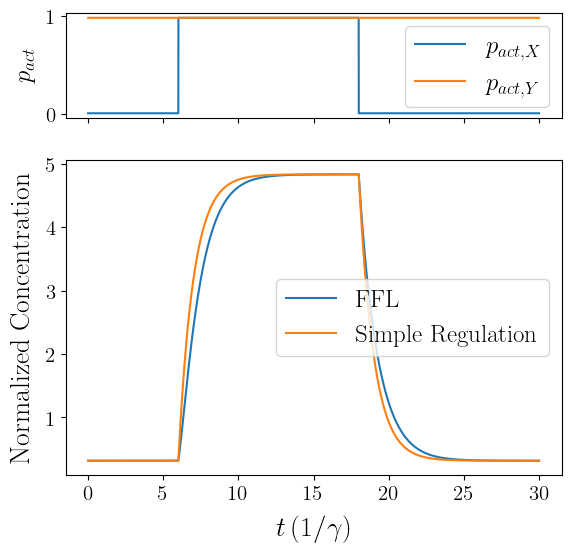

In [29]:
nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0.1, 2]
rzs = [0.1, 2, 10]
w = 2

Ks = [1, 1, 1]
# defining how inducer concentration is tuned

empty = np.full(int(nstep/5), pAct(10**(-4)))
full = np.full(int(nstep/5), pAct(10**(-7)))
# empty = np.full(int(nstep/5), 0)
# full = np.full(int(nstep/5), 1)

pxs = np.concatenate((empty, full, full, empty, empty))
pys = np.full(nstep, pAct(10**(-7)))

X = 1
Ymax = steadyStateFeedForward(X, rys, rzs, w, pAct(10**(-7)), pAct(10**(-7)), Ks)[1]
Ymin = steadyStateFeedForward(X, rys, rzs, w, pAct(10**(-4)), pAct(10**(-7)), Ks)[1]

empty_Y = np.full(int(nstep/5), Ymin)
full_Y = np.full(int(nstep/5), Ymax)
Ys = np.concatenate((empty_Y, full_Y, full_Y, empty_Y, empty_Y))

Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForward(X, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.copy(Rs)
Rps[:, 0] = np.full(nstep, X)
Rps[:, 1] = np.copy(Ys)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
    Rps[i+1, 2] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)[2]

fig, axs = plt.subplots(2, 1, figsize=(6.4, 3), height_ratios=[0.25, 0.75])

# print(np.max(Rs[:, 2]) - np.min(Rs[:, 2]))
if True:
    axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
    axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    # axs[0].set_yscale("log")
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, Rs[:, 2], label=r"FFL")
axs[1].plot(ts, Rps[:, 2], label=r"Simple Regulation")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()
# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_weird_or.svg", format="svg", bbox_inches="tight")
plt.show()

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

if True:
    axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
    axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    # axs[0].set_yscale("log")
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, Rs[:, 2], label=r"FFL")
axs[1].plot(ts, Rps[:, 2], label=r"Simple Regulation")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()
# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_weird_or.svg", format="svg", bbox_inches="tight")
plt.show()

Now, let's look at the effect of continuous tuning of inducer concentration. We see that interestingly FFL has an accelerated response for the ON step, and a delayed response for the OFF step. We do have to be careful here, since it seems that for the simple regulation, different values of $Y$ yields slightly different curves.

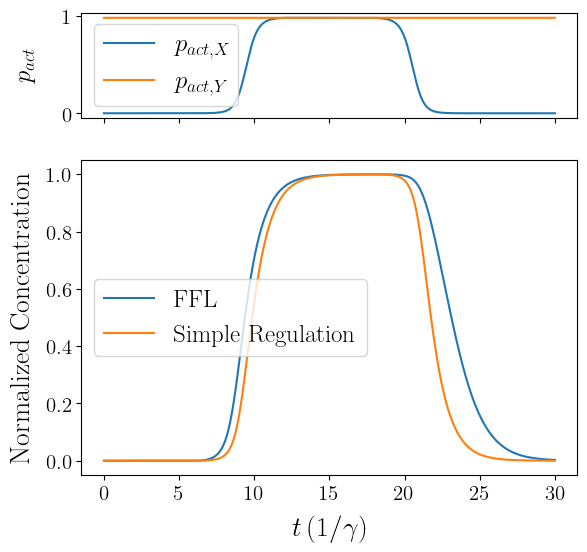

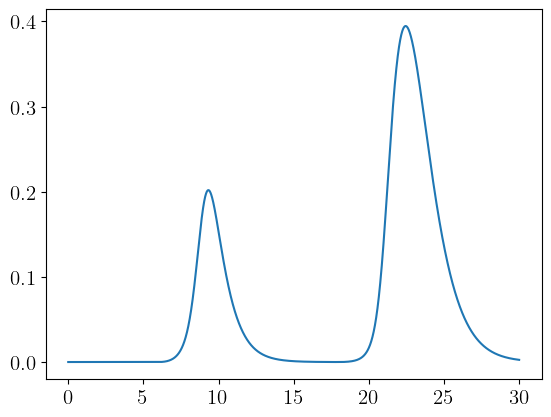

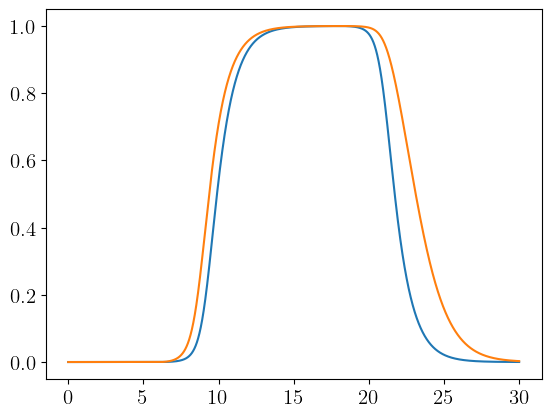

In [28]:
# defining how inducer concentration is tuned
flat = np.full(int(nstep/5), 10**(-3))
flat_low = np.full(int(nstep/5), 10**(-7))
increase = np.logspace(-7, -3, int(nstep/5))
decrease = np.logspace(-3, -7, int(nstep/5))

nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 1]
rzs = [0, 1, 10]
w = 0

Ks = [0.5, 0.1, 0.3]
# defining how inducer concentration is tuned

Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
Cys = np.full(nstep, 10**(-7))

pxs = pAct(Cxs)
pys = pAct(Cys)

Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForward(1, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.zeros((nstep, 3))
X, Y = [1, 1]
Rps[0, :] = steadyStateSimpleReg(X, Y, rzs, w, pxs[0], pys[0], Ks)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
    Rps[i+1, :] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

if True:
    axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
    axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    # axs[0].set_yscale("log")
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, normalize(Rs[:, 2]), label=r"FFL")
axs[1].plot(ts, normalize(Rps[:, 2]), label=r"Simple Regulation")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()
# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\0826\fedFor7.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.plot(ts, normalize(Rs[:, 2]) - normalize(Rps[:, 2]))
plt.show()

plt.plot(ts, normalize(Rs[:, 1]))
plt.plot(ts, normalize(Rs[:, 2]))
plt.show()

## Functional parameters

Let's just look at $K_d$ for now, which seems to be more important than it seems ... Normalize concentration with respect to $K_{xy}$

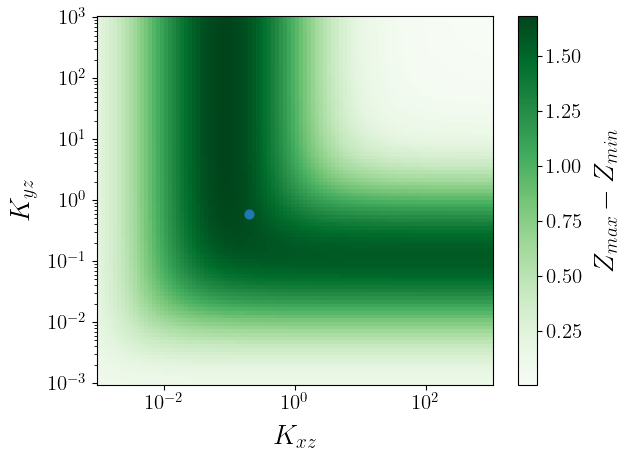

In [26]:
# Let's first try the OR gate

length = 100

# define rate parameters and cooperativity
rys = [0, 2]
rzs = [0, 2, 20]
w = 0

px_low = pAct(10**(-4))
px_high = pAct(10**(-7))

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

KX, KY = np.meshgrid(Kxzs, Kyzs)
KXY = np.full_like(KX, 1)
Ks = [KXY, KX, KY]

Xs = np.full_like(KX, 1)

[_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, px_low, 1, Ks)
[_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, px_high, 1, Ks)

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, highZ - lowZ, cmap="Greens")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
ax.scatter(0.2, 0.6, s = 40)
cbar = plt.colorbar(im)
cbar.set_label(r"$Z_{max} - Z_{min}$")
plt.show()

0.01449245313931131
0.9922238672551266


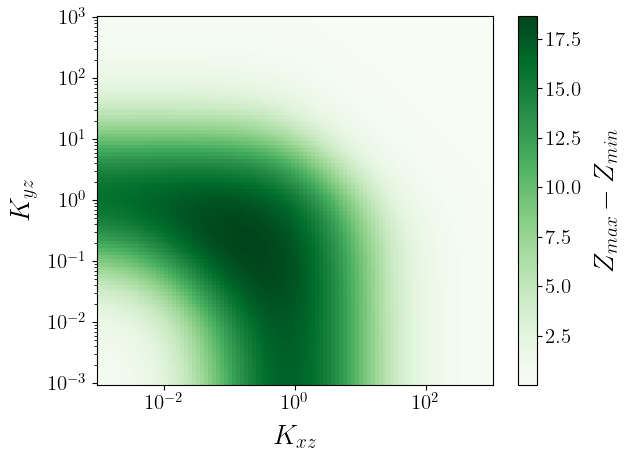

In [ ]:
# Let's now try the AND gate

length = 100

# define rate parameters and cooperativity
rys = [0, 2]
rzs = [0, 0, 20]
w = 10

px_low = pAct(10**(-4))
px_high = pAct(10**(-7))

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

KX, KY = np.meshgrid(Kxzs, Kyzs)
KXY = np.full_like(KX, 1)
Ks = [KXY, KX, KY]

Xs = np.full_like(KX, 1)

[_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, px_low, 1, Ks)
[_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, px_high, 1, Ks)

print(np.max(lowY))
print(np.max(highY))

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, highZ - lowZ, cmap="Greens")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
cbar = plt.colorbar(im)
cbar.set_label(r"$Z_{max} - Z_{min}$")
plt.show()

## Time scales

Analytically, we can see that for simple regulation, we expect the simple regulation to be a simple relation with time scale $\gamma$, which is set to be 1 in this case. Let's test it.

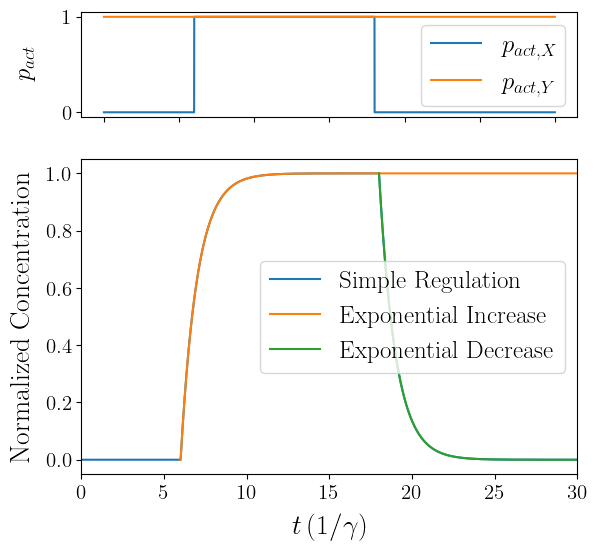

In [46]:
nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2]
rzs = [0, 2, 20]
w = 0

# Ks = [0.5, 0.1, 0.3]
Ks = [1, 0.2, 0.6]
# defining how inducer concentration is tuned

empty = np.full(int(nstep/5), 0)
full = np.full(int(nstep/5), 1)

# Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
# Cys = np.full(nstep, 10**(-7))

pxs = np.concatenate((empty, full, full, empty, empty))
pys = np.full(nstep, 1)

Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForward(1, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.zeros((nstep, 3))
X, Y = [1, 1]
Rps[0, :] = steadyStateSimpleReg(X, Y, rzs, w, pxs[0], pys[0], Ks)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
    Rps[i+1, :] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
# axs[0].set_yscale("log")
axs[0].legend()
axs[0].xaxis.set_ticklabels([])

expIncrease = np.max(normalize(Rps[:, 2])) * (1 - np.exp(- ts))
expDecrease = np.max(normalize(Rps[:, 2])) * np.exp(- ts)

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
# axs[1].plot(ts, normalize(Rs[:, 2]), label=r"FFL")
axs[1].plot(ts, normalize(Rps[:, 2]), label=r"Simple Regulation")
axs[1].plot(ts + nstep/5*delt, expIncrease, label=r"Exponential Increase")
axs[1].plot(ts + 3*nstep/5*delt, expDecrease, label=r"Exponential Decrease")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
axs[1].set_xlim((0, 30))
fig.align_labels()
plt.show()

## Analytic solution of FFL

FFL dynamic equations are in fact analytically solvable when the signal is step-function-like. Let's check that we have the right solution and its consequences.

In [3]:
def analytic_Z(ts, rs, w, X, yinit, yinf, z0):

    r0, r1, r2 = rs
    y0 = yinf
    y1 = yinit - yinf

    integral = 1/(1 + X + y0 + w*X*y0)**2 * (np.exp(ts) * (1 + X + y0 + w*X*y0)*\
                        (r0 + r1*(X + y0) + r2*w*X*y0) - (r0*(1+w*X) - r2*w*X*(1+X) +\
                        r1*(-1+w*X**2)) * y1 * np.log(np.exp(ts)*(1 + X + y0*(1 + w*X)) + y1*(1 + w*X)))
    integral0 = 1/(1 + X + y0 + w*X*y0)**2 * ((1 + X + y0 + w*X*y0)*\
                        (r0 + r1*(X + y0) + r2*w*X*y0) - (r0*(1+w*X) - r2*w*X*(1+X) +\
                        r1*(-1+w*X**2)) * y1 * np.log((1 + X + y0*(1 + w*X)) + y1*(1 + w*X)))
    zs = np.exp(-ts)*(integral - integral0 + z0)

    return zs

def diff_func(ts, rs, w, X, delY, Yinf):
    
    r0, r1, r2 = rs

    S = 1 + X + Yinf + w*X*Yinf
    chi = (r1 + r2*w*X*(1 + X)) - (r0*(1 + w*X) + r1*w*X**2)
    
    return np.exp(-ts)*(chi*delY/S**2)*np.log((S*np.exp(ts) + delY*(1 + w*X))/(S + delY*(1 + w*X)))

def int_delta(rs, w, X, delY, Yinf):

    r0, r1, r2 = rs

    S = 1 + X + Yinf + w*X*Yinf
    Phi = (r1 + r2*w*X*(1 + X)) - (r0*(1 + w*X) + r1*w*X**2)
    return Phi/(S*(1 + w*X))*np.log(1 + delY * (1+w*X) / S)

def off_divided_by_on(rys, rzs, w, X, pmax, pmin, Kxz, Kyz):

    r0y, r1y = rys
    r0, r1, r2 = rzs

    Xmax = pmax*X/Kxz
    Xmin = pmin*X/Kxz

    # assuming pact, y doesnt change
    Ymax = pmax*(r0y + r1y*Xmax*Kxz)/(1 + Xmax*Kxz)/Kyz
    Ymin = pmax*(r0y + r1y*Xmin*Kxz)/(1 + Xmin*Kxz)/Kyz

    Son = 1 + Xmax + Ymax + w*Xmax*Ymax
    Soff = 1 + Xmin + Ymin + w*Xmin*Ymin

    Phi_on = w*Xmax**2*(r2 - r1) + w*Xmax*(r2 - r0) + (r1 - r0)
    Phi_off = w*Xmin**2*(r2 - r1) + w*Xmin*(r2 - r0) + (r1 - r0)

    delY = Ymax - Ymin
    
    On_int = Phi_on / (Son * (1 + w*Xmax)) * np.log(1 - delY*((1 + w*Xmax)/Son))
    Off_int = Phi_off / (Soff * (1 + w*Xmin)) * np.log(1 + delY*((1 + w*Xmin)/Soff))
    return Phi_off/Phi_on * Son * (1 + w*Xmax) / (Soff * (1 + w*Xmin)) * np.log(delY*((1 + w*Xmin)/Soff + (1 + w*Xmax)/Son))

In [114]:
rys = [0, 2]
rzs = [0, 0, 2]
w = 10

Ks = [1, 10**(-2), 10**(-1)]

plow = pAct(10**(-4))
phigh = pAct(10**(-7))

[_, lowY, lowZ] = steadyStateFeedForward(1, rys, rzs, w, plow, phigh, Ks)
[_, highY, highZ] = steadyStateFeedForward(1, rys, rzs, w, phigh, phigh, Ks)

print(highZ)
print(lowZ)
print(int_delta(rzs, w, 1, highY - lowY, lowY))

1.977543055360311
0.7147990195198529
3.011771742275874


In [40]:
rys = [1, 2]
rzs = [1, 2, 20]
w = 0
Ks = [1, 0.2, 0.6]

print(off_divided_by_on(rys, rzs, w, 1, pAct(10**(-7)), pAct(10**(-3)), Ks[1], Ks[2]))

-0.012158313273697471
0.1006465980841303
-8.278006646025712
-2.872706608818718


Let's look at the difference between FFL and simple regulation, in a normalized manner such that both trajectories have the same initial and end state.

-0.824071161047131


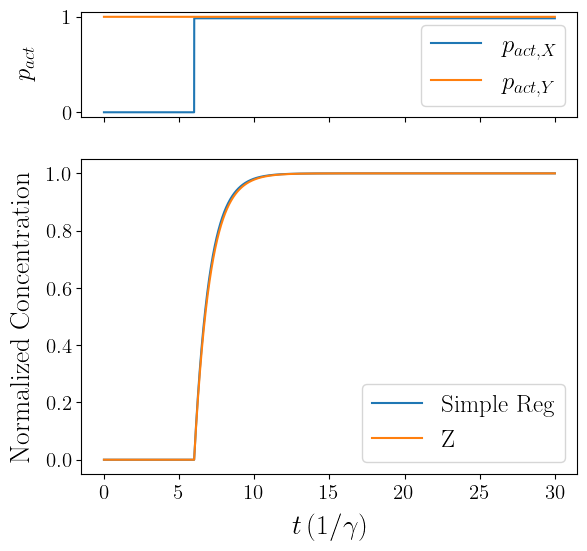

X 4.922838689147225 S 8.416358578526497 Yinf 2.493519889379272 delY -0.824071161047131
log -0.10304434332090533
inside log 0.9020869710625606
-0.012243340437491902


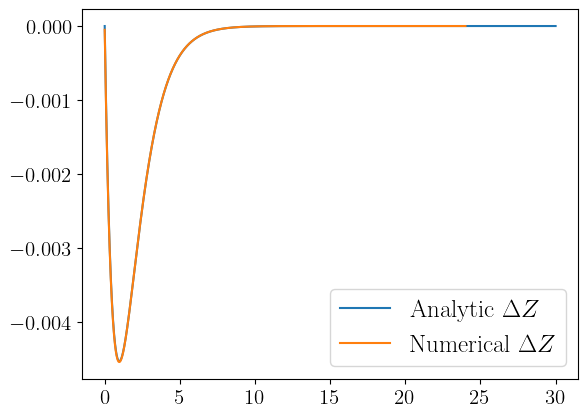

In [ ]:
nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

if False:
    rys = [0, 5]
    rzs = [1, 1, 5]
    w = 10
    Ks = [1, 0.5, 10]

# OR GATE PARAMETERS
if True:
    rys = [0, 2]
    rzs = [0, 2, 20]
    w = 0
    Ks = [1, 0.2, 0.6]

# defining how inducer concentration is tuned

empty = np.full(int(nstep/5), pAct(10**(-3)))
full = np.full(int(nstep/5), pAct(10**(-7)))

# Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
# Cys = np.full(nstep, 10**(-7))

pxs = np.concatenate((empty, full, full, full, full))
pys = np.full(nstep, 1)

X = 1
Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForward(X, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.zeros((nstep, 3))
X, Y = [1, 1]
Rps[0, :] = steadyStateSimpleReg(X, Y, rzs, w, pxs[0], pys[0], Ks)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
    Rps[i+1, :] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

yinit = Rs[0, 1]/Ks[2]
yinf = steadyStateFeedForward(X, rys, rzs, w, pAct(10**(-7)), pAct(10**(-7)), Ks)[1]/Ks[2]
delY = yinit - yinf

axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
# axs[0].set_yscale("log")
axs[0].legend()
axs[0].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, normalize(Rps[:, 2]), label=r"Simple Reg")
axs[1].plot(ts, normalize(Rs[:, 2]), label=r"Z")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()

# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\0826\fedFor7.pdf", format="pdf", bbox_inches="tight")
plt.show()

diff = diff_func(ts, rzs, w, pAct(10**(-7))*X/Ks[1], pAct(10**(-7))*delY, pAct(10**(-7))*yinf)

print(int_delta(rzs, w, pxs[-1]*X/Ks[1], delY, yinf))
num_diff = (Rs[:, 2] - (Rs[0, 2] * np.exp(-ts+6) + Rs[-1, 2] * (1 - np.exp(-ts+6))))
plt.plot(ts, diff, label=r"Analytic $\Delta Z$")
plt.plot(ts[6000:]-6, num_diff[6000:], label=r"Numerical $\Delta Z$")
plt.legend()
plt.show()

Now look at OFF step.

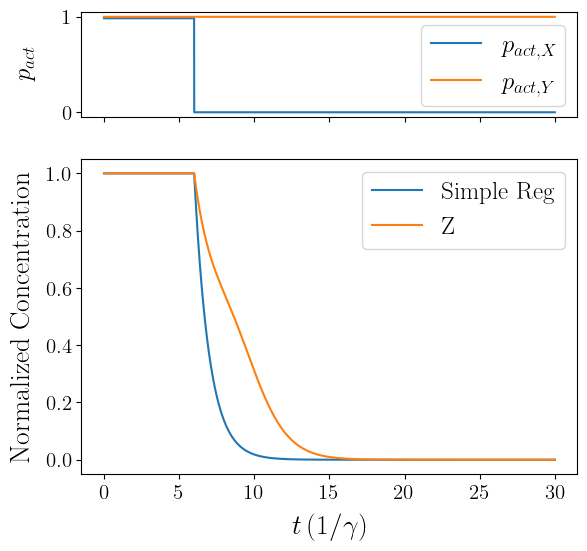

3.147457705074948


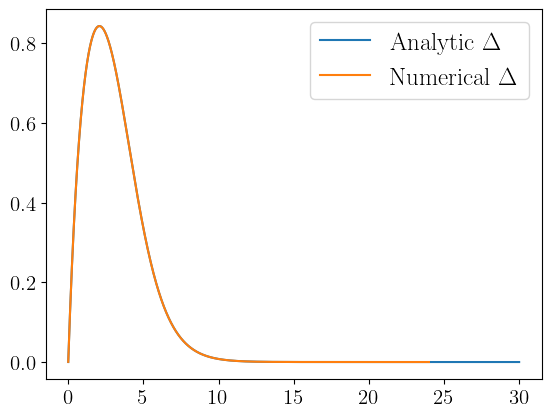

In [13]:
nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2]
rzs = [0, 0, 2]
w = 10

Ks = [1, 10**(-2), 10**(-1)]

# rys = [0, 5]
# rzs = [1, 1, 5]
# w = 10
# Ks = [1, 0.5, 10]

# Ks = [0.5, 0.1, 0.3]
# Ks = [1, 0.2, 0.6]
# defining how inducer concentration is tuned

empty = np.full(int(nstep/5), pAct(10**(-3)))
full = np.full(int(nstep/5), pAct(10**(-7)))

# Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
# Cys = np.full(nstep, 10**(-7))

pxs = np.concatenate((full, empty, empty, empty, empty))
pys = np.full(nstep, 1)

X = 1
Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForward(X, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.zeros((nstep, 3))
X, Y = [1, 1]
Rps[0, :] = steadyStateSimpleReg(X, Y, rzs, w, pxs[0], pys[0], Ks)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
    Rps[i+1, :] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

yinit = Rs[0, 1]/Ks[2]
yinf = steadyStateFeedForward(pxs[-1]*X, rys, rzs, w, 1, 1, Ks)[1]/Ks[2]
delY = yinit - yinf

axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
# axs[0].set_yscale("log")
axs[0].legend()
axs[0].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, normalize(Rps[:, 2]), label=r"Simple Reg")
axs[1].plot(ts, normalize(Rs[:, 2]), label=r"Z")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\0826\fedFor7.pdf", format="pdf", bbox_inches="tight")
plt.show()

diff = diff_func(ts, rzs, w, pxs[-1]*X/Ks[1], delY, yinf)
print(int_delta(rzs, w, pAct(-3)*X/Ks[1], delY, yinf))
num_diff = (Rs[:, 2] - (Rs[0, 2] * np.exp(-ts+6) + Rs[-1, 2] * (1 - np.exp(-ts+6))))
plt.plot(ts, diff, label=r"Analytic $\Delta$")
plt.plot(ts[6000:]-6, num_diff[6000:], label=r"Numerical $\Delta$")
plt.legend()
plt.show()

In [30]:
rys = [1, 2]
rzs = [1, 2, 20]
w = 0
Ks = [1, 0.2, 0.6]


print(off_divided_by_on(rzs, w, 1, pAct(10**(-7)), pAct(10**(-3)), Ks[1], Ks[2]))

0.2694162560090678
ON -0.018398056316341626
OFF 0.03672208303192074
-2.6020715570949853


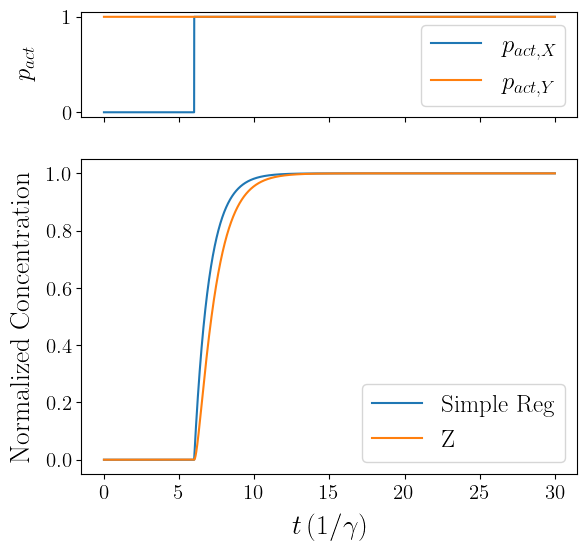

character -3.3333333333333335
character2 1.2121212121212122
character3 -0.8888888888888888


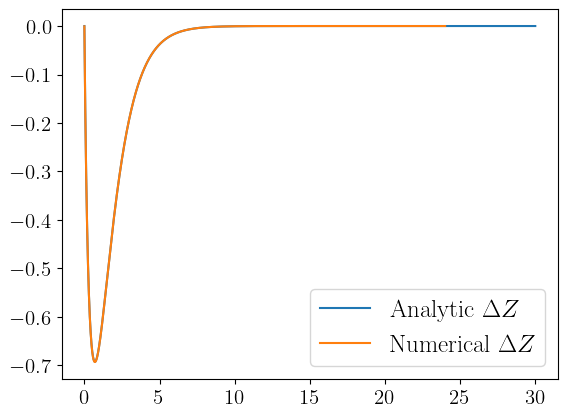

In [15]:
nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)
rys = [0, 1]
rzs = [0, 0, 5]
w = 10

Ks = [1, 1, 1]
# defining how inducer concentration is tuned

empty = np.full(int(nstep/5), 0)
full = np.full(int(nstep/5), 1)

# Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
# Cys = np.full(nstep, 10**(-7))

pxs = np.concatenate((empty, full, full, full, full))
pys = np.full(nstep, 1)

X = 1
Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForward(X, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.zeros((nstep, 3))
X, Y = [1, 1]
Rps[0, :] = steadyStateSimpleReg(X, Y, rzs, w, pxs[0], pys[0], Ks)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
    Rps[i+1, :] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

yinit = Rs[0, 1]/Ks[2]
yinf = steadyStateFeedForward(X, rys, rzs, w, 1, 1, Ks)[1]/Ks[2]
delY = yinit - yinf

axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
# axs[0].set_yscale("log")
axs[0].legend()
axs[0].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, normalize(Rps[:, 2]), label=r"Simple Reg")
axs[1].plot(ts, normalize(Rs[:, 2]), label=r"Z")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()

# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\0826\fedFor7.pdf", format="pdf", bbox_inches="tight")
plt.show()

diff = diff_func(ts, rzs, w, pxs[-1]*X/Ks[1], delY, yinf)
num_diff = (Rs[:, 2] - (Rs[0, 2] * np.exp(-ts+6) + Rs[-1, 2] * (1 - np.exp(-ts+6))))
plt.plot(ts, diff, label=r"Analytic $\Delta Z$")
plt.plot(ts[6000:]-6, num_diff[6000:], label=r"Numerical $\Delta Z$")
plt.legend()
plt.show()

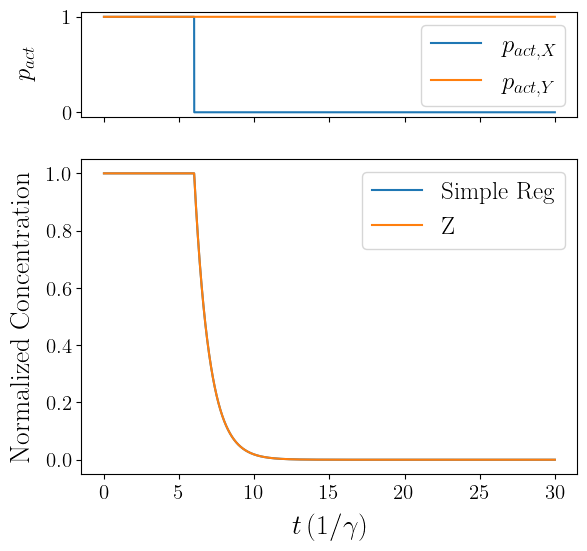

character 0.0
character2 0.0
character3 0.0


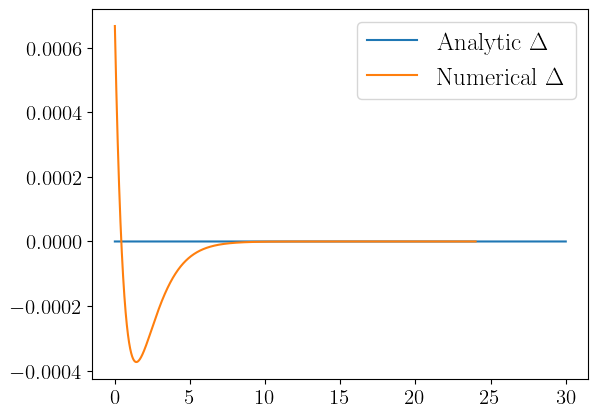

In [14]:
nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 1]
rzs = [0, 0, 5]
w = 10

Ks = [1, 1, 1]
# defining how inducer concentration is tuned

empty = np.full(int(nstep/5), 0)
full = np.full(int(nstep/5), 1)

# Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
# Cys = np.full(nstep, 10**(-7))

pxs = np.concatenate((full, empty, empty, empty, empty))
pys = np.full(nstep, 1)

X = 1
Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForward(X, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.zeros((nstep, 3))
X, Y = [1, 1]
Rps[0, :] = steadyStateSimpleReg(X, Y, rzs, w, pxs[0], pys[0], Ks)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
    Rps[i+1, :] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

yinit = Rs[0, 1]/Ks[2]
yinf = steadyStateFeedForward(pxs[-1]*X, rys, rzs, w, pxs[-1], pys[-1], Ks)[1]/Ks[2]
delY = yinit - yinf

axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
# axs[0].set_yscale("log")
axs[0].legend()
axs[0].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, normalize(Rps[:, 2]), label=r"Simple Reg")
axs[1].plot(ts, normalize(Rs[:, 2]), label=r"Z")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\0826\fedFor7.pdf", format="pdf", bbox_inches="tight")
plt.show()

diff = diff_func(ts, rzs, w, pxs[-1]*X/Ks[1], delY, yinf)
num_diff = (Rs[:, 2] - (Rs[0, 2] * np.exp(-ts+6) + Rs[-1, 2] * (1 - np.exp(-ts+6))))
plt.plot(ts, diff, label=r"Analytic $\Delta$")
plt.plot(ts[6000:]-6, num_diff[6000:], label=r"Numerical $\Delta$")
plt.legend()
plt.show()

After various checks, let's plot $\Delta (t)$ for ON and OFF steps

3.5


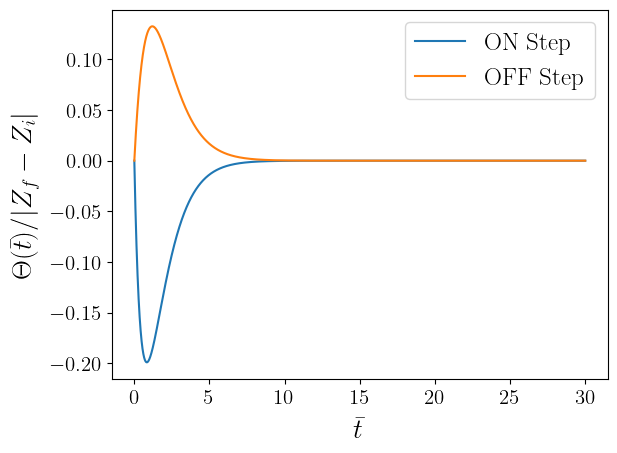

In [13]:
# OR gate

nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

if False:
    rys = [0, 2]
    rzs = [0, 2, 20]
    w = 0

    # Ks = [0.5, 0.1, 0.3]
    Ks = [1, 0.2, 0.6]

if True:
    rys = [0, 2]
    rzs = [0, 2, 10]
    w = 1

    Ks = [1, 1, 1]
# defining how inducer concentration is tuned

empty = np.full(int(nstep/5), pAct(10**(-4)))
full = np.full(int(nstep/5), pAct(10**(-7)))

# Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
# Cys = np.full(nstep, 10**(-7))

pxs = np.concatenate((full, empty, empty, empty, empty))
pys = np.full(nstep, pAct(10**(-7)))

X = 1

Ylow = steadyStateFeedForward(X, rys, rzs, w, 0, 1, Ks)[1]
Yhigh = steadyStateFeedForward(X, rys, rzs, w, 1, 1, Ks)[1]

Zlow = steadyStateFeedForward(X, rys, rzs, w, 0, 1, Ks)[2]
Zhigh = steadyStateFeedForward(X, rys, rzs, w, 1, 1, Ks)[2]

diffON = diff_func(ts, rzs, w, X/Ks[1], (Ylow - Yhigh)/Ks[2], Yhigh/Ks[2])
diffOFF = diff_func(ts, rzs, w, 0, (Yhigh - Ylow)/Ks[2], Ylow/Ks[2])

print(Zhigh - Zlow)
plt.plot(ts, diffON/(Zhigh - Zlow), label=r"ON Step")
plt.plot(ts, diffOFF/(Zhigh - Zlow), label=r"OFF Step")
plt.ylabel(r"$\Theta(\bar{t})/|Z_f - Z_i|$")
plt.xlabel(r"$\bar{t}$")
plt.legend()
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_fig21-3.svg", format="svg", bbox_inches="tight")
plt.show()

Now for AND gate.

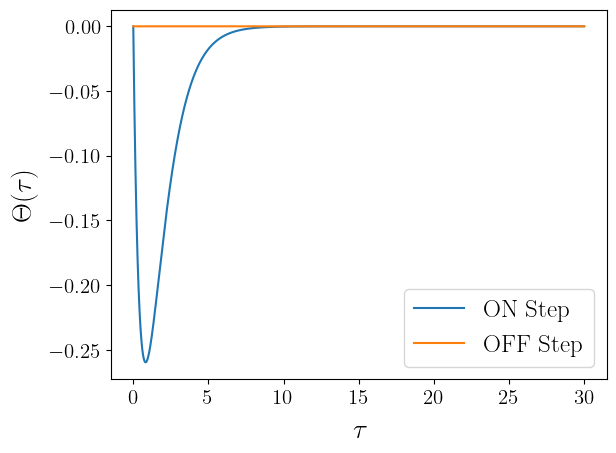

In [15]:
nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2]
rzs = [0, 0, 2]
w = 10

Ks = [1, 1, 5]

empty = np.full(int(nstep/5), 0)
full = np.full(int(nstep/5), 1)

# Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
# Cys = np.full(nstep, 10**(-7))

pxs = np.concatenate((full, empty, empty, empty, empty))
pys = np.full(nstep, 1)

X = 1

Ylow = steadyStateFeedForward(X, rys, rzs, w, 0, 1, Ks)[1]
Yhigh = steadyStateFeedForward(X, rys, rzs, w, 1, 1, Ks)[1]

diffON = diff_func(ts, rzs, w, X/Ks[1], (Ylow - Yhigh)/Ks[2], Yhigh/Ks[2])
diffOFF = diff_func(ts, rzs, w, 0, (Yhigh - Ylow)/Ks[2], Ylow/Ks[2])

plt.plot(ts, diffON, label=r"ON Step")
plt.plot(ts, diffOFF, label=r"OFF Step")
plt.ylabel(r"$\Theta(\tau)$")
plt.xlabel(r"$\tau$")
plt.legend()
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL4.svg", format="svg", bbox_inches="tight")
plt.show()

## Functional parameters, part II

### OR Gate

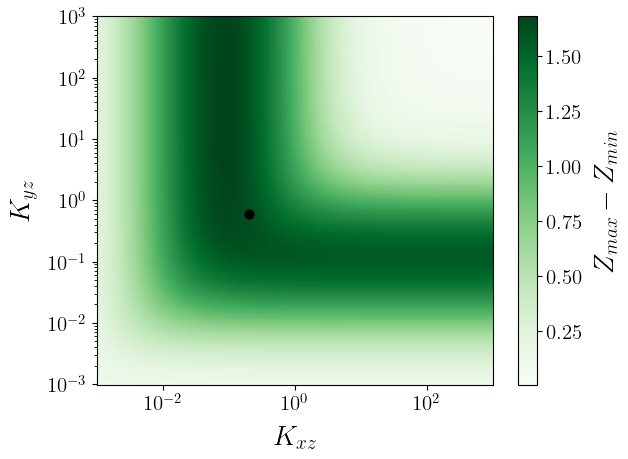

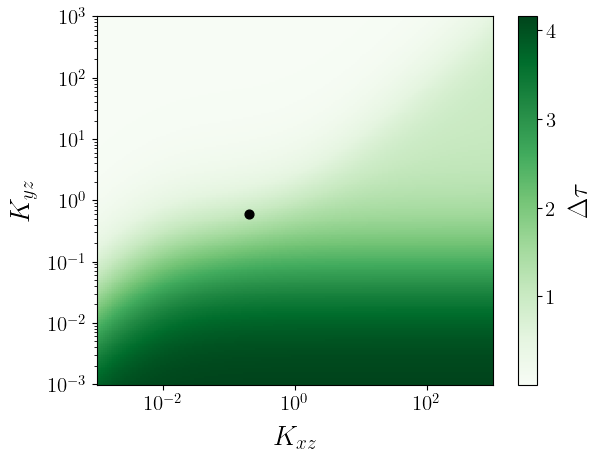

In [ ]:
X = 1

rys = [0, 2]
rzs = [0, 2, 0]
w = 0

length = 200

plow = pAct(10**(-4))
phigh = pAct(10**(-7))

# plow = 0
# phigh = 1

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

KX, KY = np.meshgrid(Kxzs, Kyzs)
KXY = np.full_like(KX, 1)
Ks = [KXY, KX, KY]

Xs = np.full_like(KX, X)

[_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
[_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

delta = int_delta(rzs, w, plow*X/KX, (highY - lowY)/KY, lowY/KY)

if False:
    delZ = (highZ - lowZ)/np.max(highZ - lowZ)
    fig, ax = plt.subplots()
    im = ax.pcolormesh(KX, KY, (highZ - lowZ), cmap="Greens", rasterized = True)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$K_{xz}$")
    ax.set_ylabel(r"$K_{yz}$")
    ax.scatter(0.2, 0.6, s = 40, c='black')
    cbar = plt.colorbar(im)
    cbar.set_label(r"$Z_{max} - Z_{min}$")
    # plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\ffl_delZ_1.svg", format="svg", bbox_inches="tight")
    plt.show()

if False:
    fig, ax = plt.subplots()
    im = ax.pcolormesh(KX, KY, delta/np.max(delta), cmap="Greens", rasterized = True)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$K_{xz}$")
    ax.set_ylabel(r"$K_{yz}$")
    ax.scatter(0.2, 0.6, s = 40,c='black')
    cbar = plt.colorbar(im)
    cbar.set_label(r"$\|\Delta\|$")
    # plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL6.svg", format="svg", bbox_inches="tight")
    plt.show()

timescale = delta/(highZ - lowZ)/np.max(delta/(highZ - lowZ))
fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, delta/(highZ - lowZ), cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
ax.scatter(0.2, 0.6, s = 40,c='black')
cbar = plt.colorbar(im)
cbar.set_label(r"$\Delta \tau$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_time_xor_off.svg", format="svg", bbox_inches="tight")
plt.show()

if False:
    delta_and_Z = timescale * delZ

    fig, ax = plt.subplots()
    im = ax.pcolormesh(KX, KY, delta_and_Z, cmap="Greens", rasterized = True, vmin=0, vmax=0.6)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$K_{xz}$")
    ax.set_ylabel(r"$K_{yz}$")
    ax.scatter(0.2, 0.6, s = 40, c='black')
    cbar = plt.colorbar(im)
    cbar.set_label(r"$\| \Theta \|$")
    # plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL7.svg", format="svg", bbox_inches="tight")
    plt.show()

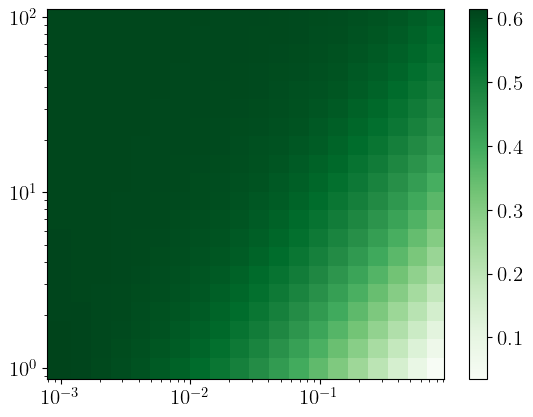

In [53]:
length = 20

w = 0
r0s = np.logspace(-3, -0.1, length)
r1s = np.logspace(0, 2, length)

R0s, R1s = np.meshgrid(r0s, r1s)
maxA = np.zeros_like(Rs)

for i in range(length):
    for j in range(length):

        rys = [R0s[i, j], R1s[i, j]]
        rzs = [R0s[i, j], R1s[i, j], 0]

        plow = pAct(10**(-4))
        phigh = pAct(10**(-7))

        # creating 2d mesh
        Kxzs = np.logspace(-3, 3, 200)
        Kyzs = np.logspace(-3, 3, 200)

        KX, KY = np.meshgrid(Kxzs, Kyzs)
        KXY = np.full_like(KX, 1)
        Ks = [KXY, KX, KY]

        Xs = np.full_like(KX, 1)

        [_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
        [_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

        # delta = np.abs(int_delta(rzs, w, phigh*1/KX, (lowY - highY)/KY, highY/KY))
        delta = int_delta(rzs, w, plow*1/KX, (highY - lowY)/KY, lowY/KY)
        delZ = (highZ - lowZ)/np.max(highZ - lowZ)
        timescale = delta/(highZ - lowZ)/np.max(delta/(highZ - lowZ))
        delta_and_Z = timescale * delZ

        maxA[i, j] = np.max(delta_and_Z)

fig, ax = plt.subplots()
im = ax.pcolormesh(R0s, R1s, maxA, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlabel(r"$K_{xz}$")
# ax.set_ylabel(r"$K_{yz}$")
cbar = plt.colorbar(im)
# cbar.set_label(r"$Z_{max} - Z_{min}$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL5.svg", format="svg", bbox_inches="tight")
plt.show()

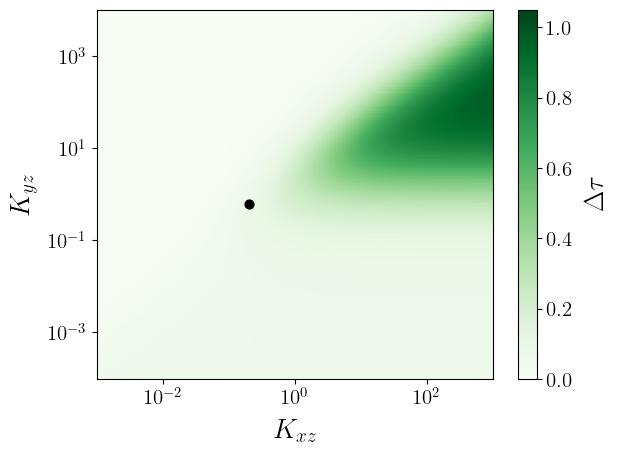

In [14]:
# ON step

rys = [0, 10]
rzs = [0, 10, 0]
w = 0

length = 200

plow = pAct(10**(-4))
phigh = pAct(10**(-7))

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-4, 4, length)

KX, KY = np.meshgrid(Kxzs, Kyzs)
KXY = np.full_like(KX, 1)
Ks = [KXY, KX, KY]

Xs = np.full_like(KX, 1)

[_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
[_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

delta = np.abs(int_delta(rzs, w, phigh*1/KX, (lowY - highY)/KY, highY/KY))

timescale = delta/(highZ - lowZ)
fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, timescale, cmap="Greens", rasterized = True, vmin=0, vmax=1.05)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
ax.scatter(0.2, 0.6, s = 40, c="black")
cbar = plt.colorbar(im)
cbar.set_label(r"$\Delta \tau$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_time_xor_on.svg", format="svg", bbox_inches="tight")
plt.show()

### AND Gate

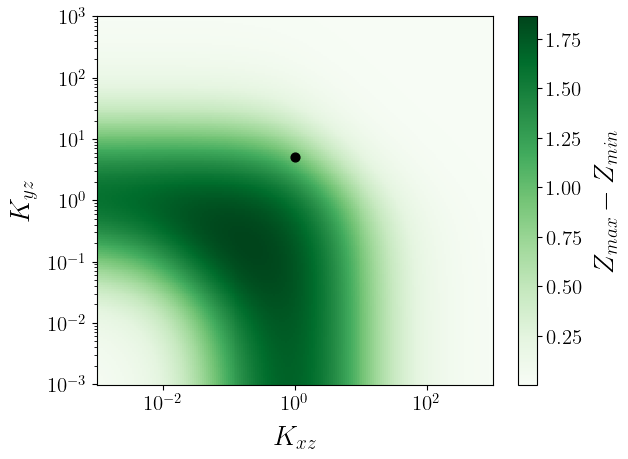

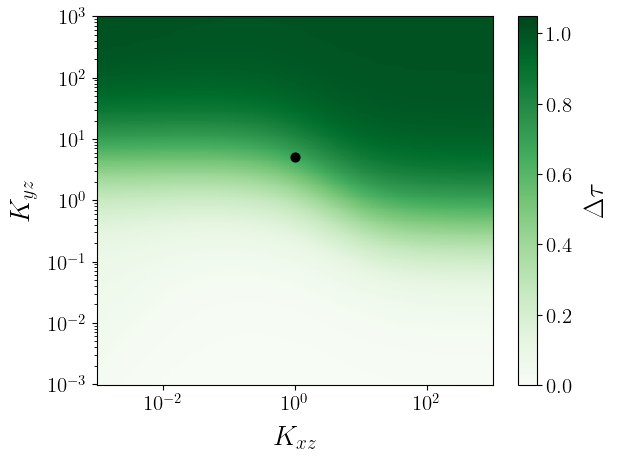

In [17]:
rys = [0, 2]
rzs = [0, 0, 2]
w = 10

length = 200

plow = pAct(10**(-4))
phigh = pAct(10**(-7))

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

KX, KY = np.meshgrid(Kxzs, Kyzs)
KXY = np.full_like(KX, 1)
Ks = [KXY, KX, KY]

Xs = np.full_like(KX, 1)

[_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
[_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

delta = np.abs(int_delta(rzs, w, phigh*1/KX, (lowY - highY)/KY, highY/KY))

if True:
    delZ = (highZ - lowZ)/np.max(highZ - lowZ)
    fig, ax = plt.subplots()
    im = ax.pcolormesh(KX, KY, highZ - lowZ, cmap="Greens", rasterized = True)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$K_{xz}$")
    ax.set_ylabel(r"$K_{yz}$")
    ax.scatter(1, 5, s = 40, c="black")
    cbar = plt.colorbar(im)
    cbar.set_label(r"$Z_{max} - Z_{min}$")
    plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\ffl_delZ_2.svg", format="svg", bbox_inches="tight")
    plt.show()

timescale = delta/(highZ - lowZ)
fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, timescale, cmap="Greens", rasterized = True, vmin=0, vmax=1.05)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
ax.scatter(1, 5, s = 40, c="black")
cbar = plt.colorbar(im)
cbar.set_label(r"$\Delta \tau$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_time_and_on.svg", format="svg", bbox_inches="tight")
plt.show()


if False:
    delta_and_Z = timescale * delZ

    fig, ax = plt.subplots()
    im = ax.pcolormesh(KX, KY, delta_and_Z, cmap="Greens", rasterized = True, vmin=0, vmax=0.6)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$K_{xz}$")
    ax.set_ylabel(r"$K_{yz}$")
    ax.scatter(1, 5, s = 40, c="black")
    cbar = plt.colorbar(im)
    cbar.set_label(r"$\|\Theta\|$")
    # plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL8.svg", format="svg", bbox_inches="tight")
    plt.show()

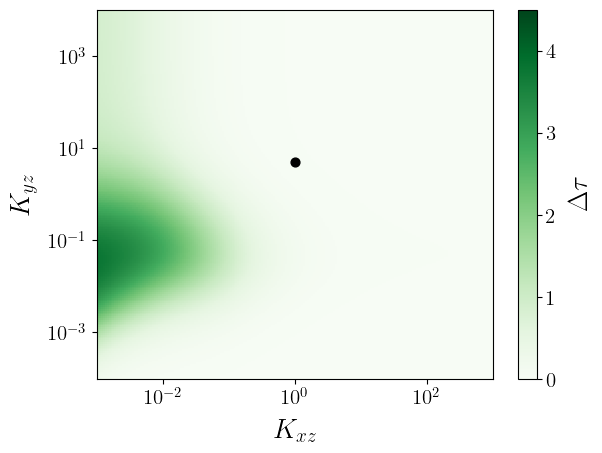

In [ ]:
# OFF step, AND gate

rys = [0, 2]
rzs = [0, 0, 2]
w = 10

length = 200

plow = pAct(10**(-4))
phigh = pAct(10**(-7))

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-4, 4, length)

KX, KY = np.meshgrid(Kxzs, Kyzs)
KXY = np.full_like(KX, 1)
Ks = [KXY, KX, KY]

Xs = np.full_like(KX, 1)

[_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
[_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

delta = int_delta(rzs, w, plow*1/KX, (highY - lowY)/KY, lowY/KY)

timescale = delta/(highZ - lowZ)/np.max(delta/(highZ - lowZ))
fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, delta/(highZ - lowZ), cmap="Greens", rasterized = True, vmin=0, vmax=4.5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
ax.scatter(1, 5, s = 40,c='black')
cbar = plt.colorbar(im)
cbar.set_label(r"$\Delta \tau$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_time_and_off.svg", format="svg", bbox_inches="tight")
plt.show()

let's try to find the best rate and cooperativity parameters

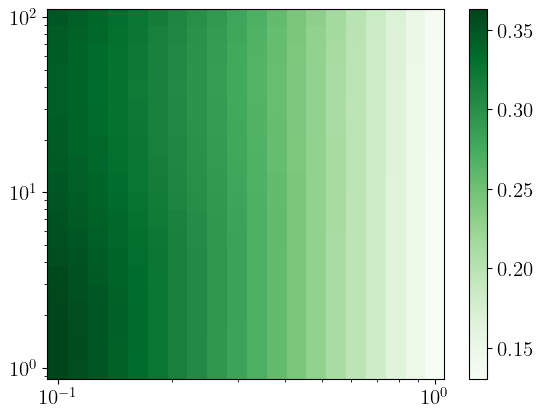

In [55]:
length = 20

if False:
    rs = np.logspace(-1, 2, length)
    ws = np.logspace(0, 2, length)
    Rs, Ws = np.meshgrid(rs, ws)
rs = np.logspace(-1, 0, length)
ws = np.logspace(0, 2, length)
Rs, Ws = np.meshgrid(rs, ws)

maxA = np.zeros_like(Rs)

for i in range(length):
    for j in range(length):

        rys = [Rs[i, j], 2]
        rzs = [Rs[i, j], Rs[i, j], 2]
        w = Ws[i, j]

        plow = pAct(10**(-4))
        phigh = pAct(10**(-7))

        # creating 2d mesh
        Kxzs = np.logspace(-3, 3, 200)
        Kyzs = np.logspace(-3, 3, 200)

        KX, KY = np.meshgrid(Kxzs, Kyzs)
        KXY = np.full_like(KX, 1)
        Ks = [KXY, KX, KY]

        Xs = np.full_like(KX, 1)

        [_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
        [_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

        delta = np.abs(int_delta(rzs, w, phigh*1/KX, (lowY - highY)/KY, highY/KY))

        delZ = (highZ - lowZ)/np.max(highZ - lowZ)
        timescale = delta/(highZ - lowZ)/np.max(delta/(highZ - lowZ))
        delta_and_Z = timescale * delZ

        maxA[i, j] = np.max(delta_and_Z)

fig, ax = plt.subplots()
im = ax.pcolormesh(Rs, Ws, maxA, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlabel(r"$K_{xz}$")
# ax.set_ylabel(r"$K_{yz}$")
cbar = plt.colorbar(im)
# cbar.set_label(r"$Z_{max} - Z_{min}$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL5.svg", format="svg", bbox_inches="tight")
plt.show()

### Mixed Gates

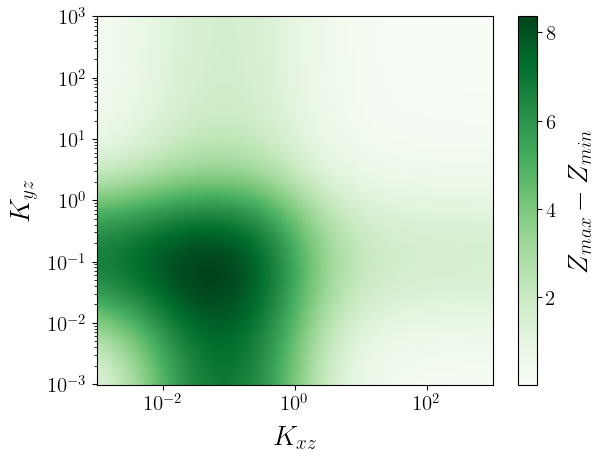

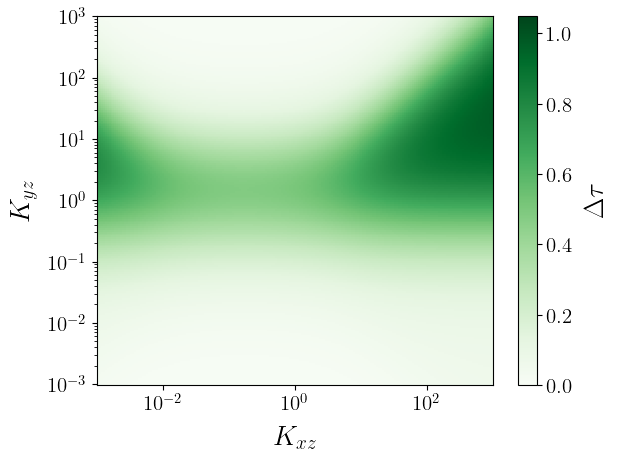

In [21]:
# ON STEP

rys = [0, 2]
rzs = [0, 2, 10]
w = 1

length = 200

plow = pAct(10**(-4))
phigh = pAct(10**(-7))

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

KX, KY = np.meshgrid(Kxzs, Kyzs)
KXY = np.full_like(KX, 1)
Ks = [KXY, KX, KY]

Xs = np.full_like(KX, 1)

[_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
[_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

delta = np.abs(int_delta(rzs, w, phigh*1/KX, (lowY - highY)/KY, highY/KY))

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, highZ - lowZ, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
# ax.scatter(1, 5, s = 40, c="black")
cbar = plt.colorbar(im)
cbar.set_label(r"$Z_{max} - Z_{min}$")
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\ffl_delZ_3.svg", format="svg", bbox_inches="tight")
plt.show()


timescale = delta/(highZ - lowZ)
fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, timescale, cmap="Greens", rasterized = True, vmin=0, vmax=1.05)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
# ax.scatter(1, 5, s = 40, c="black")
cbar = plt.colorbar(im)
cbar.set_label(r"$\Delta \tau$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_time_or_on.svg", format="svg", bbox_inches="tight")
plt.show()


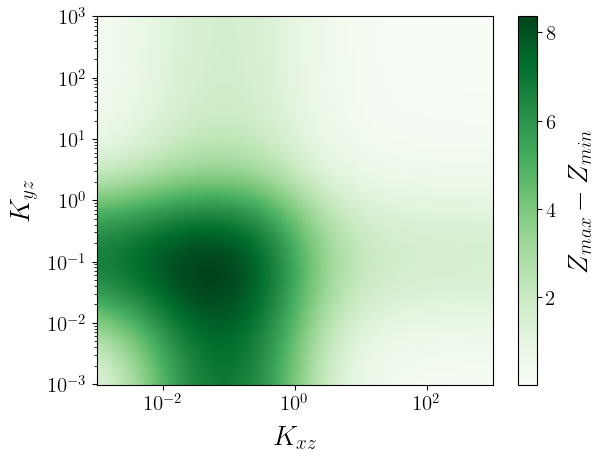

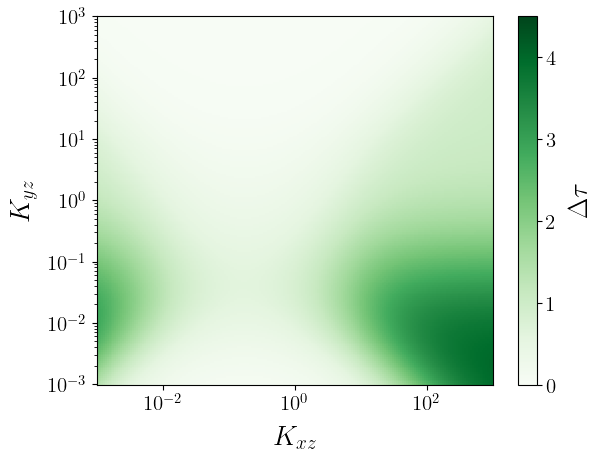

In [22]:
# OFF Step
rys = [0, 2]
rzs = [0, 2, 10]
w = 1

length = 200

plow = pAct(10**(-4))
phigh = pAct(10**(-7))

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

KX, KY = np.meshgrid(Kxzs, Kyzs)
KXY = np.full_like(KX, 1)
Ks = [KXY, KX, KY]

Xs = np.full_like(KX, 1)

[_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
[_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

delta = int_delta(rzs, w, plow*1/KX, (highY - lowY)/KY, lowY/KY)

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, highZ - lowZ, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
# ax.scatter(1, 5, s = 40, c="black")
cbar = plt.colorbar(im)
cbar.set_label(r"$Z_{max} - Z_{min}$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\ffl_delZ_3.svg", format="svg", bbox_inches="tight")
plt.show()


timescale = delta/(highZ - lowZ)
fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, timescale, cmap="Greens", rasterized = True, vmin=0, vmax=4.5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
cbar = plt.colorbar(im)
cbar.set_label(r"$\Delta \tau$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_time_or_off.svg", format="svg", bbox_inches="tight")
plt.show()

## Functional parameters, part III

What about other parameters? Let's try to do hypersweeps. The entire set of tunable parameters are $r_{iZ}, r_{iY}, \omega, K_{XZ}, K_{YZ}, X, p_{max}, p_{min}$.

Let's define a default set: $r_{0Z} = r_{0Y} = 0, r_{1Z} = r_{1Y} = 1, r_{2Z} = 5, \omega = 5, X=1, p_{max}=our_normal_amount, p_{min}=our_normal_amount$.

Let's sweep across 5 parameters. $r_0, r_1, r_2, \omega, X$


In [102]:
def z_to_time(z, z0, zinf):

    return np.log((z0 - zinf)/(z - zinf))

def steadyStateFeedForwardYWeight(X, rys, rzs, w, px, py, Ks):
    
    Kxy, Kxz, Kyz = Ks

    Y = (rys[0] + rys[1]*px*X/Kxy)/(1 + px*X/Kxy)
    Yweight = (py*Y/Kyz + w*px*X/Kxz*py*Y/Kyz)/(1 + px*X/Kxz + py*Y/Kyz + w*px*X/Kxz*py*Y/Kyz)

    return Yweight

OFF step sweeps

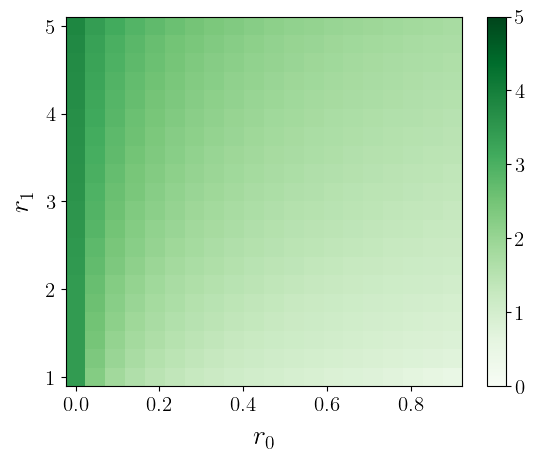

3.8427713091417752


In [123]:
# r0, r1

length = 20

w = 5
r0s = np.linspace(0, 0.9, length)
r1s = np.linspace(1, 5, length)

R0s, R1s = np.meshgrid(r0s, r1s)
max_delt = np.zeros_like(R0s)
for i in range(length):
    for j in range(length):

        rys = [R0s[i, j], R1s[i, j]]
        rzs = [R0s[i, j], R1s[i, j], 5]

        plow = pAct(10**(-4))
        phigh = pAct(10**(-7))

        # creating 2d mesh
        Kxzs = np.logspace(-3, 3, 100)
        Kyzs = np.logspace(-3, 3, 100)

        KX, KY = np.meshgrid(Kxzs, Kyzs)
        KXY = np.full_like(KX, 1)
        Ks = [KXY, KX, KY]

        Xs = np.full_like(KX, 2)

        [_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
        [_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

        # delta = np.abs(int_delta(rzs, w, phigh*1/KX, (lowY - highY)/KY, highY/KY))
        delta = np.abs(int_delta(rzs, w, plow*Xs[i, j]/KX, (highY - lowY)/KY, lowY/KY))
        timescale = delta/(highZ - lowZ)

        max_delt[i, j] = np.max(timescale)

fig, ax = plt.subplots()
im = ax.pcolormesh(R0s, R1s, max_delt, cmap="Greens", rasterized = True, vmin=0, vmax=5)
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel(r"$r_0$")
ax.set_ylabel(r"$r_1$")
cbar = plt.colorbar(im)
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\ffl_r0_r1.svg", format="svg", bbox_inches="tight")
plt.show()
print(np.max(max_delt))

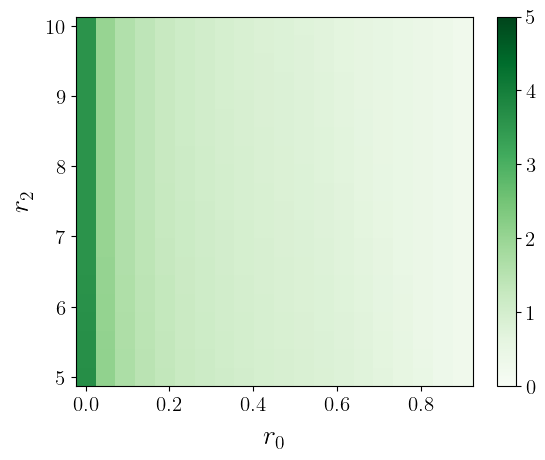

In [124]:
# r0, r2

length = 20

w = 5
r0s = np.linspace(0, 0.9, length)
r2s = np.linspace(5, 10, length)

R0s, R2s = np.meshgrid(r0s, r2s)
max_delt = np.zeros_like(R0s)
for i in range(length):
    for j in range(length):

        rys = [R0s[i, j], 1]
        rzs = [R0s[i, j], 1, R2s[i,j]]

        plow = pAct(10**(-4))
        phigh = pAct(10**(-7))

        # creating 2d mesh
        Kxzs = np.logspace(-3, 3, 100)
        Kyzs = np.logspace(-3, 3, 100)

        KX, KY = np.meshgrid(Kxzs, Kyzs)
        KXY = np.full_like(KX, 1)
        Ks = [KXY, KX, KY]

        Xs = np.full_like(KX, 1)

        [_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
        [_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

        # delta = np.abs(int_delta(rzs, w, phigh*1/KX, (lowY - highY)/KY, highY/KY))
        delta = np.abs(int_delta(rzs, w, plow*1/KX, (highY - lowY)/KY, lowY/KY))
        timescale = delta/(highZ - lowZ)

        max_delt[i, j] = np.max(timescale)

fig, ax = plt.subplots()
im = ax.pcolormesh(R0s, R2s, max_delt, cmap="Greens", rasterized = True, vmin=0, vmax=5)
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel(r"$r_0$")
ax.set_ylabel(r"$r_2$")
cbar = plt.colorbar(im)
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\ffl_r0_r2.svg", format="svg", bbox_inches="tight")
plt.show()

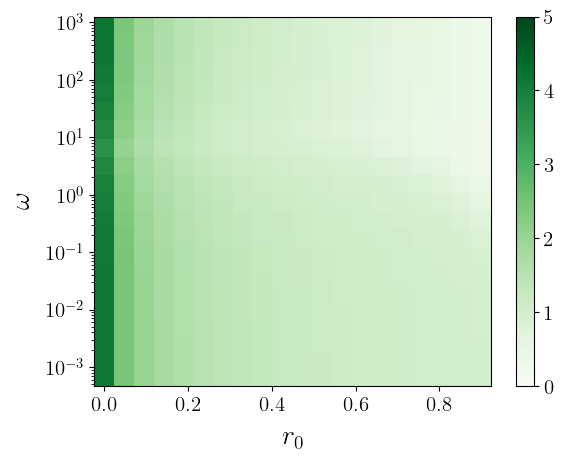

4.169796003054271


In [121]:
# r0, omega

length = 20

r0s = np.linspace(0, 0.9, length)
ws = np.logspace(-3, 3, length)

R0s, Ws = np.meshgrid(r0s, ws)
max_delt = np.zeros_like(R0s)
for i in range(length):
    for j in range(length):

        w = Ws[i, j]
        rys = [R0s[i, j], 1]
        rzs = [R0s[i, j], 1, 5]

        plow = pAct(10**(-4))
        phigh = pAct(10**(-7))

        # plow = 0
        # phigh = 1

        # creating 2d mesh
        Kxzs = np.logspace(-3, 3, 100)
        Kyzs = np.logspace(-3, 3, 100)

        KX, KY = np.meshgrid(Kxzs, Kyzs)
        KXY = np.full_like(KX, 1)
        Ks = [KXY, KX, KY]

        Xs = np.full_like(KX, 1)

        [_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
        [_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

        # delta = np.abs(int_delta(rzs, w, phigh*1/KX, (lowY - highY)/KY, highY/KY))
        delta = np.abs(int_delta(rzs, w, plow*1/KX, (highY - lowY)/KY, lowY/KY))
        timescale = delta/(highZ - lowZ)

        max_delt[i, j] = np.max(timescale)

fig, ax = plt.subplots()
im = ax.pcolormesh(R0s, Ws, max_delt, cmap="Greens", rasterized = True, vmin=0, vmax=5)
# ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$r_0$")
ax.set_ylabel(r"$\omega$")
cbar = plt.colorbar(im)
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\ffl_r0_w.svg", format="svg", bbox_inches="tight")
plt.show()
print(np.max(max_delt))

4.13382448429449


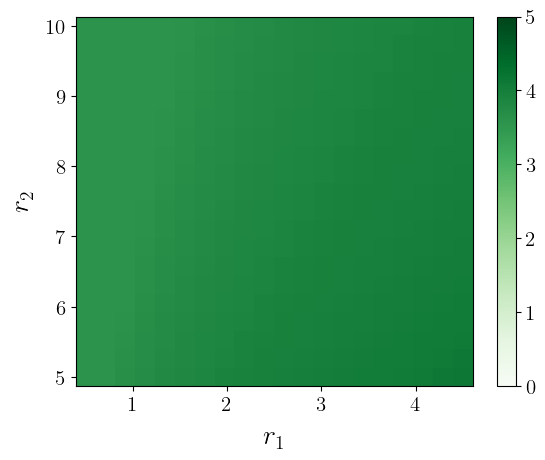

In [125]:
# r1, r2
length = 20

w = 5
r1s = np.linspace(0.5, 4.5, length)
r2s = np.linspace(5, 10, length)

R1s, R2s = np.meshgrid(r1s, r2s)
max_delt = np.zeros_like(R1s)
for i in range(length):
    for j in range(length):

        rys = [0, R1s[i,j]]
        rzs = [0, R1s[i,j], R2s[i,j]]

        plow = pAct(10**(-4))
        phigh = pAct(10**(-7))

        # creating 2d mesh
        Kxzs = np.logspace(-3, 3, 100)
        Kyzs = np.logspace(-3, 3, 100)

        KX, KY = np.meshgrid(Kxzs, Kyzs)
        KXY = np.full_like(KX, 1)
        Ks = [KXY, KX, KY]

        Xs = np.full_like(KX, 1)

        [_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
        [_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

        # delta = np.abs(int_delta(rzs, w, phigh*1/KX, (lowY - highY)/KY, highY/KY))
        delta = np.abs(int_delta(rzs, w, plow*1/KX, (highY - lowY)/KY, lowY/KY))
        timescale = delta/(highZ - lowZ)

        max_delt[i, j] = np.max(timescale)

fig, ax = plt.subplots()
im = ax.pcolormesh(R1s, R2s, max_delt, cmap="Greens", rasterized = True, vmin=0, vmax=5)
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel(r"$r_1$")
ax.set_ylabel(r"$r_2$")
cbar = plt.colorbar(im)
print(np.max(max_delt))
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\ffl_r1_r2.svg", format="svg", bbox_inches="tight")
plt.show()

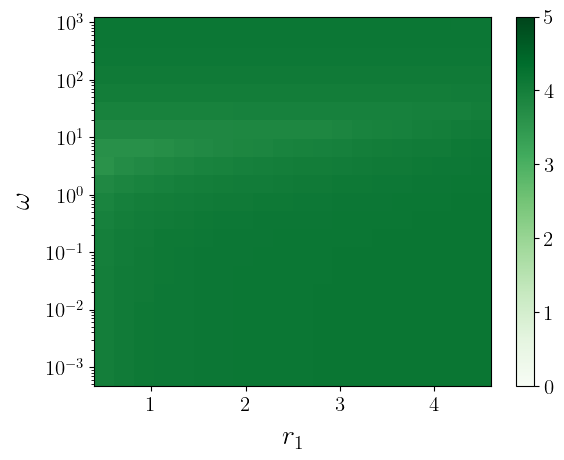

4.196891837273238


In [119]:
# rq, omega

X = 1

length = 20

r1s = np.linspace(0.5, 4.5, length)
ws = np.logspace(-3, 3, length)

R1s, Ws = np.meshgrid(r1s, ws)
max_delt = np.zeros_like(R1s)
for i in range(length):
    for j in range(length):

        w = Ws[i, j]
        rys = [0, R1s[i, j]]
        rzs = [0, R1s[i, j], 5]

        plow = pAct(10**(-4))
        phigh = pAct(10**(-7))

        # creating 2d mesh
        Kxzs = np.logspace(-3, 3, 100)
        Kyzs = np.logspace(-3, 3, 100)

        KX, KY = np.meshgrid(Kxzs, Kyzs)
        KXY = np.full_like(KX, 1)
        Ks = [KXY, KX, KY]

        Xs = np.full_like(KX, X)

        [_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
        [_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

        # delta = np.abs(int_delta(rzs, w, phigh*1/KX, (lowY - highY)/KY, highY/KY))
        delta = np.abs(int_delta(rzs, w, plow*X/KX, (highY - lowY)/KY, lowY/KY))
        timescale = delta/(highZ - lowZ)

        max_delt[i, j] = np.max(timescale)

fig, ax = plt.subplots()
im = ax.pcolormesh(R1s, Ws, max_delt, cmap="Greens", rasterized = True, vmin=0, vmax=5)
# ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$r_1$")
ax.set_ylabel(r"$\omega$")
cbar = plt.colorbar(im)
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\ffl_r1_w.svg", format="svg", bbox_inches="tight")
plt.show()

print(np.max(max_delt))

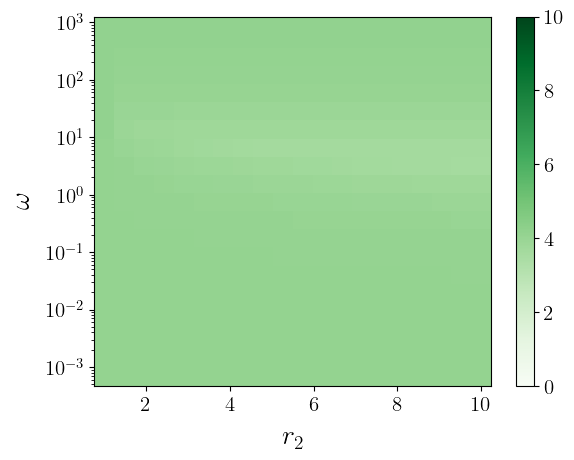

4.1703295849119275


In [110]:
# r2, omega

length = 20

r2s = np.linspace(1, 10, length)
ws = np.logspace(-3, 3, length)

R2s, Ws = np.meshgrid(r2s, ws)
max_delt = np.zeros_like(R2s)
for i in range(length):
    for j in range(length):

        w = Ws[i, j]
        rys = [0, 1]
        rzs = [0, 1, R2s[i, j]]

        plow = pAct(10**(-4))
        phigh = pAct(10**(-7))

        # creating 2d mesh
        Kxzs = np.logspace(-3, 3, 100)
        Kyzs = np.logspace(-3, 3, 100)

        KX, KY = np.meshgrid(Kxzs, Kyzs)
        KXY = np.full_like(KX, 1)
        Ks = [KXY, KX, KY]

        Xs = np.full_like(KX, 1)

        [_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
        [_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

        # delta = np.abs(int_delta(rzs, w, phigh*1/KX, (lowY - highY)/KY, highY/KY))
        delta = np.abs(int_delta(rzs, w, plow*1/KX, (highY - lowY)/KY, lowY/KY))
        timescale = delta/(highZ - lowZ)

        max_delt[i, j] = np.max(timescale)

fig, ax = plt.subplots()
im = ax.pcolormesh(R2s, Ws, max_delt, cmap="Greens", rasterized = True, vmin=0, vmax=10)
# ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$r_2$")
ax.set_ylabel(r"$\omega$")
cbar = plt.colorbar(im)
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\ffl_r2_w.svg", format="svg", bbox_inches="tight")
plt.show()

print(np.max(max_delt))

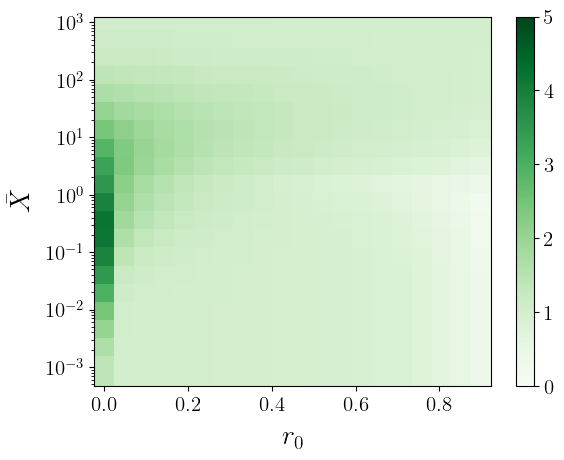

4.20020116029027


In [113]:
# r0, X

length = 20

r0s = np.linspace(0, 0.9, length)
xs = np.logspace(-3, 3, length)

w = 5

R0s, Xss = np.meshgrid(r0s, xs)
max_delt = np.zeros_like(R0s)
for i in range(length):
    for j in range(length):

        X = Xss[i, j]
        rys = [R0s[i, j], 1]
        rzs = [R0s[i, j], 1, 5]

        plow = pAct(10**(-4))
        phigh = pAct(10**(-7))

        # creating 2d mesh
        Kxzs = np.logspace(-3, 3, 100)
        Kyzs = np.logspace(-3, 3, 100)

        KX, KY = np.meshgrid(Kxzs, Kyzs)
        KXY = np.full_like(KX, 1)
        Ks = [KXY, KX, KY]

        Xs = np.full_like(KX, X)

        [_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
        [_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

        # delta = np.abs(int_delta(rzs, w, phigh*1/KX, (lowY - highY)/KY, highY/KY))
        delta = np.abs(int_delta(rzs, w, plow*X/KX, (highY - lowY)/KY, lowY/KY))
        timescale = delta/(highZ - lowZ)

        max_delt[i, j] = np.max(timescale)

fig, ax = plt.subplots()
im = ax.pcolormesh(R0s, Xss, max_delt, cmap="Greens", rasterized = True, vmin=0, vmax=5)
# ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$r_0$")
ax.set_ylabel(r"$\bar{X}$")
cbar = plt.colorbar(im)
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\ffl_r0_X.svg", format="svg", bbox_inches="tight")
plt.show()

print(np.max(max_delt))

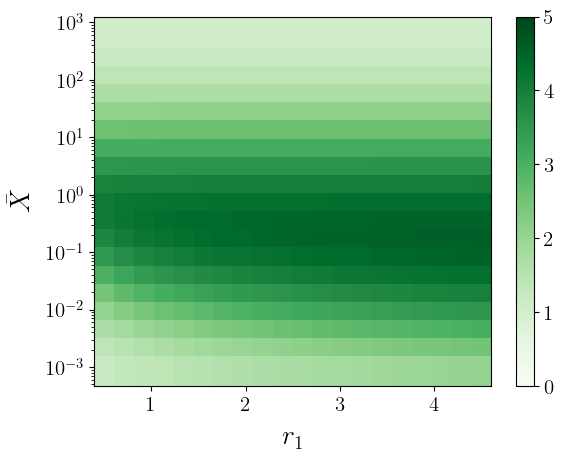

4.574000373987834


In [115]:
# r1, X

length = 20

r1s = np.linspace(0.5, 4.5, length)
xs = np.logspace(-3, 3, length)

w = 0

R1s, Xss = np.meshgrid(r1s, xs)
max_delt = np.zeros_like(R1s)
for i in range(length):
    for j in range(length):

        X = Xss[i, j]
        rys = [0, R1s[i, j]]
        rzs = [0, R1s[i, j], 5]

        plow = pAct(10**(-4))
        phigh = pAct(10**(-7))

        # creating 2d mesh
        Kxzs = np.logspace(-3, 3, 100)
        Kyzs = np.logspace(-3, 3, 100)

        KX, KY = np.meshgrid(Kxzs, Kyzs)
        KXY = np.full_like(KX, 1)
        Ks = [KXY, KX, KY]

        Xs = np.full_like(KX, X)

        [_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
        [_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

        # delta = np.abs(int_delta(rzs, w, phigh*1/KX, (lowY - highY)/KY, highY/KY))
        delta = np.abs(int_delta(rzs, w, plow*X/KX, (highY - lowY)/KY, lowY/KY))
        timescale = delta/(highZ - lowZ)

        max_delt[i, j] = np.max(timescale)

fig, ax = plt.subplots()
im = ax.pcolormesh(R1s, Xss, max_delt, cmap="Greens", rasterized = True, vmin=0, vmax=5)
# ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$r_1$")
ax.set_ylabel(r"$\bar{X}$")
cbar = plt.colorbar(im)
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\ffl_r1_X.svg", format="svg", bbox_inches="tight")
plt.show()

print(np.max(max_delt))

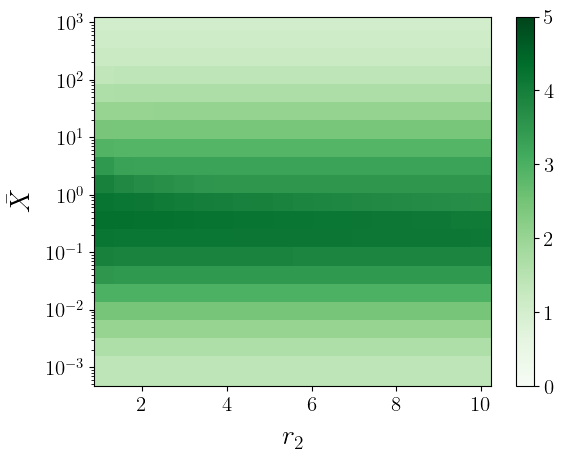

4.2925677241968945


In [111]:
# r2, X

length = 20

r2s = np.linspace(1.1, 10, length)
xs = np.logspace(-3, 3, length)

w = 5

R2s, Xss = np.meshgrid(r2s, xs)
max_delt = np.zeros_like(R0s)
for i in range(length):
    for j in range(length):

        X = Xss[i, j]
        rys = [0, 1]
        rzs = [0, 1, R2s[i,j]]

        plow = pAct(10**(-4))
        phigh = pAct(10**(-7))

        # creating 2d mesh
        Kxzs = np.logspace(-3, 3, 100)
        Kyzs = np.logspace(-3, 3, 100)

        KX, KY = np.meshgrid(Kxzs, Kyzs)
        KXY = np.full_like(KX, 1)
        Ks = [KXY, KX, KY]

        Xs = np.full_like(KX, X)

        [_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
        [_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

        # delta = np.abs(int_delta(rzs, w, phigh*1/KX, (lowY - highY)/KY, highY/KY))
        delta = np.abs(int_delta(rzs, w, plow*X/KX, (highY - lowY)/KY, lowY/KY))
        timescale = delta/(highZ - lowZ)

        max_delt[i, j] = np.max(timescale)

fig, ax = plt.subplots()
im = ax.pcolormesh(R2s, Xss, max_delt, cmap="Greens", rasterized = True, vmin=0, vmax=5)
# ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$r_2$")
ax.set_ylabel(r"$\bar{X}$")
cbar = plt.colorbar(im)
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\ffl_r2_X.svg", format="svg", bbox_inches="tight")
plt.show()

print(np.max(max_delt))

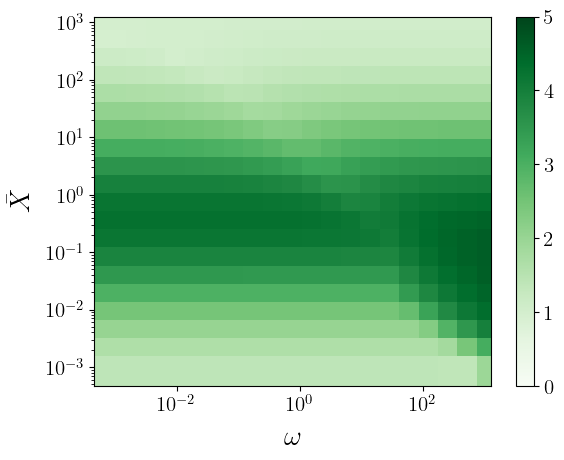

4.608557009923977


In [110]:
# w, X

length = 20

ws = np.logspace(-3, 3, length)
xs = np.logspace(-3, 3, length)


Ws, Xss = np.meshgrid(ws, xs)
max_delt = np.zeros_like(R0s)
for i in range(length):
    for j in range(length):

        w = Ws[i, j]
        X = Xss[i, j]
        rys = [0, 1]
        rzs = [0, 1, 5]

        plow = pAct(10**(-4))
        phigh = pAct(10**(-7))

        # creating 2d mesh
        Kxzs = np.logspace(-3, 3, 100)
        Kyzs = np.logspace(-3, 3, 100)

        KX, KY = np.meshgrid(Kxzs, Kyzs)
        KXY = np.full_like(KX, 1)
        Ks = [KXY, KX, KY]

        Xs = np.full_like(KX, X)

        [_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
        [_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

        # delta = np.abs(int_delta(rzs, w, phigh*1/KX, (lowY - highY)/KY, highY/KY))
        delta = np.abs(int_delta(rzs, w, plow*X/KX, (highY - lowY)/KY, lowY/KY))
        timescale = delta/(highZ - lowZ)

        max_delt[i, j] = np.max(timescale)

fig, ax = plt.subplots()
im = ax.pcolormesh(Ws, Xss, max_delt, cmap="Greens", rasterized = True, vmin=0, vmax=5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\omega$")
ax.set_ylabel(r"$\bar{X}$")
cbar = plt.colorbar(im)
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\ffl_w_X.svg", format="svg", bbox_inches="tight")
plt.show()

print(np.max(max_delt))

### OR Gate

Besides the $K$s, we can tune $r_{0G}, r_{1G}$

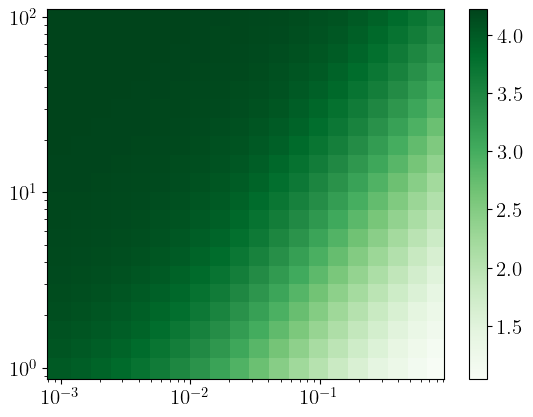

In [ ]:
length = 20

w = 0
r0s = np.logspace(-3, -0.1, length)
r1s = np.logspace(0, 2, length)

R0s, R1s = np.meshgrid(r0s, r1s)
max_delt = np.zeros_like(R0s)
for i in range(length):
    for j in range(length):

        rys = [R0s[i, j], R1s[i, j]]
        rzs = [R0s[i, j], R1s[i, j], 0]

        plow = pAct(10**(-4))
        phigh = pAct(10**(-7))

        # creating 2d mesh
        Kxzs = np.logspace(-3, 3, 100)
        Kyzs = np.logspace(-3, 3, 100)

        KX, KY = np.meshgrid(Kxzs, Kyzs)
        KXY = np.full_like(KX, 1)
        Ks = [KXY, KX, KY]

        Xs = np.full_like(KX, 1)

        [_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
        [_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

        # delta = np.abs(int_delta(rzs, w, phigh*1/KX, (lowY - highY)/KY, highY/KY))
        delta = int_delta(rzs, w, plow*1/KX, (highY - lowY)/KY, lowY/KY)
        timescale = delta/(highZ - lowZ)

        max_delt[i, j] = np.max(timescale)

fig, ax = plt.subplots()
im = ax.pcolormesh(R0s, R1s, max_delt, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\bar{K}_{xz}$")
# ax.set_ylabel(r"$\bar{K}_{yz}$")
cbar = plt.colorbar(im)
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL5.svg", format="svg", bbox_inches="tight")
plt.show()

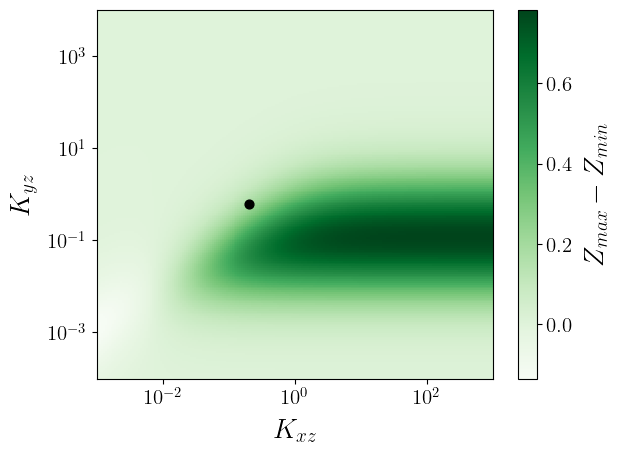

In [105]:
rys = [0, 2]
rzs = [0, 2, 0]
w = 0

length = 200

plow = pAct(10**(-4))
phigh = pAct(10**(-7))

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-4, 4, length)

KX, KY = np.meshgrid(Kxzs, Kyzs)
KXY = np.full_like(KX, 1)
Ks = [KXY, KX, KY]

Xs = np.full_like(KX, 1)

[_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
[_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

lowYweight = steadyStateFeedForwardYWeight(Xs, rys, rzs, w, plow, phigh, Ks)
highYweight = steadyStateFeedForwardYWeight(Xs, rys, rzs, w, phigh, phigh, Ks)

delZ = highYweight - lowYweight

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, delZ, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
ax.scatter(0.2, 0.6, s = 40, c='black')
cbar = plt.colorbar(im)
cbar.set_label(r"$Z_{max} - Z_{min}$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL5.svg", format="svg", bbox_inches="tight")
plt.show()


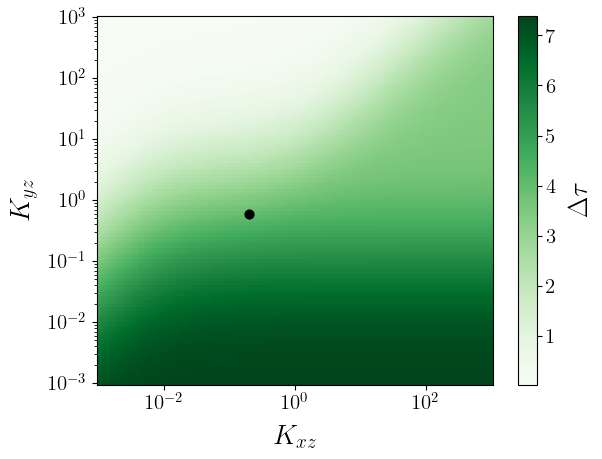

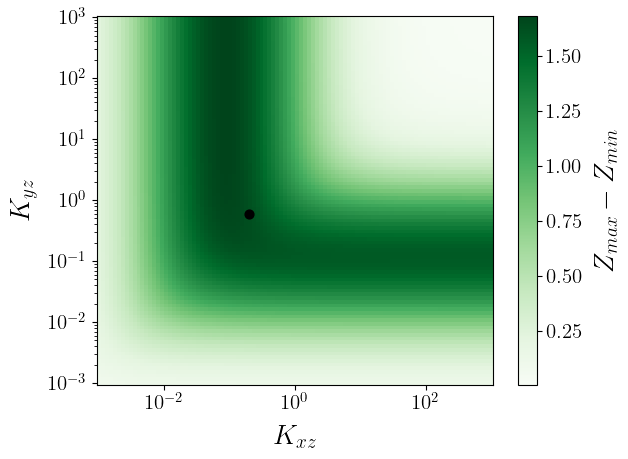

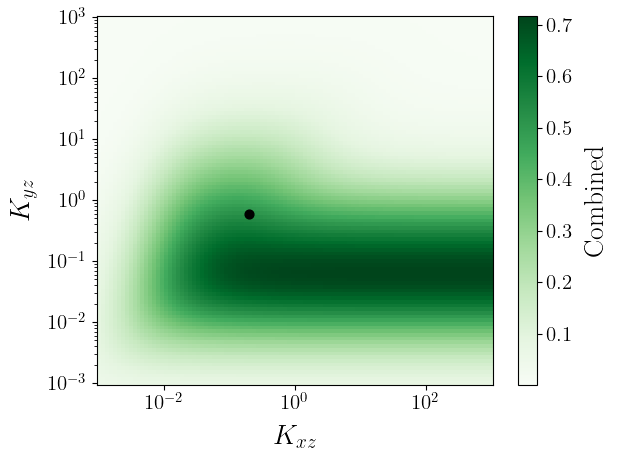

In [8]:
rys = [0, 2]
rzs = [0, 2, 20]
w = 0

length = 100

plow = pAct(10**(-4))
phigh = pAct(10**(-7))

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

KX, KY = np.meshgrid(Kxzs, Kyzs)
KXY = np.full_like(KX, 1)
Ks = [KXY, KX, KY]

Xs = np.full_like(KX, 1)

[_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
[_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

time_diff = np.zeros_like(KX)

for i in range(length):
    for j in range(length):

        z0, zinf = [highZ[i, j], lowZ[i, j]]
        delta = diff_func(ts, rzs, w, plow*1/KX[i, j], (highY[i, j] - lowY[i, j])/KY[i, j], lowY[i, j]/KY[i, j])
        z_ffl = z0*np.exp(-ts) + zinf*(1 - np.exp(-ts)) + delta
        t_simp = z_to_time(z_ffl, z0, zinf)
        time_diff[i, j] = np.max(np.abs(t_simp - ts))

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, time_diff, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
ax.scatter(0.2, 0.6, s = 40, c='black')
cbar = plt.colorbar(im)
cbar.set_label(r"$\Delta\tau$")
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL17.svg", format="svg", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, highZ - lowZ, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
ax.scatter(0.2, 0.6, s = 40, c='black')
cbar = plt.colorbar(im)
cbar.set_label(r"$Z_{max} - Z_{min}$")
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL18.svg", format="svg", bbox_inches="tight")
plt.show()

combined = time_diff/np.max(time_diff) * (highZ - lowZ)/np.max(highZ - lowZ)

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, combined, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
ax.scatter(0.2, 0.6, s = 40, c='black')
cbar = plt.colorbar(im)
cbar.set_label(r"Combined")
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL19.svg", format="svg", bbox_inches="tight")
plt.show()

### Effect of $p_{min}$ and $p_{max}$

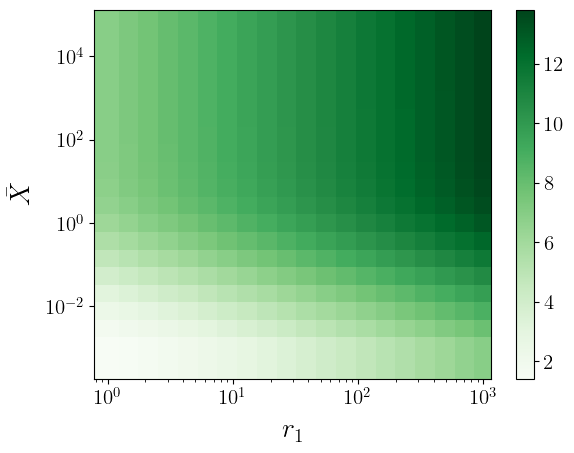

13.815515432071077


In [6]:
# r1, X

length = 20

r1s = np.logspace(0, 3, length)
xs = np.logspace(-3, 5, length)

w = 0

R1s, Xss = np.meshgrid(r1s, xs)
max_delt = np.zeros_like(R1s)
for i in range(length):
    for j in range(length):

        X = Xss[i, j]
        rys = [0, R1s[i, j]]
        rzs = [0, R1s[i, j], 5]

        plow = 0
        phigh = pAct(10**(-7))

        # creating 2d mesh
        Kxzs = np.logspace(-3, 3, 100)
        Kyzs = np.logspace(-3, 3, 100)

        KX, KY = np.meshgrid(Kxzs, Kyzs)
        KXY = np.full_like(KX, 1)
        Ks = [KXY, KX, KY]

        Xs = np.full_like(KX, X)

        [_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
        [_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

        # delta = np.abs(int_delta(rzs, w, phigh*1/KX, (lowY - highY)/KY, highY/KY))
        delta = np.abs(int_delta(rzs, w, plow*X/KX, (highY - lowY)/KY, lowY/KY))
        timescale = delta/(highZ - lowZ)

        max_delt[i, j] = np.max(timescale)

fig, ax = plt.subplots()
im = ax.pcolormesh(R1s, Xss, max_delt, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$r_1$")
ax.set_ylabel(r"$\bar{X}$")
cbar = plt.colorbar(im)
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\ffl_r1_X.svg", format="svg", bbox_inches="tight")
plt.show()

print(np.max(max_delt))

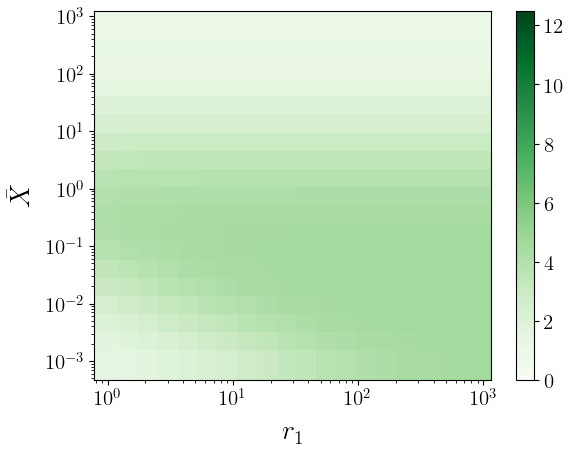

4.632581106091805


In [162]:
# r1, X

length = 20

r1s = np.logspace(0, 3, length)
xs = np.logspace(-3, 3, length)

w = 0

R1s, Xss = np.meshgrid(r1s, xs)
max_delt = np.zeros_like(R1s)
for i in range(length):
    for j in range(length):

        X = Xss[i, j]
        rys = [0, R1s[i, j]]
        rzs = [0, R1s[i, j], 5]

        plow = 10**(-2)
        phigh = 1

        # creating 2d mesh
        Kxzs = np.logspace(-3, 3, 100)
        Kyzs = np.logspace(-3, 3, 100)

        KX, KY = np.meshgrid(Kxzs, Kyzs)
        KXY = np.full_like(KX, 1)
        Ks = [KXY, KX, KY]

        Xs = np.full_like(KX, X)

        [_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
        [_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

        # delta = np.abs(int_delta(rzs, w, phigh*1/KX, (lowY - highY)/KY, highY/KY))
        delta = np.abs(int_delta(rzs, w, plow*X/KX, (highY - lowY)/KY, lowY/KY))
        timescale = delta/(highZ - lowZ)

        max_delt[i, j] = np.max(timescale)

fig, ax = plt.subplots()
im = ax.pcolormesh(R1s, Xss, max_delt, cmap="Greens", rasterized = True, vmin=0, vmax=12.5)
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel(r"$r_1$")
ax.set_ylabel(r"$\bar{X}$")
cbar = plt.colorbar(im)
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\ffl_pact_1.svg", format="svg", bbox_inches="tight")
plt.show()

print(np.max(max_delt))

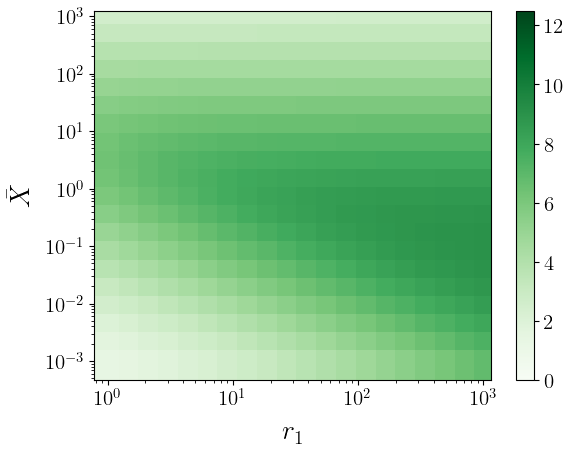

9.015969888345305


In [163]:
# r1, X

length = 20

r1s = np.logspace(0, 3, length)
xs = np.logspace(-3, 3, length)

w = 0

R1s, Xss = np.meshgrid(r1s, xs)
max_delt = np.zeros_like(R1s)
for i in range(length):
    for j in range(length):

        X = Xss[i, j]
        rys = [0, R1s[i, j]]
        rzs = [0, R1s[i, j], 5]

        plow = 10**(-4)
        phigh = 1

        # creating 2d mesh
        Kxzs = np.logspace(-3, 3, 100)
        Kyzs = np.logspace(-3, 3, 100)

        KX, KY = np.meshgrid(Kxzs, Kyzs)
        KXY = np.full_like(KX, 1)
        Ks = [KXY, KX, KY]

        Xs = np.full_like(KX, X)

        [_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
        [_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

        # delta = np.abs(int_delta(rzs, w, phigh*1/KX, (lowY - highY)/KY, highY/KY))
        delta = np.abs(int_delta(rzs, w, plow*X/KX, (highY - lowY)/KY, lowY/KY))
        timescale = delta/(highZ - lowZ)

        max_delt[i, j] = np.max(timescale)

fig, ax = plt.subplots()
im = ax.pcolormesh(R1s, Xss, max_delt, cmap="Greens", rasterized = True, vmin=0, vmax=12.5)
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel(r"$r_1$")
ax.set_ylabel(r"$\bar{X}$")
cbar = plt.colorbar(im)
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\ffl_pact_2.svg", format="svg", bbox_inches="tight")
plt.show()

print(np.max(max_delt))

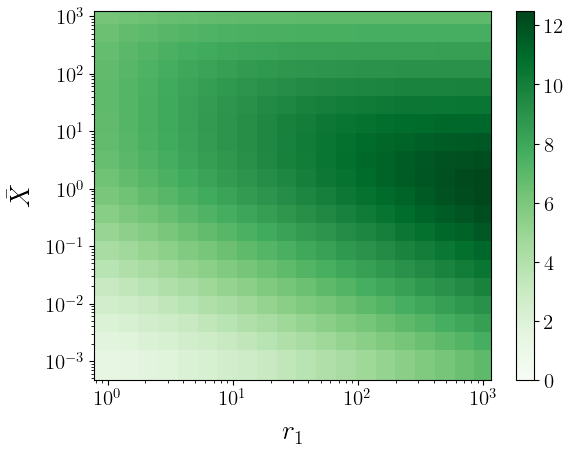

12.396405499110353


In [166]:
# r1, X

length = 20

r1s = np.logspace(0, 3, length)
xs = np.logspace(-3, 3, length)

w = 0

R1s, Xss = np.meshgrid(r1s, xs)
max_delt = np.zeros_like(R1s)
for i in range(length):
    for j in range(length):

        X = Xss[i, j]
        rys = [0, R1s[i, j]]
        rzs = [0, 1, 5]

        plow = 10**(-6)
        phigh = 1

        # creating 2d mesh
        Kxzs = np.logspace(-3, 3, 100)
        Kyzs = np.logspace(-3, 3, 100)

        KX, KY = np.meshgrid(Kxzs, Kyzs)
        KXY = np.full_like(KX, 1)
        Ks = [KXY, KX, KY]

        Xs = np.full_like(KX, X)

        [_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
        [_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

        # delta = np.abs(int_delta(rzs, w, phigh*1/KX, (lowY - highY)/KY, highY/KY))
        delta = np.abs(int_delta(rzs, w, plow*X/KX, (highY - lowY)/KY, lowY/KY))
        timescale = delta/(highZ - lowZ)

        max_delt[i, j] = np.max(timescale)

fig, ax = plt.subplots()
im = ax.pcolormesh(R1s, Xss, max_delt, cmap="Greens", rasterized = True, vmin=0, vmax=12.5)
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel(r"$r_1$")
ax.set_ylabel(r"$\bar{X}$")
cbar = plt.colorbar(im)
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\ffl_pact_3.svg", format="svg", bbox_inches="tight")
plt.show()

print(np.max(max_delt))

### AND Gate

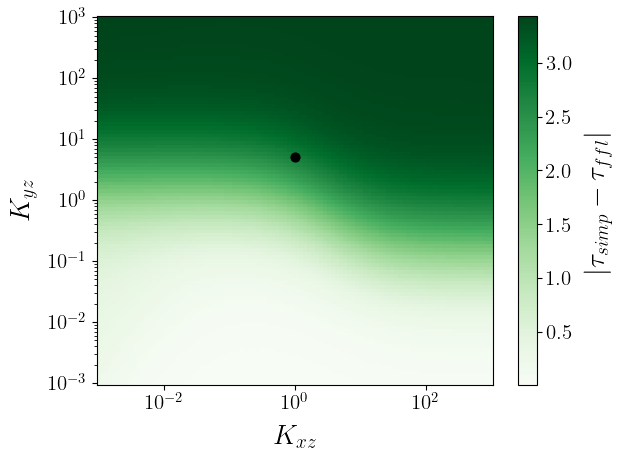

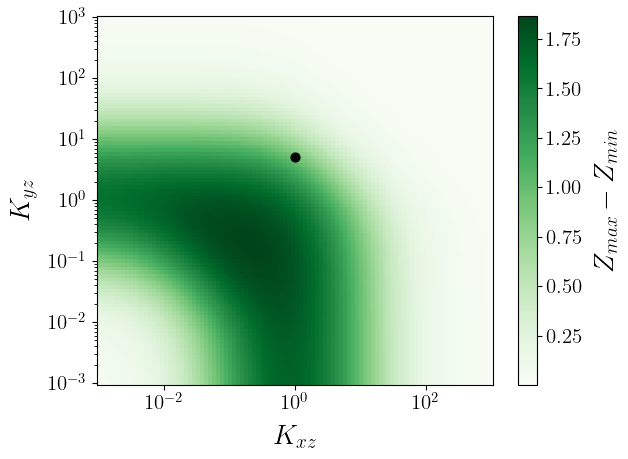

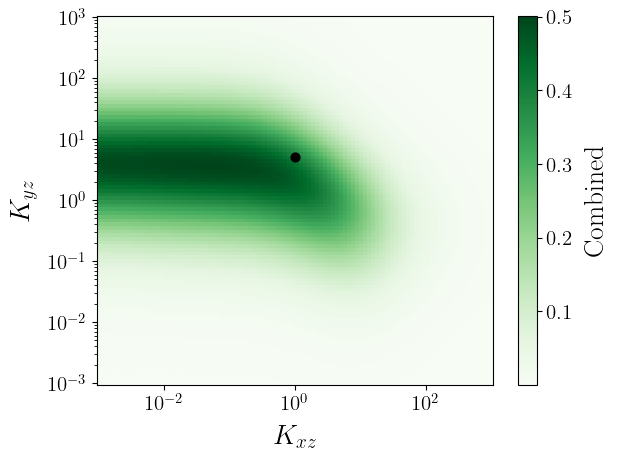

In [9]:
rys = [0, 2]
rzs = [0, 0, 2]
w = 10

length = 100

plow = pAct(10**(-4))
phigh = pAct(10**(-7))

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

KX, KY = np.meshgrid(Kxzs, Kyzs)
KXY = np.full_like(KX, 1)
Ks = [KXY, KX, KY]

Xs = np.full_like(KX, 1)

[_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
[_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

time_diff = np.zeros_like(KX)

for i in range(length):
    for j in range(length):

        z0, zinf = [lowZ[i, j], highZ[i, j]]
        delta = diff_func(ts, rzs, w, phigh*1/KX[i, j], (lowY[i, j] - highY[i, j])/KY[i, j], highY[i, j]/KY[i, j])
        z_ffl = z0*np.exp(-ts) + zinf*(1 - np.exp(-ts)) + delta
        t_simp = z_to_time(z_ffl, z0, zinf)
        time_diff[i, j] = np.max(np.abs(t_simp - ts))

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, time_diff, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
ax.scatter(1, 5, s = 40, c='black')
cbar = plt.colorbar(im)
cbar.set_label(r"$|\tau_{simp} - \tau_{ffl}|$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL5.svg", format="svg", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, np.abs(highZ - lowZ), cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
ax.scatter(1, 5, s = 40, c='black')
cbar = plt.colorbar(im)
cbar.set_label(r"$Z_{max} - Z_{min}$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL5.svg", format="svg", bbox_inches="tight")
plt.show()

combined = time_diff/np.max(time_diff) * (highZ - lowZ)/np.max(highZ - lowZ)

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, combined, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
ax.scatter(1, 5, s = 40, c='black')
cbar = plt.colorbar(im)
cbar.set_label(r"Combined")
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL20.svg", format="svg", bbox_inches="tight")
plt.show()

### Mixed Gates

#### ON Step

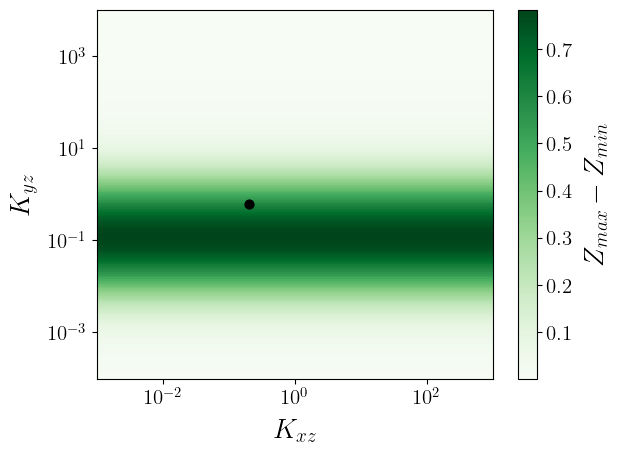

In [106]:
rys = [0, 2]
rzs = [0, 2, 10]
w = 1

length = 200

plow = pAct(10**(-4))
phigh = pAct(10**(-7))

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-4, 4, length)

KX, KY = np.meshgrid(Kxzs, Kyzs)
KXY = np.full_like(KX, 1)
Ks = [KXY, KX, KY]

Xs = np.full_like(KX, 1)

[_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
[_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

lowYweight = steadyStateFeedForwardYWeight(Xs, rys, rzs, w, plow, phigh, Ks)
highYweight = steadyStateFeedForwardYWeight(Xs, rys, rzs, w, phigh, phigh, Ks)

delZ = highYweight - lowYweight

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, delZ, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
ax.scatter(0.2, 0.6, s = 40, c='black')
cbar = plt.colorbar(im)
cbar.set_label(r"$Z_{max} - Z_{min}$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL5.svg", format="svg", bbox_inches="tight")
plt.show()

#### OFF step

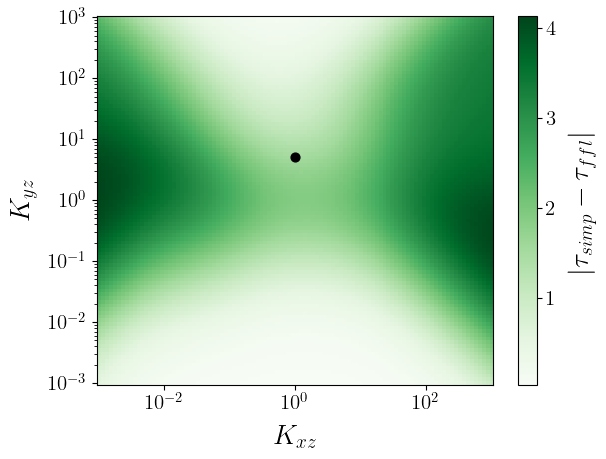

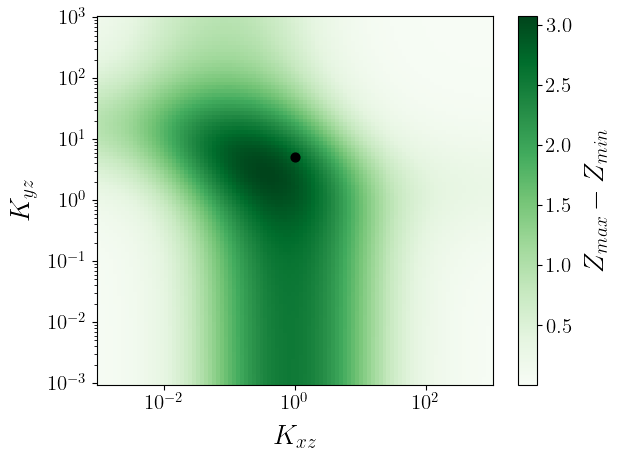

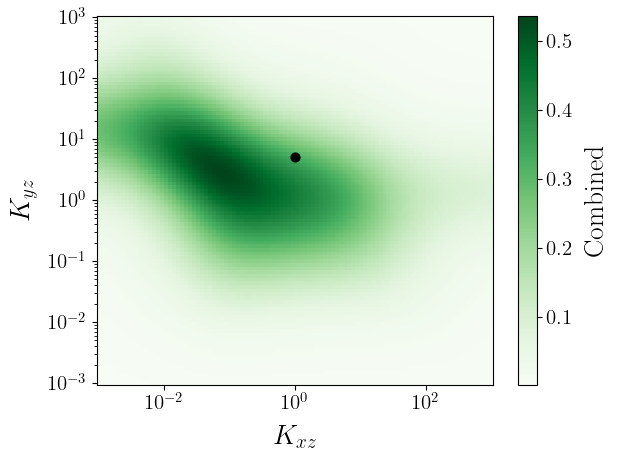

In [40]:
rys = [1, 5]
rzs = [1, 2, 5]
w = 10

length = 100

plow = pAct(10**(-4))
phigh = pAct(10**(-7))

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

KX, KY = np.meshgrid(Kxzs, Kyzs)
KXY = np.full_like(KX, 1)
Ks = [KXY, KX, KY]

Xs = np.full_like(KX, 1)

[_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
[_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

time_diff = np.zeros_like(KX)

for i in range(length):
    for j in range(length):

        z0, zinf = [highZ[i, j], lowZ[i, j]]
        delta = diff_func(ts, rzs, w, plow*1/KX[i, j], (highY[i, j] - lowY[i, j])/KY[i, j], lowY[i, j]/KY[i, j])
        z_ffl = z0*np.exp(-ts) + zinf*(1 - np.exp(-ts)) + delta
        t_simp = z_to_time(z_ffl, z0, zinf)
        time_diff[i, j] = np.max(np.abs(t_simp - ts))

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, time_diff, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
ax.scatter(1, 5, s = 40, c='black')
cbar = plt.colorbar(im)
cbar.set_label(r"$|\tau_{simp} - \tau_{ffl}|$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL5.svg", format="svg", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, np.abs(highZ - lowZ), cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
ax.scatter(1, 5, s = 40, c='black')
cbar = plt.colorbar(im)
cbar.set_label(r"$Z_{max} - Z_{min}$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL5.svg", format="svg", bbox_inches="tight")
plt.show()

combined = time_diff/np.max(time_diff) * (highZ - lowZ)/np.max(highZ - lowZ)

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, combined, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
ax.scatter(1, 5, s = 40, c='black')
cbar = plt.colorbar(im)
cbar.set_label(r"Combined")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL22.svg", format="svg", bbox_inches="tight")
plt.show()

## Existence of Pulse in Incoherent FFL

In [68]:
# define the functions for incoherent FFL

def steadyStateFeedForwardIncoh(X, rys, rzs, w, px, py, Ks):
    
    Kxy, Kxz, Kyz = Ks

    Y = (rys[0] + rys[1]*px*X/Kxy)/(1 + px*X/Kxy)
    Z = (rzs[0] + rzs[1]*px*X/Kxz)/(1 + px*X/Kxz + py*Y/Kyz + w*px*X/Kxz*py*Y/Kyz)

    if type(Y) is np.float64:
        return np.array([X, Y, Z])
    else:
        Xarray = np.full_like(Y, X)
        return [Xarray, Y, Z]
    
    return np.array([X, Y, Z])

def steadyStateSimpleRegIncoh(X, Y, rzs, w, px, py, Ks):

    Kxy, Kxz, Kyz = Ks
    
    Z = (rzs[0] + rzs[1]*px*X/Kxz)/(1 + px*X/Kxz + py*Y/Kyz + w*px*X/Kxz*py*Y/Kyz)

    return np.array([X, Y, Z])

def evolveFeedForwardIncoh(Rs, rys, rzs, w, px, py, delt, Ks):

    Kxy, Kxz, Kyz = Ks

    dRsdt = np.zeros_like(Rs)
    dRsdt[1] = - Rs[1] + (rys[0] + rys[1]*px*Rs[0]/Kxy)/(1 + px*Rs[0]/Kxy)
    dRsdt[2] = - Rs[2] + (rzs[0] + rzs[1]*px*Rs[0]/Kxz)/(1 + px*Rs[0]/Kxz + py*Rs[1]/Kyz + w*px*Rs[0]/Kxz*py*Rs[1]/Kyz)
    
    Rs_new = Rs + dRsdt * delt

    return Rs_new

def evolveSimpleRegIncoh(Rs, rys, rzs, w, px, py, delt, Ks):

    Kxy, Kxz, Kyz = Ks

    dRsdt = np.zeros_like(Rs)
    dRsdt[2] = - Rs[2] + (rzs[0] + rzs[1]*px*Rs[0]/Kxz)/(1 + px*Rs[0]/Kxz + py*Rs[1]/Kyz + w*px*Rs[0]/Kxz*py*Rs[1]/Kyz)
    
    Rs_new = Rs + dRsdt * delt

    return Rs_new

In [69]:
def analytic_Z_incoh(ts, rs, w, X, yinit, yinf, z0):

    r0, r1, r2 = rs
    y0 = yinf
    y1 = yinit - yinf

    integral = 1/(1 + X + y0 + w*X*y0)**2 * (np.exp(ts) * (1 + X + y0 + w*X*y0)*\
                        (r0 + r1*(X + y0) + r2*w*X*y0) - (r0*(1+w*X) - r2*w*X*(1+X) +\
                        r1*(-1+w*X**2)) * y1 * np.log(np.exp(ts)*(1 + X + y0*(1 + w*X)) + y1*(1 + w*X)))
    integral0 = 1/(1 + X + y0 + w*X*y0)**2 * ((1 + X + y0 + w*X*y0)*\
                        (r0 + r1*(X + y0) + r2*w*X*y0) - (r0*(1+w*X) - r2*w*X*(1+X) +\
                        r1*(-1+w*X**2)) * y1 * np.log((1 + X + y0*(1 + w*X)) + y1*(1 + w*X)))
    zs = np.exp(-ts)*(integral - integral0 + z0)

    return zs

def diff_func_incoh(ts, rs, w, X, delY, Yinf):
    
    r0, r1, r2 = rs

    S = 1 + X + Yinf + w*X*Yinf
    Phi = -(r0 + r1*X)*(1 + w*X)
    
    return np.exp(-ts)*(Phi*delY/S**2)*np.log((S*np.exp(ts) + delY*(1 + w*X))/(S + delY*(1 + w*X)))

def int_delta_incoh(rs, w, X, delY, Yinf):

    r0, r1, r2 = rs

    S = 1 + X + Yinf + w*X*Yinf
    Phi = -(r0 + r1*X)*(1 + w*X)

    return Phi/(S*(1 + w*X))*np.log(1 + delY * (1 + w*X) / S)

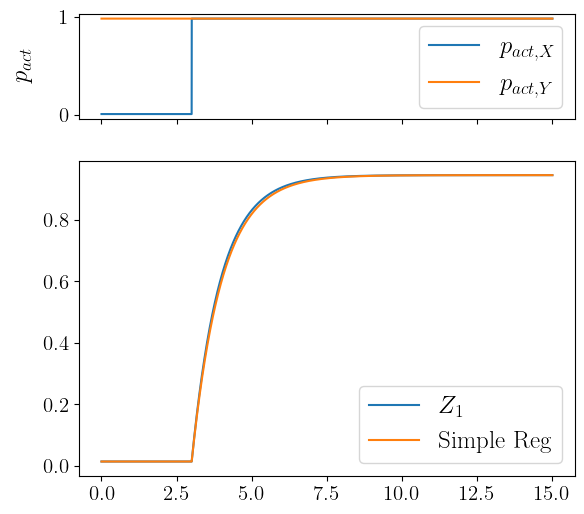

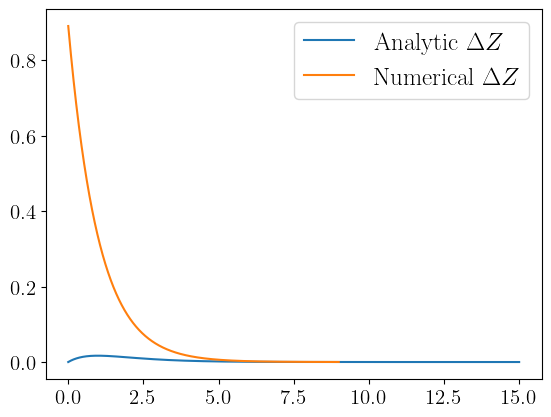

In [84]:
nstep = int(1.5*10**4)
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2]
rzs = [0, 2, 10]
w = 0

Ks = [1, 1, 10]
# Ks = [1, 10**(-2), 10**(-2.5)]
# defining how inducer concentration is tuned

plow = pAct(10**(-4))
phigh = pAct(10**(-7))
empty = np.full(int(nstep/5), plow)
full = np.full(int(nstep/5), phigh)

# Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
# Cys = np.full(nstep, 10**(-7))

pxs = np.concatenate((empty, full, full, full, full))
pys = np.full(nstep, phigh)

X = 1
Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForwardIncoh(X, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.copy(Rs)
Ys = steadyStateFeedForwardIncoh(X, rys, rzs, w, pxs, pys[0], Ks)[1]

Rps[:, 0] = np.full_like(Ys, X)
Rps[:, 1] = np.copy(Ys)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForwardIncoh(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
    Rps[i+1, 2] = evolveSimpleRegIncoh(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)[2]

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

yinit = Rs[0, 1]/Ks[2]
yinf = steadyStateFeedForwardIncoh(X, rys, rzs, w, pAct(10**(-7)), pAct(10**(-7)), Ks)[1]/Ks[2]
delY = yinit - yinf

axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
# axs[0].set_yscale("log")
axs[0].legend()
axs[0].xaxis.set_ticklabels([])
# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, Rs[:, 2], label=r"$Z_1$")
axs[1].plot(ts, Rps[:, 2], label=r"Simple Reg")
# axs[1].set_xlabel(r"$t \, (1/\gamma)$")
# axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()

# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\ffl_incoh1.svg", format="svg", bbox_inches="tight")
plt.show()

diff = diff_func_incoh(ts, rzs, w, pxs[-1]*X/Ks[1], delY, yinf)
num_diff = (Rs[:, 2] - (Rs[0, 2] * np.exp(-ts+6) + Rs[-1, 2] * (1 - np.exp(-ts+6))))

plt.plot(ts, diff, label=r"Analytic $\Delta Z$")
plt.plot(ts[6000:]-6, num_diff[6000:], label=r"Numerical $\Delta Z$")
# plt.plot(ts, (Rs[0, 2] * np.exp(-ts) + Rs[-1, 2] * (1 - np.exp(-ts))) + diff)
plt.legend()
plt.show()

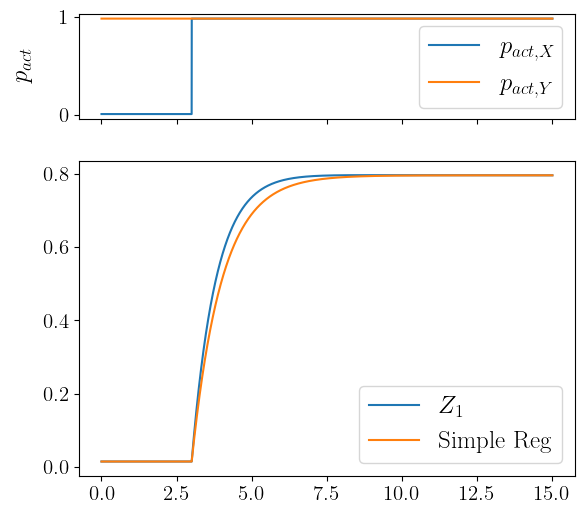

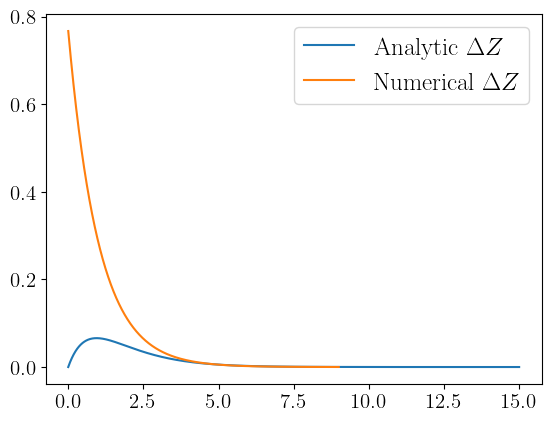

In [64]:
nstep = int(1.5*10**4)
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2]
rzs = [0, 2, 10]
w = 0

Ks = [1, 1, 2]
# Ks = [1, 10**(-2), 10**(-2.5)]
# defining how inducer concentration is tuned

plow = pAct(10**(-4))
phigh = pAct(10**(-7))
empty = np.full(int(nstep/5), plow)
full = np.full(int(nstep/5), phigh)

# Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
# Cys = np.full(nstep, 10**(-7))

pxs = np.concatenate((empty, full, full, full, full))
pys = np.full(nstep, phigh)

X = 1
Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForwardIncoh(X, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.copy(Rs)
Ys = steadyStateFeedForwardIncoh(X, rys, rzs, w, pxs, pys[0], Ks)[1]

Rps[:, 0] = np.full_like(Ys, X)
Rps[:, 1] = np.copy(Ys)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForwardIncoh(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
    Rps[i+1, 2] = evolveSimpleRegIncoh(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)[2]

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

yinit = Rs[0, 1]/Ks[2]
yinf = steadyStateFeedForwardIncoh(X, rys, rzs, w, pAct(10**(-7)), pAct(10**(-7)), Ks)[1]/Ks[2]
delY = yinit - yinf

axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
# axs[0].set_yscale("log")
axs[0].legend()
axs[0].xaxis.set_ticklabels([])
# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, Rs[:, 2], label=r"$Z_1$")
axs[1].plot(ts, Rps[:, 2], label=r"Simple Reg")
# axs[1].set_xlabel(r"$t \, (1/\gamma)$")
# axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()

# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\ffl_incoh2.svg", format="svg", bbox_inches="tight")
plt.show()

diff = diff_func_incoh(ts, rzs, w, pxs[-1]*X/Ks[1], delY, yinf)
num_diff = (Rs[:, 2] - (Rs[0, 2] * np.exp(-ts+6) + Rs[-1, 2] * (1 - np.exp(-ts+6))))

plt.plot(ts, diff, label=r"Analytic $\Delta Z$")
plt.plot(ts[6000:]-6, num_diff[6000:], label=r"Numerical $\Delta Z$")
# plt.plot(ts, (Rs[0, 2] * np.exp(-ts) + Rs[-1, 2] * (1 - np.exp(-ts))) + diff)
plt.legend()
plt.show()

0.7227704920957739 1.650557271646213


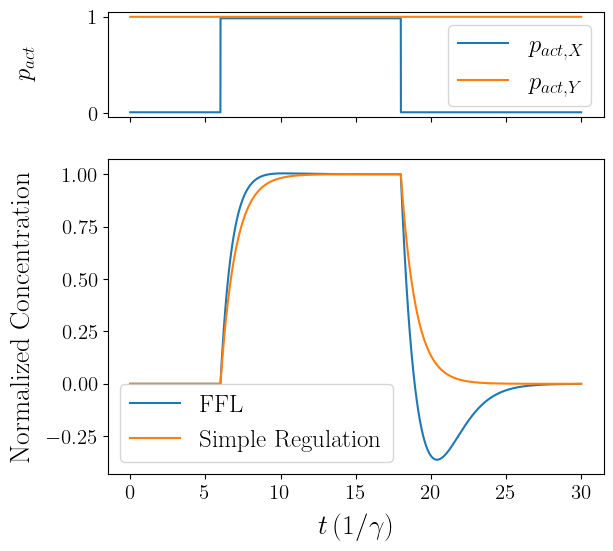

In [39]:
nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2]
rzs = [0, 2, 20]
w = 0

# Ks = [0.5, 0.1, 0.3]
Ks = [1, 0.01, 0.05]
# defining how inducer concentration is tuned

empty = np.full(int(nstep/5), pAct(10**(-4)))
full = np.full(int(nstep/5), pAct(10**(-7)))

# Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
# Cys = np.full(nstep, 10**(-7))

pxs = np.concatenate((empty, full, full, empty, empty))
pys = np.full(nstep, 1)

Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForwardIncoh(1, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.zeros((nstep, 3))
X, Y = [1, 1]
Rps[0, :] = steadyStateSimpleRegIncoh(X, Y, rzs, w, pxs[0], pys[0], Ks)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForwardIncoh(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
    Rps[i+1, :] = evolveSimpleRegIncoh(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

if True:
    axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
    axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    # axs[0].set_yscale("log")
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

Rmax = steadyStateFeedForwardIncoh(1, rys, rzs, w, pAct(10**(-7)), 1, Ks)[2]
Rmin = steadyStateFeedForwardIncoh(1, rys, rzs, w, pAct(10**(-4)), 1, Ks)[2]
# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, normalize_pulse(Rs[:, 2], Rmax, Rmin), label=r"FFL")
axs[1].plot(ts, normalize(Rps[:, 2]), label=r"Simple Regulation")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()

# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL1.svg", format="svg", bbox_inches="tight")
plt.show()

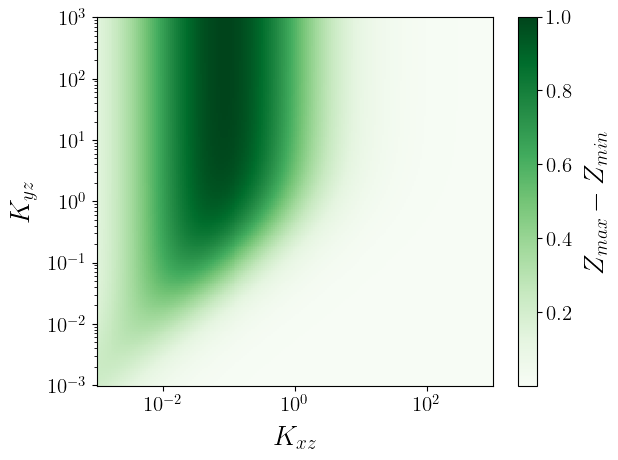

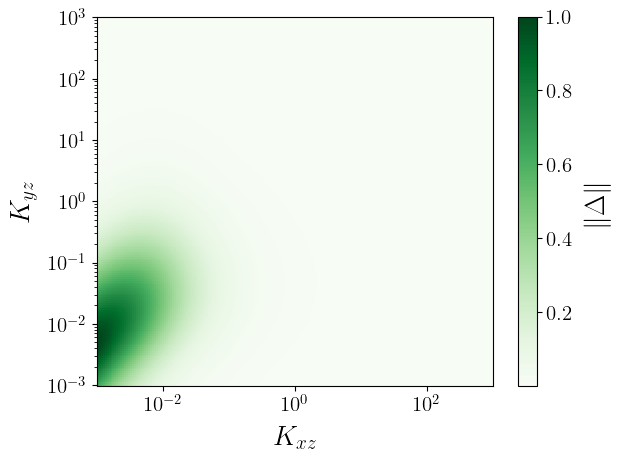

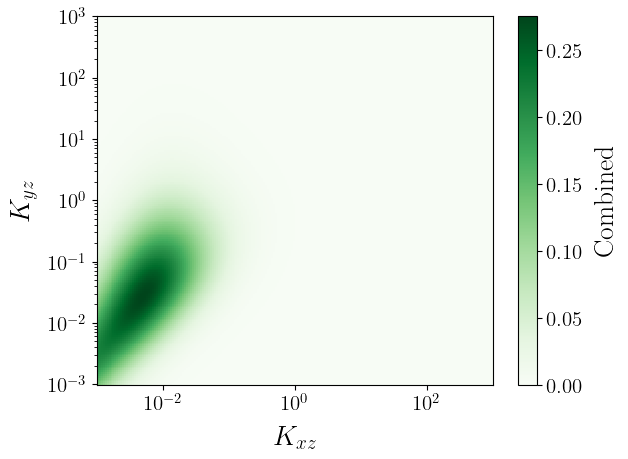

In [54]:
rys = [0, 2]
rzs = [0, 2, 20]
w = 0

length = 200

plow = pAct(10**(-4))
phigh = pAct(10**(-7))

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

KX, KY = np.meshgrid(Kxzs, Kyzs)
KXY = np.full_like(KX, 1)
Ks = [KXY, KX, KY]

Xs = np.full_like(KX, 1)

[_, lowY, lowZ] = steadyStateFeedForwardIncoh(Xs, rys, rzs, w, plow, phigh, Ks)
[_, highY, highZ] = steadyStateFeedForwardIncoh(Xs, rys, rzs, w, phigh, phigh, Ks)

delta = np.abs(int_delta_incoh(rzs, w, plow*1/KX, (highY - lowY)/KY, lowY/KY))

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, (highZ - lowZ)/np.max(highZ - lowZ), cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
cbar = plt.colorbar(im)
cbar.set_label(r"$Z_{max} - Z_{min}$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL5.svg", format="svg", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, delta/np.max(delta), cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
cbar = plt.colorbar(im)
cbar.set_label(r"$\|\Delta\|$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL6.svg", format="svg", bbox_inches="tight")
plt.show()

delta_and_Z = (highZ - lowZ)/np.max(highZ - lowZ) * delta/np.max(delta)

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, delta_and_Z, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
cbar = plt.colorbar(im)
cbar.set_label(r"Combined")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL7.svg", format="svg", bbox_inches="tight")
plt.show()

### systematically checking the existence of pulse

In [ ]:
# Pulse for ON step, OR gate

nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2]
rzs = [0, 2, 10]
w = 0

length = 100

plow = pAct(10**(-4))
phigh = pAct(10**(-7))

X = 1

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

KX, KY = np.meshgrid(Kxzs, Kyzs)
KXY = np.full_like(KX, 1)
Ks = [KXY, KX, KY]

Xs = np.full_like(KX, 1)

[_, lowY, lowZ] = steadyStateFeedForwardIncoh(Xs, rys, rzs, w, plow, phigh, Ks)
[_, highY, highZ] = steadyStateFeedForwardIncoh(Xs, rys, rzs, w, phigh, phigh, Ks)

Zdiff = highZ - lowZ

max_Z = np.zeros_like(KX)

for i in range(length):
    for j in range(length):
        diff = diff_func_incoh(ts, rzs, w, phigh*X/KX[i, j], (lowY[i, j] - highY[i, j])/KY[i, j], highY[i, j]/KY[i, j])
        max_Z[i, j] = np.max(diff + lowZ[i, j]*np.exp(-ts) + highZ[i, j]*(1 - np.exp(-ts)))
        
has_pulse = max_Z > highZ
pulse_val = (max_Z - highZ)

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, has_pulse, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
cbar = plt.colorbar(im)
# cbar.set_label(r"$\|\Delta\|$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL6.svg", format="svg", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, pulse_val, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
cbar = plt.colorbar(im)
# cbar.set_label(r"$\|\Delta\|$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL6.svg", format="svg", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, pulse_val > 0.1, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
cbar = plt.colorbar(im)
# cbar.set_label(r"$\|\Delta\|$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL12.svg", format="svg", bbox_inches="tight")
plt.show()


KeyboardInterrupt: 

Now let's try analytic method

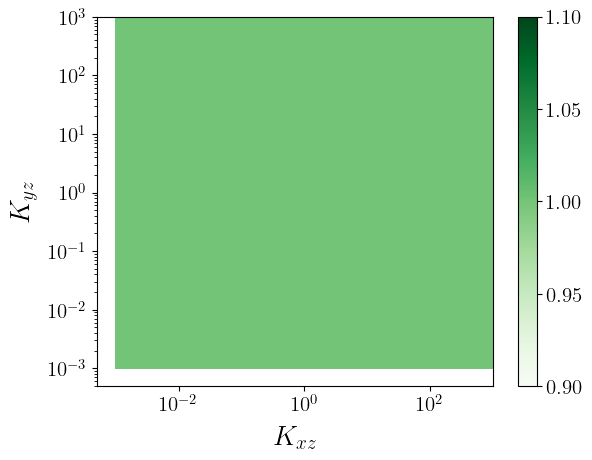

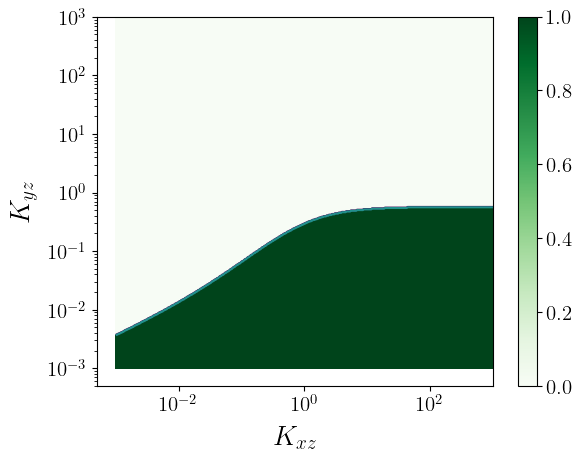

0.716363878689418
1.9186326028482718e-06
0.9998642440846061
0.0


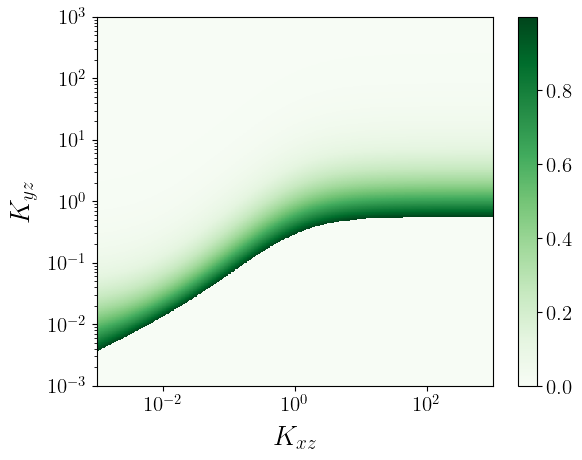

In [ ]:
# Pulse for ON step

nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2]
rzs = [0, 2, 10]
w = 0

length = 500

plow = pAct(10**(-4))
phigh = pAct(10**(-7))

X = 1

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

KX, KY = np.meshgrid(Kxzs, Kyzs)
KXY = np.full_like(KX, 1)
Ks = [KXY, KX, KY]

Xs = np.full_like(KX, 1)

[_, lowY, lowZ] = steadyStateFeedForwardIncoh(Xs, rys, rzs, w, plow, phigh, Ks)
[_, highY, highZ] = steadyStateFeedForwardIncoh(Xs, rys, rzs, w, phigh, phigh, Ks)

# analytics
Zdiff = highZ - lowZ
delta_mag = int_delta_incoh(rzs, w, phigh*X/KX, (lowY - highY)/KY, highY/KY)

if False:
    fig, ax = plt.subplots()
    im = ax.pcolormesh(KX, KY, Zdiff > 0, cmap="Greens", rasterized = True, shading='auto')
    ax.contour(KX, KY, Zdiff > 0, levels=1)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$K_{xz}$")
    ax.set_ylabel(r"$K_{yz}$")
    cbar = plt.colorbar(im)
    # cbar.set_label(r"$\|\Delta\|$")
    #plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_pulse1.svg", format="svg", bbox_inches="tight")
    plt.show()

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, delta_mag > Zdiff, cmap="Greens", rasterized = True, shading='auto')
ax.contour(KX, KY, delta_mag > Zdiff, levels=1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
cbar = plt.colorbar(im)
# cbar.set_label(r"$\|\Delta\|$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_pulse1.svg", format="svg", bbox_inches="tight")
plt.show()

print(np.max(delta_mag))
print(np.min(delta_mag))


time_acceleration = delta_mag/Zdiff
time_acceleration[time_acceleration > 1] = 0
time_acceleration[time_acceleration < 0] = 0


fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, time_acceleration, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
cbar = plt.colorbar(im)
# cbar.set_label(r"$\|\Delta\|$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_pulse2.svg", format="svg", bbox_inches="tight")
plt.show()

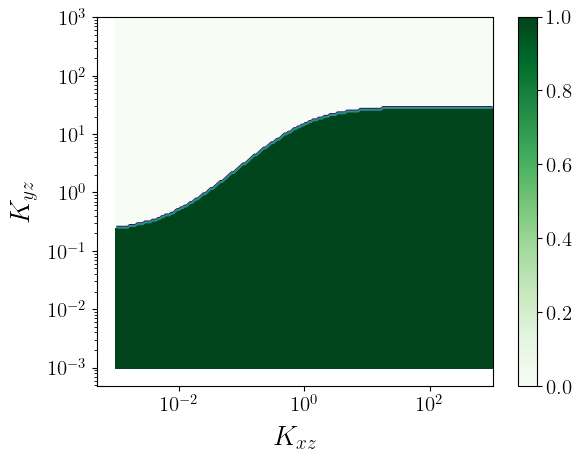

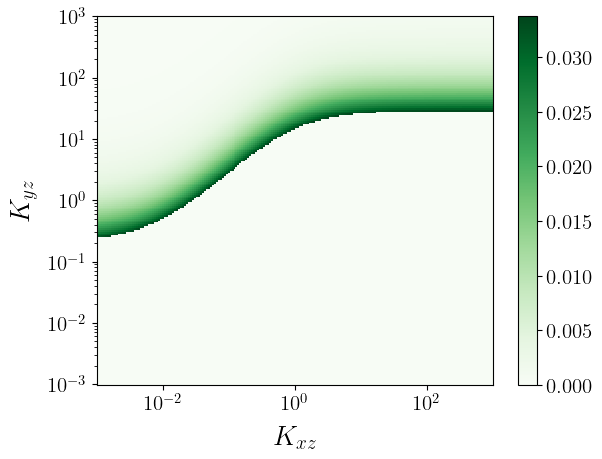

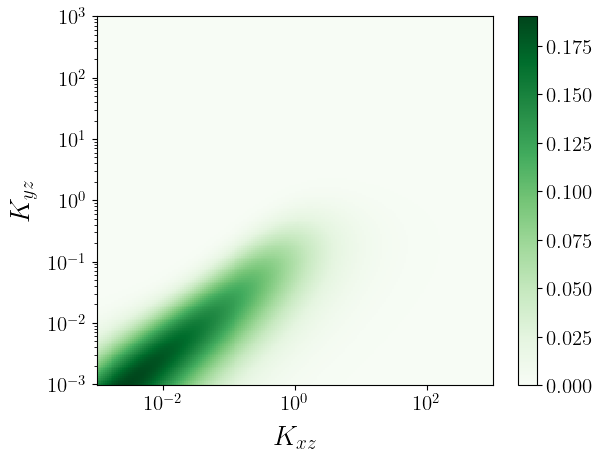

In [93]:
# Pulse for ON step

nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2]
rzs = [0, 2, 0]
w = 0

length = 200
plow = pAct(10**(-4))
phigh = pAct(10**(-7))

# plow = 0
# phigh = 1

X = 1

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

KX, KY = np.meshgrid(Kxzs, Kyzs)
KXY = np.full_like(KX, 1)
Ks = [KXY, KX, KY]

Xs = np.full_like(KX, 1)

[_, lowY, lowZ] = steadyStateFeedForwardIncoh(Xs, rys, rzs, w, plow, phigh, Ks)
[_, highY, highZ] = steadyStateFeedForwardIncoh(Xs, rys, rzs, w, phigh, phigh, Ks)

# numerics
max_Z = np.zeros_like(KX)

for i in range(length):
    for j in range(length):
        diff = diff_func_incoh(ts, rzs, w, phigh*X/KX[i, j], (lowY[i, j] - highY[i, j])/KY[i, j], highY[i, j]/KY[i, j])
        max_Z[i, j] = np.max(diff + lowZ[i, j]*np.exp(-ts) + highZ[i, j]*(1 - np.exp(-ts)))
        
pulse_val = (max_Z - highZ)

# analytics
Zdiff = highZ - lowZ
delta_mag = int_delta_incoh(rzs, w, phigh*X/KX, (lowY - highY)/KY, highY/KY)

threshold = 0
fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, pulse_val > threshold*Zdiff, cmap="Greens", rasterized = True)
ax.contour(KX, KY, pulse_val > threshold*Zdiff, levels=1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
cbar = plt.colorbar(im)
# cbar.set_label(r"$\|\Delta\|$")
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_pulse1.svg", format="svg", bbox_inches="tight")
plt.show()

time_acceleration = delta_mag/Zdiff
time_acceleration[pulse_val > threshold*Zdiff] = 0

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, time_acceleration, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
cbar = plt.colorbar(im)
# cbar.set_label(r"$\|\Delta\|$")
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_pulse2.svg", format="svg", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, pulse_val, cmap="Greens", rasterized = True)
# contours = plt.contour(KX, KY, pulse_val, levels=1, colors='black')
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
cbar = plt.colorbar(im)
# cbar.set_label(r"$\|\Delta\|$")
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_pulse3.svg", format="svg", bbox_inches="tight")
plt.show()

In [ ]:
# Pulse for ON step

nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2]
rzs = [0, 2, 10]
w = 0

length = 100
plow = pAct(10**(-4))
phigh = pAct(10**(-7))

# plow = 0
# phigh = 1

X = 1

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

KX, KY = np.meshgrid(Kxzs, Kyzs)
KXY = np.full_like(KX, 1)
Ks = [KXY, KX, KY]

Xs = np.full_like(KX, 1)

[_, lowY, lowZ] = steadyStateFeedForwardIncoh(Xs, rys, rzs, w, plow, phigh, Ks)
[_, highY, highZ] = steadyStateFeedForwardIncoh(Xs, rys, rzs, w, phigh, phigh, Ks)

# numerics
max_Z = np.zeros_like(KX)

for i in range(length):
    for j in range(length):
        diff = diff_func_incoh(ts, rzs, w, phigh*X/KX[i, j], (lowY[i, j] - highY[i, j])/KY[i, j], highY[i, j]/KY[i, j])
        max_Z[i, j] = np.max(diff + lowZ[i, j]*np.exp(-ts) + highZ[i, j]*(1 - np.exp(-ts)))
        
pulse_val = (max_Z - highZ)

# analytics
Zdiff = highZ - lowZ
delta_mag = int_delta_incoh(rzs, w, phigh*X/KX, (lowY - highY)/KY, highY/KY)

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, pulse_val > 0, cmap="Greens", rasterized = True)
ax.contour(KX, KY, pulse_val > 0, levels=1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
cbar = plt.colorbar(im)
# cbar.set_label(r"$\|\Delta\|$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL13.svg", format="svg", bbox_inches="tight")
plt.show()

time_acceleration = delta_mag/Zdiff
time_acceleration[pulse_val > 0] = 0

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, time_acceleration, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
cbar = plt.colorbar(im)
# cbar.set_label(r"$\|\Delta\|$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL13.svg", format="svg", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, pulse_val, cmap="Greens", rasterized = True)
# contours = plt.contour(KX, KY, pulse_val, levels=1, colors='black')
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
cbar = plt.colorbar(im)
# cbar.set_label(r"$\|\Delta\|$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_pulse3.svg", format="svg", bbox_inches="tight")
plt.show()

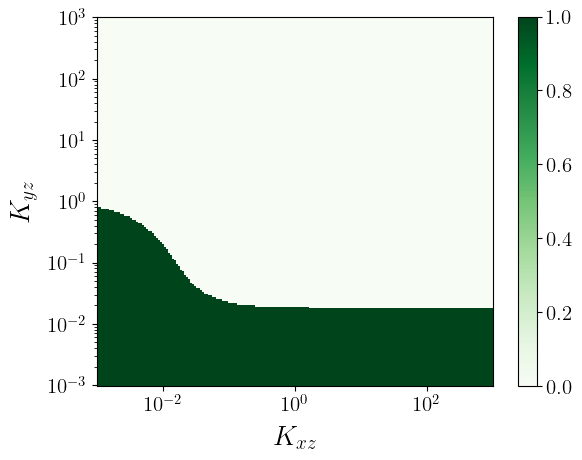

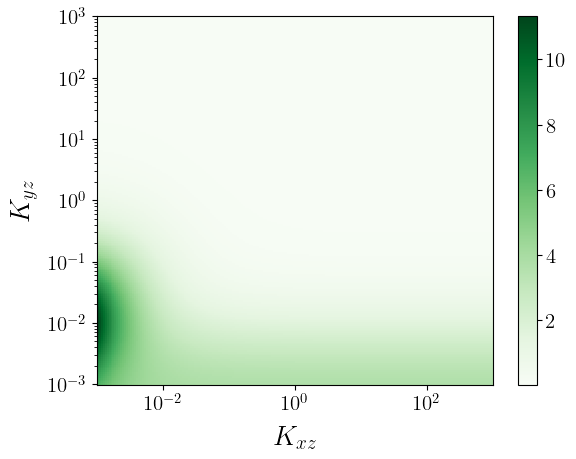

In [19]:
# Pulse for OFF step

nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2]
rzs = [0, 2, 20]
w = 0

length = 200

plow = pAct(10**(-4))
phigh = pAct(10**(-7))

X = 1

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

KX, KY = np.meshgrid(Kxzs, Kyzs)
KXY = np.full_like(KX, 1)
Ks = [KXY, KX, KY]

Xs = np.full_like(KX, 1)

[_, lowY, lowZ] = steadyStateFeedForwardIncoh(Xs, rys, rzs, w, plow, phigh, Ks)
[_, highY, highZ] = steadyStateFeedForwardIncoh(Xs, rys, rzs, w, phigh, phigh, Ks)

Zdiff = highZ - lowZ
delta_mag = int_delta_incoh(rzs, w, plow*X/KX, (highY - lowY)/KY, lowY/KY)

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, np.abs(delta_mag) > Zdiff, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
cbar = plt.colorbar(im)
# cbar.set_label(r"$\|\Delta\|$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL6.svg", format="svg", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, np.abs(delta_mag)/Zdiff, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
cbar = plt.colorbar(im)
# cbar.set_label(r"$\|\Delta\|$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL6.svg", format="svg", bbox_inches="tight")
plt.show()

-10.0
0 0.16666666679433256


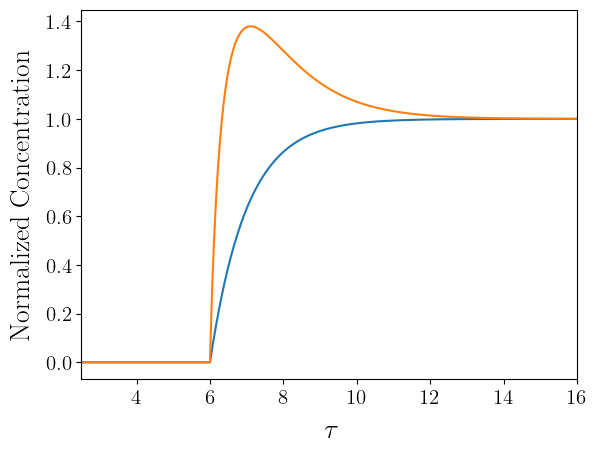

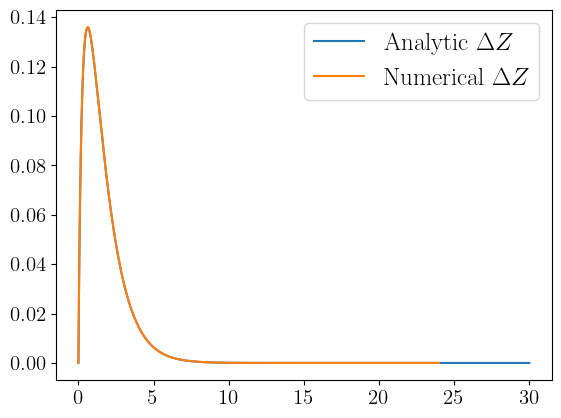

In [6]:
nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2]
rzs = [0, 2, 20]
w = 0

# Ks = [0.5, 0.1, 0.3]
Ks = [1, 1, 0.1]
# defining how inducer concentration is tuned

empty = np.full(int(nstep/5), 0)
full = np.full(int(nstep/5), 1)

# Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
# Cys = np.full(nstep, 10**(-7))

pxs = np.concatenate((empty, full, full, full, full))
pys = np.full(nstep, 1)

X = 1
Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForwardIncoh(X, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.zeros((nstep, 3))
X, Y = [1, 1]
Rps[0, :] = steadyStateSimpleRegIncoh(X, Y, rzs, w, pxs[0], pys[0], Ks)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForwardIncoh(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
    Rps[i+1, :] = evolveSimpleRegIncoh(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)


yinit = Rs[0, 1]/Ks[2]
yinf = steadyStateFeedForwardIncoh(X, rys, rzs, w, 1, 1, Ks)[1]/Ks[2]
delY = yinit - yinf

print(delY)

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
plt.plot(ts, normalize(Rps[:, 2]), label=r"Simple Reg")
plt.plot(ts, normalize_pulse(Rs[:, 2], Rs[-1, 2], 0), label=r"Z")
plt.xlabel(r"$\tau$")
plt.ylabel(r"Normalized Concentration")
plt.xlim((2.5, 16))
# plt.legend()

# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL11.svg", format="svg", bbox_inches="tight")
plt.show()

diff = diff_func_incoh(ts, rzs, w, pxs[-1]*X/Ks[1], delY, yinf)
num_diff = (Rs[:, 2] - (Rs[0, 2] * np.exp(-ts+6) + Rs[-1, 2] * (1 - np.exp(-ts+6))))

plt.plot(ts, diff, label=r"Analytic $\Delta Z$")
plt.plot(ts[6000:]-6, num_diff[6000:], label=r"Numerical $\Delta Z$")
# plt.plot(ts, (Rs[0, 2] * np.exp(-ts) + Rs[-1, 2] * (1 - np.exp(-ts))) + diff)
plt.legend()
plt.show()

## Continuous Signal

### Fastest tuning

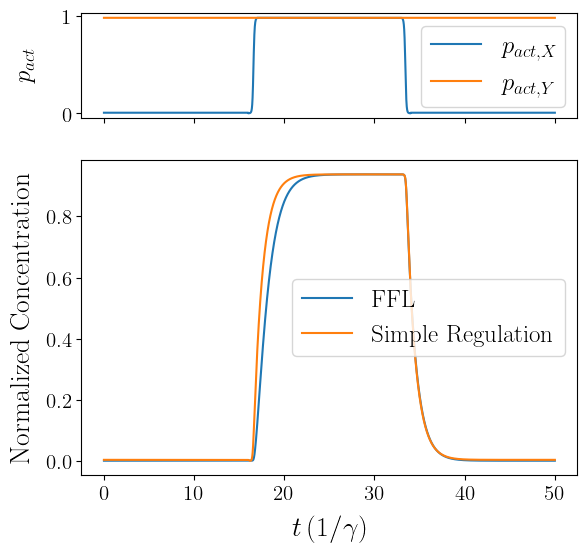

In [106]:
nstep = 5*10**4
delt = 10**(-3)

# defining how inducer concentration is tuned
flat = np.full(16000, 10**(-4))
flat_low = np.full(16000, 10**(-7))
increase = np.logspace(-7, -3, 1000)
decrease = np.logspace(-3, -7, 1000)

ts = np.linspace(0, nstep*delt, nstep)

if False:
    rys = [0, 2]
    rzs = [0, 2, 20]
    w = 0

    Ks = [1, 0.2, 0.6]

if True:
    rys = [0, 2]
    rzs = [0, 0, 2]
    w = 10

    Ks = [1, 1, 5]
Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
Cys = np.full(nstep, 10**(-7))
# Cys = np.concatenate((flat, decrease, flat_low, increase, flat))

pxs = pAct(Cxs)
pys = pAct(Cys)

X = 1

# Cxs_prime = np.concatenate((flat, np.full(1000, 10**(-7)), flat_low, np.full(1000, 10**(-7)), flat))
Ys = np.full(nstep, 1)

Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForward(X, rys, rzs, w, pxs[0], pys[0], Ks)

Rps[0, :] = steadyStateSimpleReg(X, Ys[0], rzs, w, pxs[0], pys[0], Ks)
Rps[:, 0] = np.full(nstep, X)
Rps[:, 1] = np.copy(Ys)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
    Rps[i+1, 2] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)[2]

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

# print(np.max(Rs[:, 2]) - np.min(Rs[:, 2]))
if True:
    axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
    axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    # axs[0].set_yscale("log")
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, Rs[:, 2], label=r"FFL")
axs[1].plot(ts, normalize(Rps[:, 2])*(np.max(Rs[:, 2]) - np.min(Rs[:, 2])) + np.min(Rs[:, 2]), label=r"Simple Regulation")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()
# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_fast_tuning.svg", format="svg", bbox_inches="tight")
plt.show()

In [13]:
nstep = 1000
ts = np.linspace(0, nstep*delt, nstep)
ps = pAct(decrease)
cs = [0.2, 0.8]
[t1, t2] = np.interp(cs, ps, ts)
print(t1, t2)
print(np.abs(t1 - t2))

0.49716607031011867 0.6736335163352034
0.17646744602508474


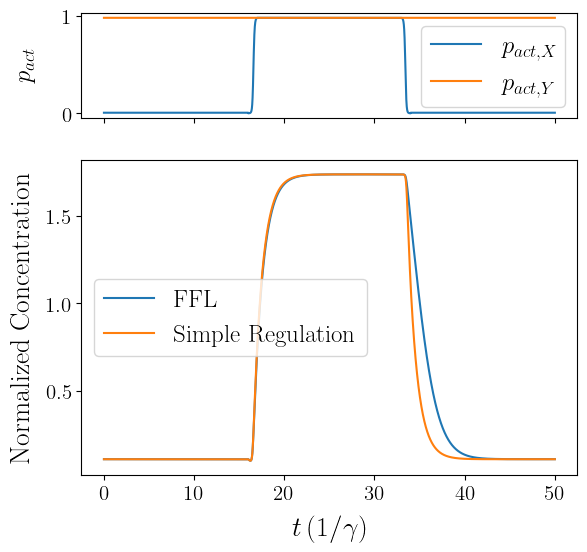

In [99]:
nstep = 5*10**4
delt = 10**(-3)

# defining how inducer concentration is tuned
flat = np.full(16000, 10**(-4))
flat_low = np.full(16000, 10**(-7))
increase = np.logspace(-7, -3, 1000)
decrease = np.logspace(-3, -7, 1000)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2]
rzs = [0, 2, 20]
w = 0

Ks = [1, 0.2, 0.6]

Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
Cys = np.full(nstep, 10**(-7))
# Cys = np.concatenate((flat, decrease, flat_low, increase, flat))

pxs = pAct(Cxs)
pys = pAct(Cys)

X = 1

# Cxs_prime = np.concatenate((flat, np.full(1000, 10**(-7)), flat_low, np.full(1000, 10**(-7)), flat))
Ys = np.full(nstep, 0.01)

Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForward(X, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.zeros((nstep, 3))
Rps[0, :] = steadyStateSimpleReg(X, Ys[0], rzs, w, pxs[0], pys[0], Ks)
Rps[:, 0] = np.full(nstep, X)
Rps[:, 1] = np.copy(Ys)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
    Rps[i+1, 2] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)[2]

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

# print(np.max(Rs[:, 2]) - np.min(Rs[:, 2]))
if True:
    axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
    axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    # axs[0].set_yscale("log")
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, Rs[:, 2], label=r"FFL")
axs[1].plot(ts, normalize(Rps[:, 2])*(np.max(Rs[:, 2]) - np.min(Rs[:, 2])) + np.min(Rs[:, 2]), label=r"Simple Regulation")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()
# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_fast_tuning_0.01.svg", format="svg", bbox_inches="tight")
plt.show()

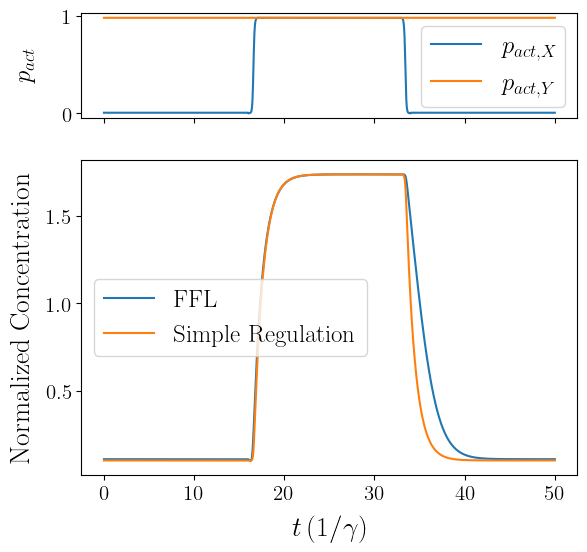

In [98]:
nstep = 5*10**4
delt = 10**(-3)

# defining how inducer concentration is tuned
flat = np.full(16000, 10**(-4))
flat_low = np.full(16000, 10**(-7))
increase = np.logspace(-7, -3, 1000)
decrease = np.logspace(-3, -7, 1000)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2]
rzs = [0, 2, 20]
w = 0

Ks = [1, 0.2, 0.6]

Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
Cys = np.full(nstep, 10**(-7))
# Cys = np.concatenate((flat, decrease, flat_low, increase, flat))

pxs = pAct(Cxs)
pys = pAct(Cys)

X = 1

# Cxs_prime = np.concatenate((flat, np.full(1000, 10**(-7)), flat_low, np.full(1000, 10**(-7)), flat))
Ys = np.full(nstep, 100)

Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForward(X, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.zeros((nstep, 3))
Rps[0, :] = steadyStateSimpleReg(X, Ys[0], rzs, w, pxs[0], pys[0], Ks)
Rps[:, 0] = np.full(nstep, X)
Rps[:, 1] = np.copy(Ys)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
    Rps[i+1, 2] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)[2]

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

# print(np.max(Rs[:, 2]) - np.min(Rs[:, 2]))
if True:
    axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
    axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    # axs[0].set_yscale("log")
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, Rs[:, 2], label=r"FFL")
axs[1].plot(ts, normalize(Rps[:, 2])*(np.max(Rs[:, 2]) - np.min(Rs[:, 2])) + np.min(Rs[:, 2]), label=r"Simple Regulation")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()
# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_fast_tuning_100.svg", format="svg", bbox_inches="tight")
plt.show()

### Middle speed tuning

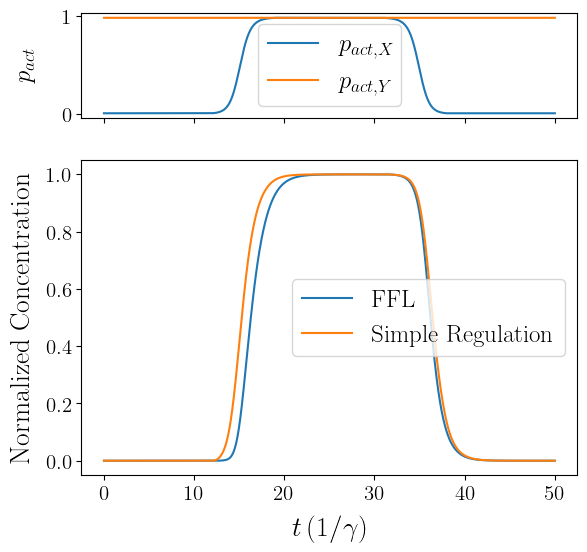

In [107]:
nstep = 5*10**4
delt = 10**(-3)

# defining how inducer concentration is tuned
flat = np.full(12000, 10**(-4))
flat_low = np.full(12000, 10**(-7))
increase = np.logspace(-7, -4, 7000)
decrease = np.logspace(-4, -7, 7000)


ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2]
rzs = [0, 2, 20]
w = 0

Ks = [1, 0.2, 0.6]

if True:
    rys = [0, 2]
    rzs = [0, 0, 2]
    w = 10

    Ks = [1, 1, 5]

Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
Cys = np.full(nstep, 10**(-7))
# Cys = np.concatenate((flat, decrease, flat_low, increase, flat))

pxs = pAct(Cxs)
pys = pAct(Cys)

X = 1

# Cxs_prime = np.full(nstep, 10**(-7))
# Cxs_prime = np.concatenate((flat, np.full(7000, 10**(-7)), flat_low, np.full(7000, 10**(-4)), flat))
# Ys = steadyStateFeedForward(X, rys, rzs, w, pAct(Cxs_prime), pAct(10**(-7)), Ks)[1]
Ys = np.full(nstep, 1)

Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForward(X, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.copy(Rs)
Rps[:, 0] = np.full(nstep, X)
Rps[:, 1] = np.copy(Ys)
Rps[0, :] = steadyStateSimpleReg(X, Ys[0], rzs, w, pxs[0], pys[0], Ks)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
    Rps[i+1, 2] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)[2]

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

# print(np.max(Rs[:, 2]) - np.min(Rs[:, 2]))
if True:
    axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
    axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    # axs[0].set_yscale("log")
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, normalize(Rs[:, 2]), label=r"FFL")
axs[1].plot(ts, normalize(Rps[:, 2]), label=r"Simple Regulation")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()
# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_middle_tuning.svg", format="svg", bbox_inches="tight")
plt.show()

In [18]:
nstep = 7000
ts = np.linspace(0, nstep*delt, nstep)
ps = pAct(decrease)
cs = [0.2, 0.8]
[t1, t2] = np.interp(cs, ps, ts)
print(t1, t2)
print(np.abs(t1 - t2))

2.306893476520309 3.953911073439121
1.647017596918812


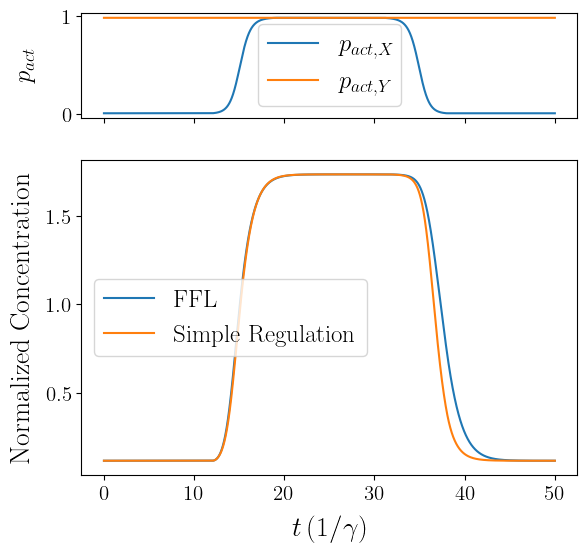

In [102]:
nstep = 5*10**4
delt = 10**(-3)

# defining how inducer concentration is tuned
flat = np.full(12000, 10**(-4))
flat_low = np.full(12000, 10**(-7))
increase = np.logspace(-7, -4, 7000)
decrease = np.logspace(-4, -7, 7000)


ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2]
rzs = [0, 2, 20]
w = 0

Ks = [1, 0.2, 0.6]

Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
Cys = np.full(nstep, 10**(-7))
# Cys = np.concatenate((flat, decrease, flat_low, increase, flat))

pxs = pAct(Cxs)
pys = pAct(Cys)

X = 1

# Cxs_prime = np.full(nstep, 10**(-7))
# Cxs_prime = np.concatenate((flat, np.full(7000, 10**(-7)), flat_low, np.full(7000, 10**(-4)), flat))
# Ys = steadyStateFeedForward(X, rys, rzs, w, pAct(Cxs_prime), pAct(10**(-7)), Ks)[1]
Ys = np.full(nstep, 0.01)

Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForward(X, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.copy(Rs)
Rps[:, 0] = np.full(nstep, X)
Rps[:, 1] = np.copy(Ys)
Rps[0, :] = steadyStateSimpleReg(X, Ys[0], rzs, w, pxs[0], pys[0], Ks)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
    Rps[i+1, 2] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)[2]

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

# print(np.max(Rs[:, 2]) - np.min(Rs[:, 2]))
if True:
    axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
    axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    # axs[0].set_yscale("log")
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, Rs[:, 2], label=r"FFL")
axs[1].plot(ts, normalize(Rps[:, 2])*(np.max(Rs[:, 2]) - np.min(Rs[:, 2])) + np.min(Rs[:, 2]), label=r"Simple Regulation")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()
# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_middle_tuning_0.01.svg", format="svg", bbox_inches="tight")
plt.show()

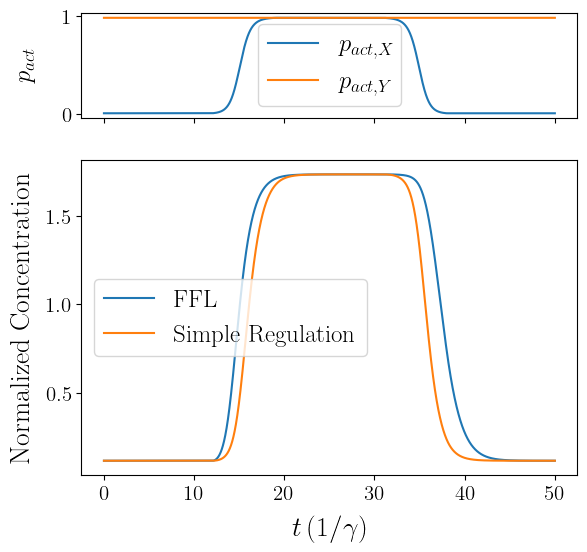

In [103]:
nstep = 5*10**4
delt = 10**(-3)

# defining how inducer concentration is tuned
flat = np.full(12000, 10**(-4))
flat_low = np.full(12000, 10**(-7))
increase = np.logspace(-7, -4, 7000)
decrease = np.logspace(-4, -7, 7000)


ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2]
rzs = [0, 2, 20]
w = 0

Ks = [1, 0.2, 0.6]

Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
Cys = np.full(nstep, 10**(-7))
# Cys = np.concatenate((flat, decrease, flat_low, increase, flat))

pxs = pAct(Cxs)
pys = pAct(Cys)

X = 1

# Cxs_prime = np.full(nstep, 10**(-7))
# Cxs_prime = np.concatenate((flat, np.full(7000, 10**(-7)), flat_low, np.full(7000, 10**(-4)), flat))
# Ys = steadyStateFeedForward(X, rys, rzs, w, pAct(Cxs_prime), pAct(10**(-7)), Ks)[1]
Ys = np.full(nstep, 100)

Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForward(X, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.copy(Rs)
Rps[:, 0] = np.full(nstep, X)
Rps[:, 1] = np.copy(Ys)
Rps[0, :] = steadyStateSimpleReg(X, Ys[0], rzs, w, pxs[0], pys[0], Ks)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
    Rps[i+1, 2] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)[2]

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

# print(np.max(Rs[:, 2]) - np.min(Rs[:, 2]))
if True:
    axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
    axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    # axs[0].set_yscale("log")
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, Rs[:, 2], label=r"FFL")
axs[1].plot(ts, normalize(Rps[:, 2])*(np.max(Rs[:, 2]) - np.min(Rs[:, 2])) + np.min(Rs[:, 2]), label=r"Simple Regulation")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()
# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_middle_tuning_100.svg", format="svg", bbox_inches="tight")
plt.show()

### Slowest tuning

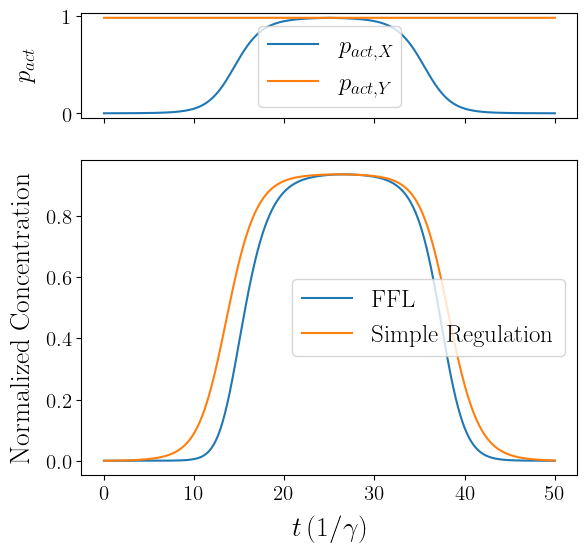

In [108]:
nstep = 5*10**4
delt = 10**(-3)

# defining how inducer concentration is tuned
flat = np.full(100, 10**(-3))
flat_low = np.full(100, 10**(-7))
increase = np.logspace(-7, -3, 24850)
decrease = np.logspace(-3, -7, 24850)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2]
rzs = [0, 2, 20]
w = 0

Ks = [1, 0.2, 0.6]

if True:
    rys = [0, 2]
    rzs = [0, 0, 2]
    w = 10

    Ks = [1, 1, 5]

Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
Cys = np.full(nstep, 10**(-7))
# Cys = np.concatenate((flat, decrease, flat_low, increase, flat))

pxs = pAct(Cxs)
pys = pAct(Cys)

X = 1

# Cxs_prime = np.full(nstep, 10**(-7))
# Cxs_prime = np.concatenate((flat, np.full(7000, 10**(-7)), flat_low, np.full(7000, 10**(-4)), flat))
# Ys = steadyStateFeedForward(X, rys, rzs, w, pAct(Cxs_prime), pAct(10**(-7)), Ks)[1]
Ys = np.full(nstep, 1)

Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForward(X, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.copy(Rs)
Rps[:, 0] = np.full(nstep, X)
Rps[:, 1] = np.copy(Ys)
Rps[0, :] = steadyStateSimpleReg(X, Ys[0], rzs, w, pxs[0], pys[0], Ks)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
    Rps[i+1, 2] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)[2]

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

# print(np.max(Rs[:, 2]) - np.min(Rs[:, 2]))
if True:
    axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
    axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    # axs[0].set_yscale("log")
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, Rs[:, 2], label=r"FFL")
axs[1].plot(ts, normalize(Rps[:, 2])*(np.max(Rs[:, 2]) - np.min(Rs[:, 2])) + np.min(Rs[:, 2]), label=r"Simple Regulation")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()
# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_slow_tuning.svg", format="svg", bbox_inches="tight")
plt.show()

In [20]:
nstep = 24850
ts = np.linspace(0, nstep*delt, nstep)
ps = pAct(decrease)
cs = [0.2, 0.8]
[t1, t2] = np.interp(cs, ps, ts)
print(t1, t2)
print(np.abs(t1 - t2))

12.354604210591955 16.739787918925032
4.385183708333077


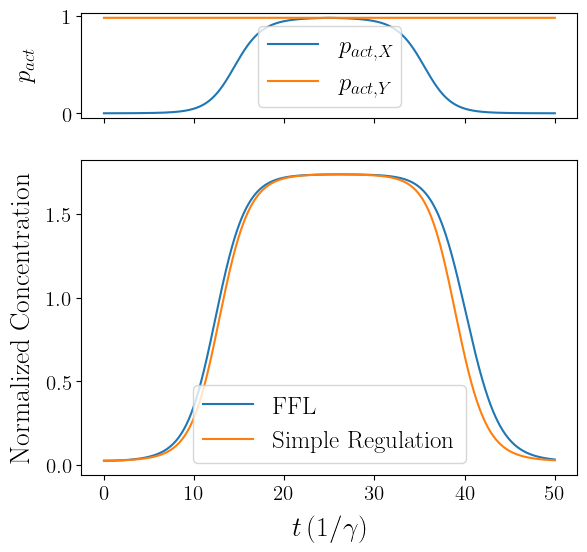

In [ ]:
nstep = 5*10**4
delt = 10**(-3)

# defining how inducer concentration is tuned
flat = np.full(100, 10**(-3))
flat_low = np.full(100, 10**(-7))
increase = np.logspace(-7, -3, 24850)
decrease = np.logspace(-3, -7, 24850)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2]
rzs = [0, 2, 20]
w = 0

Ks = [1, 0.2, 0.6]

Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
Cys = np.full(nstep, 10**(-7))
# Cys = np.concatenate((flat, decrease, flat_low, increase, flat))

pxs = pAct(Cxs)
pys = pAct(Cys)

X = 1

# Cxs_prime = np.full(nstep, 10**(-7))
# Cxs_prime = np.concatenate((flat, np.full(7000, 10**(-7)), flat_low, np.full(7000, 10**(-4)), flat))
# Ys = steadyStateFeedForward(X, rys, rzs, w, pAct(Cxs_prime), pAct(10**(-7)), Ks)[1]
Ys = np.full(nstep, 0.01)

Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForward(X, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.copy(Rs)
Rps[:, 0] = np.full(nstep, X)
Rps[:, 1] = np.copy(Ys)
Rps[0, :] = steadyStateSimpleReg(X, Ys[0], rzs, w, pxs[0], pys[0], Ks)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
    Rps[i+1, 2] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)[2]

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

# print(np.max(Rs[:, 2]) - np.min(Rs[:, 2]))
if True:
    axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
    axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    # axs[0].set_yscale("log")
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, Rs[:, 2], label=r"FFL")
axs[1].plot(ts, normalize(Rps[:, 2])*(np.max(Rs[:, 2]) - np.min(Rs[:, 2])) + np.min(Rs[:, 2]), label=r"Simple Regulation")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()
# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_slow_tuning_0.01.svg", format="svg", bbox_inches="tight")
plt.show()

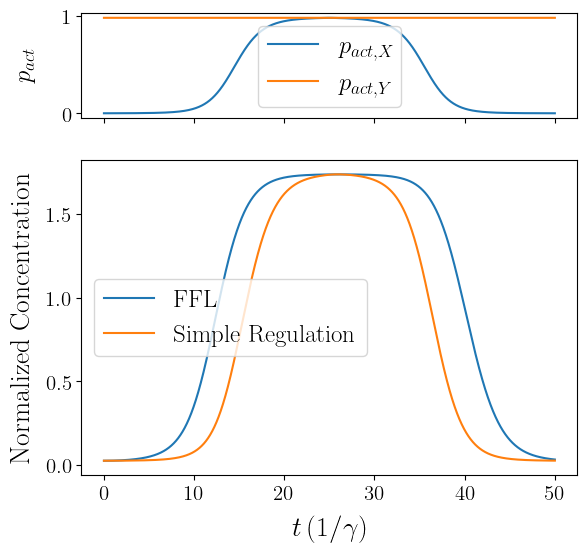

In [105]:
nstep = 5*10**4
delt = 10**(-3)

# defining how inducer concentration is tuned
flat = np.full(100, 10**(-3))
flat_low = np.full(100, 10**(-7))
increase = np.logspace(-7, -3, 24850)
decrease = np.logspace(-3, -7, 24850)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2]
rzs = [0, 2, 20]
w = 0

Ks = [1, 0.2, 0.6]

Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
Cys = np.full(nstep, 10**(-7))
# Cys = np.concatenate((flat, decrease, flat_low, increase, flat))

pxs = pAct(Cxs)
pys = pAct(Cys)

X = 1

# Cxs_prime = np.full(nstep, 10**(-7))
# Cxs_prime = np.concatenate((flat, np.full(7000, 10**(-7)), flat_low, np.full(7000, 10**(-4)), flat))
# Ys = steadyStateFeedForward(X, rys, rzs, w, pAct(Cxs_prime), pAct(10**(-7)), Ks)[1]
Ys = np.full(nstep, 100)

Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForward(X, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.copy(Rs)
Rps[:, 0] = np.full(nstep, X)
Rps[:, 1] = np.copy(Ys)
Rps[0, :] = steadyStateSimpleReg(X, Ys[0], rzs, w, pxs[0], pys[0], Ks)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
    Rps[i+1, 2] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)[2]

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

# print(np.max(Rs[:, 2]) - np.min(Rs[:, 2]))
if True:
    axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
    axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    # axs[0].set_yscale("log")
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, Rs[:, 2], label=r"FFL")
axs[1].plot(ts, normalize(Rps[:, 2])*(np.max(Rs[:, 2]) - np.min(Rs[:, 2])) + np.min(Rs[:, 2]), label=r"Simple Regulation")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()
# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_slow_tuning_100.svg", format="svg", bbox_inches="tight")
plt.show()

Question: are these simply the steady states?

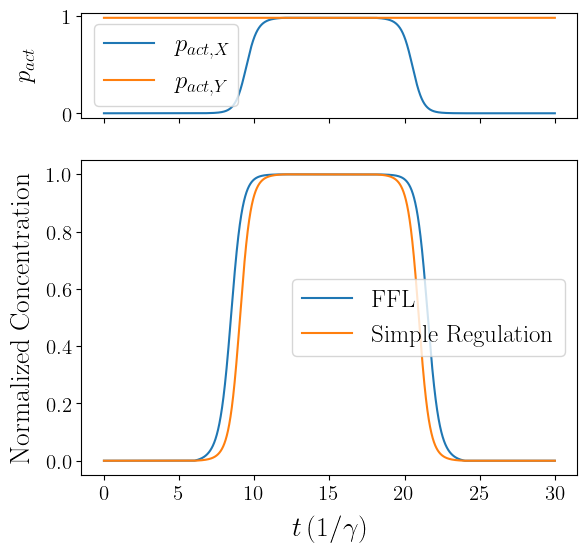

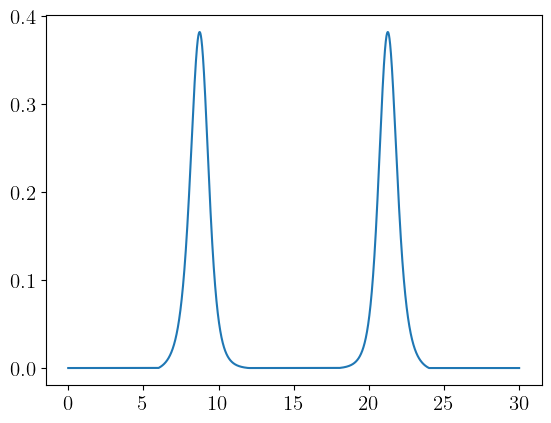

In [23]:
nstep = 3*10**4
delt = 10**(-3)

# defining how inducer concentration is tuned
flat = np.full(int(nstep/5), 10**(-3))
flat_low = np.full(int(nstep/5), 10**(-7))
increase = np.logspace(-7, -3, int(nstep/5))
decrease = np.logspace(-3, -7, int(nstep/5))

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 1]
rzs = [0, 1, 10]
w = 0

Ks = [0.5, 0.1, 0.3]
# defining how inducer concentration is tuned

Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
Cys = np.full(nstep, 10**(-7))

pxs = pAct(Cxs)
pys = pAct(Cys)

Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForward(1, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.zeros((nstep, 3))
X, Y = [1, 1]
Rps[0, :] = steadyStateSimpleReg(X, Y, rzs, w, pxs[0], pys[0], Ks)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = steadyStateFeedForward(X, rys, rzs, w, px, py, Ks)
    Rps[i+1, :] = steadyStateSimpleReg(X, Y, rzs, w, px, py, Ks)

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

if True:
    axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
    axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    # axs[0].set_yscale("log")
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, normalize(Rs[:, 2]), label=r"FFL")
axs[1].plot(ts, normalize(Rps[:, 2]), label=r"Simple Regulation")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()
# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\0826\fedFor7.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.plot(ts, normalize(Rs[:, 2]) - normalize(Rps[:, 2]))
plt.show()

We see that steady state is a good approximation of its behavior.

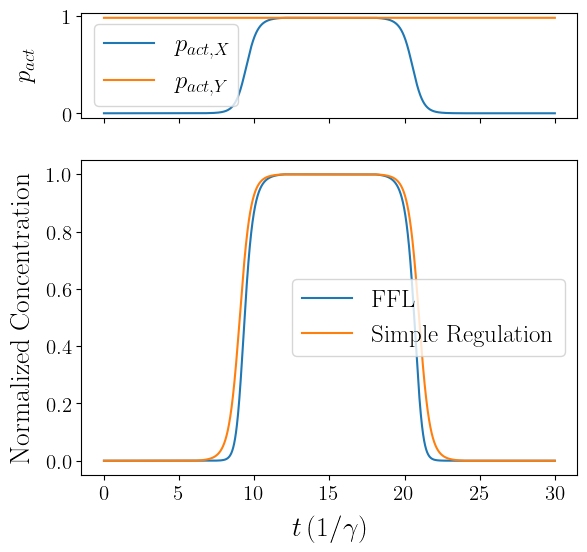

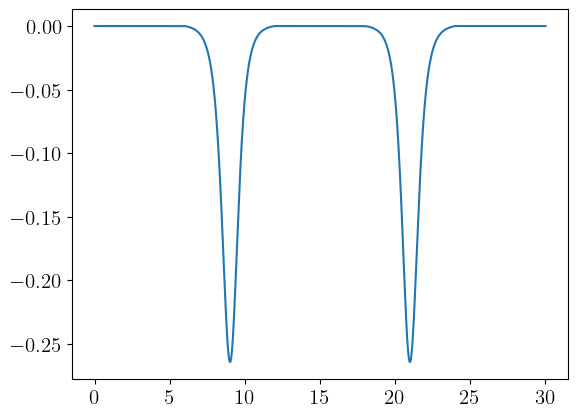

In [10]:
# defining how inducer concentration is tuned
flat = np.full(int(nstep/5), 10**(-3))
flat_low = np.full(int(nstep/5), 10**(-7))
increase = np.logspace(-7, -3, int(nstep/5))
decrease = np.logspace(-3, -7, int(nstep/5))

nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2]
rzs = [0, 0, 2]
w = 10

Ks = [1, 1, 5]
# defining how inducer concentration is tuned

Cxs = np.concatenate((flat, decrease, flat_low, increase, flat))
# Cxs = np.concatenate((flat, flat_low, flat_low, flat, flat))
Cys = np.full(nstep, 10**(-7))

pxs = pAct(Cxs)
pys = pAct(Cys)

Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForward(1, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.zeros((nstep, 3))
X, Y = [1, 1]
Rps[0, :] = steadyStateSimpleReg(X, Y, rzs, w, pxs[0], pys[0], Ks)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = steadyStateFeedForward(X, rys, rzs, w, px, py, Ks)
    Rps[i+1, :] = steadyStateSimpleReg(X, Y, rzs, w, px, py, Ks)

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

if True:
    axs[0].plot(ts, pxs, label=r"$p_{act,X}$")
    axs[0].plot(ts, pys, label=r"$p_{act,Y}$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    # axs[0].set_yscale("log")
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

# axs[2].plot(ts, Rs[:, 2]/max(Rs[:, 2]), label=r"$Z$")
# axs[2].plot(ts, Rps[:, 2]/max(Rps[:, 2]), label=r"$Simple Regulation$")
axs[1].plot(ts, normalize(Rs[:, 2]), label=r"FFL")
axs[1].plot(ts, normalize(Rps[:, 2]), label=r"Simple Regulation")
axs[1].set_xlabel(r"$t \, (1/\gamma)$")
axs[1].set_ylabel(r"Normalized Concentration")
axs[1].legend()
fig.align_labels()
# plt.text(-0.1, 1, r"(a)", transform=axs[0].transAxes, fontsize=21)
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\0826\fedFor7.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.plot(ts, normalize(Rs[:, 2]) - normalize(Rps[:, 2]))
plt.show()

### analytics

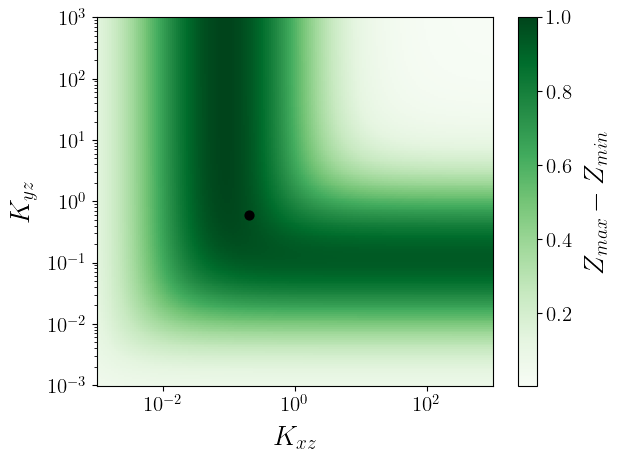

In [14]:
rys = [0, 2]
rzs = [0, 2, 20]
w = 0

length = 200

plow = pAct(10**(-4))
phigh = pAct(10**(-7))

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

KX, KY = np.meshgrid(Kxzs, Kyzs)
KXY = np.full_like(KX, 1)
Ks = [KXY, KX, KY]

Xs = np.full_like(KX, 1)

[_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
[_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

delta = int_delta(rzs, w, plow*1/KX, (highY - lowY)/KY, lowY/KY)

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, (highZ - lowZ)/np.max(highZ - lowZ), cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$K_{xz}$")
ax.set_ylabel(r"$K_{yz}$")
ax.scatter(0.2, 0.6, s = 40, c='black')
cbar = plt.colorbar(im)
cbar.set_label(r"$Z_{max} - Z_{min}$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL5.svg", format="svg", bbox_inches="tight")
plt.show()

